<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/experiments/VAE/LSTM_VAE_08_29_char2ind_works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/bayeslabs/genmol/blob/master/genmol/vae/data.py

# https://github.com/aspuru-guzik-group/selfies/blob/master/examples/vae_example/chemistry_vae.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! pip install PyTDC --quiet
! pip install selfies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.0 MB/s eta 0:00:00


In [1]:
from tdc.generation import MolGen
import selfies as sf
from tqdm import tqdm
data = MolGen(name = 'ZINC')
split = data.get_split()
train = split['train']
valid = split['valid']
test = split['test']

Found local copy...
Loading...
Done!


In [ ]:
small_smiles = []
for benzene in tqdm(train['smiles']):
    try:
        benzene_sf = sf.encoder(benzene)  # [C][=C][C][=C][C][=C][Ring1][=Branch1]
        benzene_smi = sf.decoder(benzene_sf)  # C1=CC=CC=C1
        length = sf.len_selfies(benzene_sf)  # 8
        if length < 20:
            small_smiles.append(benzene)
    except sf.EncoderError:
        pass  # sf.encoder error!
    except sf.DecoderError:
        pass  # sf.decoder error!


    # symbols_benzene = list(sf.split_selfies(benzene_sf))

In [ ]:
# del len
alphabet= sf.get_alphabet_from_selfies(small_smiles)
alphabet.add("[nop]", '[bos]', '[eos]', '[unk]')
len(alphabet)

In [134]:
import torch
chars = set()
for string in train['smiles']:
    chars.update(string)
all_sys =  ['<pad>', '<bos>', '<eos>', '<unk>'] + sorted(list(chars))
vocab = all_sys
c2i = {c: i for i, c in enumerate(all_sys)}
i2c = {i: c for i, c in enumerate(all_sys)}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vector = torch.eye(len(c2i))

def char2id(char):
    if char not in c2i:
        return c2i['<unk>']
    else:
        return c2i[char]


def id2char(id):
    if id not in i2c:
        return i2c[c2i['<unk>']]
    else:
        return i2c[id]

def string2ids(string,add_bos=False, add_eos=False):
    ids = [char2id(c) for c in string]
    if add_bos:
        ids = [c2i['<bos>']] + ids
    if add_eos:
        ids = ids + [c2i['<eos>']]
    return ids
def ids2string(ids, rem_bos=True, rem_eos=True):
    # print(ids)
    if isinstance(ids[0], list): ids = ids[0]
    if len(ids) == 0:
        return ''
    if rem_bos and ids[0] == c2i['<bos>']:
        ids = ids[1:]
    # delete <eos>
    if rem_eos:
        for i, id in enumerate(ids):
            # print(i, id)
            if id == c2i['<eos>']:
                ids = ids[:i]
                break

    # if rem_eos and ids[-1] == c2i['<eos>']:
    #     ids = ids[:-1]

    string = ''.join([id2char(id) for id in ids])
    return string

def string2tensor(string, device='model'):
    ids = string2ids(string, add_bos=True, add_eos=True)
    tensor = torch.tensor(ids, dtype=torch.long,device=device if device == 'model' else device)
    return tensor
tensor = [string2tensor(string, device=device) for string in train['smiles']]
vector = torch.eye(len(c2i))  # (alphabet_len, alphabet_len)

In [121]:
ids2string(l)

'Cc1ccc(-22-C1ncc((N2)c(=O)(=O)ccc=)(C)C'

In [135]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F

q_bidir = True
q_d_h = 256
q_n_layers = 1
q_dropout = 0.5
d_n_layers = 3
d_dropout = 0
d_z = 128 * 2 ############################################
d_d_h = 512
# from data import *
class VAE(nn.Module):
  def __init__(self,vocab,vector):
    super().__init__()
    self.vocabulary = vocab
    self.vector = vector

    n_vocab, d_emb = len(vocab), vector.size(1)
    self.x_emb = nn.Embedding(n_vocab, d_emb, c2i['<pad>'])
    self.x_emb.weight.data.copy_(vector)

    #ENCODER

    self.encoder_rnn = nn.GRU(d_emb,q_d_h,num_layers=q_n_layers,batch_first=True,dropout=q_dropout if q_n_layers > 1 else 0,bidirectional=q_bidir)
    q_d_last = q_d_h * (2 if q_bidir else 1)
    self.q_mu = nn.Linear(q_d_last, d_z)
    self.q_logvar = nn.Linear(q_d_last, d_z)



    # Decoder
    self.decoder_rnn = nn.GRU(d_emb + d_z,d_d_h,num_layers=d_n_layers,batch_first=True,dropout=d_dropout if d_n_layers > 1 else 0)
    self.decoder_latent = nn.Linear(d_z, d_d_h)
    self.decoder_fullyc = nn.Linear(d_d_h, n_vocab)



    # Grouping the model's parameters
    self.encoder = nn.ModuleList([self.encoder_rnn,self.q_mu,self.q_logvar])
    self.decoder = nn.ModuleList([self.decoder_rnn,self.decoder_latent,self.decoder_fullyc])
    self.vae = nn.ModuleList([self.x_emb,self.encoder,self.decoder])



  @property
  def device(self):
    return next(self.parameters()).device

  def string2tensor(self, string, device='model'):
    ids = string2ids(string, add_bos=True, add_eos=True)
    tensor = torch.tensor(ids, dtype=torch.long,device=self.device if device == 'model' else device)
    return tensor

  def tensor2string(self, tensor):
    ids = tensor.tolist()
    string = ids2string(ids, rem_bos=True, rem_eos=True)
    return string

  def forward(self,x):
    z, kl_loss = self.forward_encoder(x)
    _, recon_loss = self.forward_decoder(x, z)
    # print("forward")
    return kl_loss, recon_loss

  def reconstruct(self, x):
    z, _ = self.forward_encoder(x)
    y, _ = self.forward_decoder(x, z)
    return y


  def forward_encoder(self,x):
    x = [self.x_emb(i_x) for i_x in x]
    x = nn.utils.rnn.pack_sequence(x)
    _, h = self.encoder_rnn(x, None)
    h = h[-(1 + int(self.encoder_rnn.bidirectional)):]
    h = torch.cat(h.split(1), dim=-1).squeeze(0)
    mu, logvar = self.q_mu(h), self.q_logvar(h)
    eps = torch.randn_like(mu)
    z = mu + (logvar / 2).exp() * eps
    kl_loss = 0.5 * (logvar.exp() + mu ** 2 - 1 - logvar).sum(1).mean()
    return z, kl_loss

  def forward_decoder(self,x, z):
    lengths = [len(i_x) for i_x in x]
    x = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value= c2i['<pad>'])
    x_emb = self.x_emb(x)
    z_0 = z.unsqueeze(1).repeat(1, x_emb.size(1), 1)
    x_input = torch.cat([x_emb, z_0], dim=-1)
    x_input = nn.utils.rnn.pack_padded_sequence(x_input, lengths, batch_first=True)
    h_0 = self.decoder_latent(z)
    h_0 = h_0.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)
    output, _ = self.decoder_rnn(x_input, h_0)
    output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
    y = self.decoder_fullyc(output)

    recon_loss = F.cross_entropy(y[:, :-1].contiguous().view(-1, y.size(-1)),
                                 x[:, 1:].contiguous().view(-1),ignore_index= c2i['<pad>'])
    return y, recon_loss


  def sample_z_prior(self,n_batch):
    return torch.randn(n_batch,self.q_mu.out_features,device= self.x_emb.weight.device)

  def sample(self,n_batch, max_len=100, z=None, temp=1.0):
    with torch.no_grad():
      if z is None:
        z = self.sample_z_prior(n_batch)
        z = z.to(self.device)
        z_0 = z.unsqueeze(1)
        h = self.decoder_latent(z)
        h = h.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)
        w = torch.tensor(c2i['<bos>'], device=self.device).repeat(n_batch)
        x = torch.tensor([c2i['<pad>']], device=device).repeat(n_batch, max_len)
        x[:, 0] = c2i['<bos>']
        end_pads = torch.tensor([max_len], device=self.device).repeat(n_batch)
        eos_mask = torch.zeros(n_batch, dtype=torch.uint8, device=self.device)


        for i in range(1, max_len):
          x_emb = self.x_emb(w).unsqueeze(1)
          x_input = torch.cat([x_emb, z_0], dim=-1)

          o, h = self.decoder_rnn(x_input, h)
          y = self.decoder_fullyc(o.squeeze(1))
          y = F.softmax(y / temp, dim=-1)

          w = torch.multinomial(y, 1)[:, 0]
          x[~eos_mask, i] = w[~eos_mask]
          i_eos_mask = ~eos_mask & (w == c2i['<eos>'])
          end_pads[i_eos_mask] = i + 1
          eos_mask = eos_mask | i_eos_mask


          new_x = []
          for i in range(x.size(0)):
            new_x.append(x[i, :end_pads[i]])


    return [self.tensor2string(i_x) for i_x in new_x]

In [139]:
# -*- coding: utf-8 -*-
from torch.optim.lr_scheduler import _LRScheduler
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
import math
import numpy as np
from collections import UserList, defaultdict
n_last = 1000
n_batch = 512
kl_start = 0
kl_w_start = 0.0
kl_w_end = 1.0 ###############################
n_epoch = 500
n_workers = 0

clip_grad  = 50
lr_start = 0.003
lr_n_period = 10
lr_n_mult = 1
lr_end = 3 * 1e-4
lr_n_restarts = 1 ###############################

# from data import *

def _n_epoch():
    return sum(lr_n_period * (lr_n_mult ** i) for i in range(lr_n_restarts))

def _train_epoch(model, epoch, train_loader, kl_weight, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    kl_loss_values = CircularBuffer(n_last)
    recon_loss_values = CircularBuffer(n_last)
    loss_values = CircularBuffer(n_last)
    for i, input_batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        input_batch = tuple(data.to(device) for data in input_batch)

    #forward
        kl_loss, recon_loss = model(input_batch)
        loss = kl_weight * kl_loss + recon_loss
    #backward
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(get_optim_params(model), clip_grad)
            optimizer.step()

        kl_loss_values.add(kl_loss.item())
        recon_loss_values.add(recon_loss.item())
        loss_values.add(loss.item())
        lr = (optimizer.param_groups[0]['lr'] if optimizer is not None else None)

    #update train_loader
        kl_loss_value = kl_loss_values.mean()
        recon_loss_value = recon_loss_values.mean()
        loss_value = loss_values.mean()
        postfix = [f'loss={loss_value:.5f}',f'(kl={kl_loss_value:.5f}',
                   f'recon={recon_loss_value:.5f})',
                   f'klw={kl_weight:.5f} lr={lr:.5f}']
        if i % (len(train_loader)/3) == 0 and i!= 0:
            print(f'Epoch {epoch}: {i}/{len(train_loader)} |', postfix)
    postfix = {'epoch': epoch,'kl_weight': kl_weight,'lr': lr,
               'kl_loss': kl_loss_value,'recon_loss': recon_loss_value,
               'loss': loss_value,'mode': 'Eval' \
               if optimizer is None else 'Train'}
    sample_smis = sample.take_samples(model, n_batch)
    valid_rate = visual_mols(sample_smis)
    if valid_rate > 0.5:
        print('save model ckpt.pt')
        torch.save(model.state_dict(), 'ckpt.pt')
    recon_test(model)
    # print(postfix)
    return postfix

def _train(model, train_loader, val_loader=None, logger=None):
    optimizer = optim.Adam(get_optim_params(model),lr= lr_start)

    lr_annealer = CosineAnnealingLRWithRestart(optimizer)

    model.zero_grad()
    for epoch in range(n_epoch):

        kl_annealer = KLAnnealer(n_epoch)
        kl_weight = kl_annealer(epoch)
        postfix = _train_epoch(model, epoch, train_loader, kl_weight, optimizer)
        lr_annealer.step()

def fit(model, train_data, val_data=None):
    logger = Logger() if False is not None else None
    train_loader = get_dataloader(model, train_data, shuffle=True)


    val_loader = None if val_data is None else get_dataloader(model, val_data, shuffle=False)
    _train(model, train_loader, val_loader, logger)
    return model

def get_collate_device(model):
    return model.device
def get_dataloader(model, train_data, collate_fn=None, shuffle=True):
    if collate_fn is None:
        collate_fn = get_collate_fn(model)
        print(collate_fn)
    return DataLoader(train_data, batch_size=n_batch, shuffle=shuffle, num_workers=n_workers, collate_fn=collate_fn)

def get_collate_fn(model):
    device = get_collate_device(model)

    def collate(train_data):
        train_data.sort(key=len, reverse=True)
        tensors = [string2tensor(string, device=device) for string in train_data]
        return tensors

    return collate

def get_optim_params(model):
    return (p for p in model.parameters() if p.requires_grad)

class KLAnnealer:
    def __init__(self,n_epoch):
        self.i_start = kl_start
        self.w_start = kl_w_start
        self.w_max = kl_w_end
        self.n_epoch = n_epoch


        self.inc = (self.w_max - self.w_start) / (self.n_epoch - self.i_start)

    def __call__(self, i):
        k = (i - self.i_start) if i >= self.i_start else 0
        return self.w_start + k * self.inc



class CosineAnnealingLRWithRestart(_LRScheduler):
    def __init__(self , optimizer):
        self.n_period = lr_n_period
        self.n_mult = lr_n_mult
        self.lr_end = lr_end

        self.current_epoch = 0
        self.t_end = self.n_period

        # Also calls first epoch
        super().__init__(optimizer, -1)

    def get_lr(self):
        return [self.lr_end + (base_lr - self.lr_end) *
                (1 + math.cos(math.pi * self.current_epoch / self.t_end)) / 2
                for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

        if self.current_epoch == self.t_end:
            self.current_epoch = 0
            self.t_end = self.n_mult * self.t_end




class CircularBuffer:
    def __init__(self, size):
        self.max_size = size
        self.data = np.zeros(self.max_size)
        self.size = 0
        self.pointer = -1

    def add(self, element):
        self.size = min(self.size + 1, self.max_size)
        self.pointer = (self.pointer + 1) % self.max_size
        self.data[self.pointer] = element
        return element

    def last(self):
        assert self.pointer != -1, "Can't get an element from an empty buffer!"
        return self.data[self.pointer]

    def mean(self):
        return self.data.mean()


class Logger(UserList):
    def __init__(self, data=None):
        super().__init__()
        self.sdata = defaultdict(list)
        for step in (data or []):
            self.append(step)

    def __getitem__(self, key):
        if isinstance(key, int):
            return self.data[key]
        elif isinstance(key, slice):
            return Logger(self.data[key])
        else:
            ldata = self.sdata[key]
            if isinstance(ldata[0], dict):
                return Logger(ldata)
            else:
                return ldata

    def append(self, step_dict):
        super().append(step_dict)
        for k, v in step_dict.items():
            self.sdata[k].append(v)

In [140]:
# from tqdm import tqdm
import pandas as pd
n_samples = 3000
n_jobs = 1
max_len = 100

class sample():
  def take_samples(model,n_batch):
    n = n_samples
    samples = []
    with tqdm(total=n_samples, desc='Generating samples') as T:
      while n > 0:
        current_samples = model.sample(min(n, n_batch), max_len)
        samples.extend(current_samples)
        n -= len(current_samples)
        T.update(len(current_samples))
    samples = pd.DataFrame(samples, columns=['SMILES'])
    return samples

from IPython.display import display
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

m = Chem.MolFromSmiles
def visual_mols(sample_smis):

    valid_smis = []
    for i in sample_smis.SMILES:
        try:
            mol = m(i)
            if mol != None: valid_smis.append(i)
        except: pass
    valid_rate = len(valid_smis) / len(sample_smis)
    unique_smis = [*set(valid_smis)]
    unique_rate = len(unique_smis) / len(sample_smis)

    print(f'valid {valid_rate*100:.3f}%  |  unique {unique_rate*100:.3f}%')

    from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

    MAX_GRID = 16
    img = MolsToGridImage(
        [m(smi) for smi in unique_smis[:MAX_GRID]],
        molsPerRow=int(math.sqrt(MAX_GRID)),
        subImgSize=(250, 150),  returnPNG=False)
    display(img)
    return valid_rate

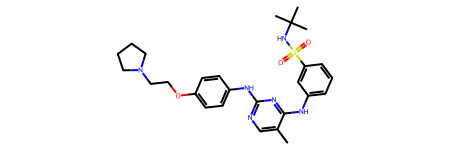

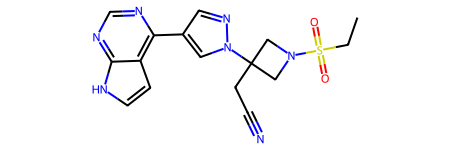

(None, None)

In [126]:
fed = 'Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1'
bar = 'CCS(=O)(=O)N1CC(C1)(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3'
display(m(fed)), display(m(bar))

In [127]:
model.string2tensor(fed)

tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')

In [141]:
model = VAE(vocab, vector).to(device)

model.string2tensor(fed)
def recon_test(model):
    test_smiles = [fed]
    te = [string2tensor(string, device=device) for string in test_smiles]

    y = model.reconstruct(te)
    temp = 1
    y_ = F.softmax(y / temp, dim=-1)
    y_here = torch.argmax(y_, dim=-1)
    y_here.shape
    l = y_here.cpu().detach().tolist()
    print('true: ', model.string2tensor(fed))
    print('pred:', l)
    smi_recon = [ids2string(ids, rem_bos=True, rem_eos=True) for ids in l]
    for i in smi_recon:
        # print(i)
        try:
            print('fed smi:', fed)
            print('pred smi:', i)
            mol = m(i)
            if mol != None: display(mol)
            else: print('mol is none, cannot recon')
        except: print('invalid smi, cannot recon')

In [129]:
test_smiles = [fed]
te = [string2tensor(string, device=device) for string in test_smiles]

y = model.reconstruct(te)
temp = 1
y_ = F.softmax(y / temp, dim=-1)
y_here = torch.argmax(y_, dim=-1)
y_here.shape
l = y_here.cpu().detach().tolist()
print('true: ', model.string2tensor(fed))
print('pred:', l)
smi_recon = [ids2string(ids, rem_bos=True, rem_eos=True) for ids in l]
for i in smi_recon:
    print(i)

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[35, 35, 35, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]]
ooo555555555555555555555555555555555555555555555555555555555555


<function get_collate_fn.<locals>.collate at 0x7b7fb60a8790>


 34%|███▎      | 115/342 [00:44<01:27,  2.60it/s]

Epoch 0: 114/342 | ['loss=0.27968', '(kl=7.37665', 'recon=0.27968)', 'klw=0.00000 lr=0.00293']


 67%|██████▋   | 229/342 [01:29<00:44,  2.57it/s]

Epoch 0: 228/342 | ['loss=0.40338', '(kl=54.14164', 'recon=0.40338)', 'klw=0.00000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 373.00it/s]

valid 4.133%  |  unique 1.933%


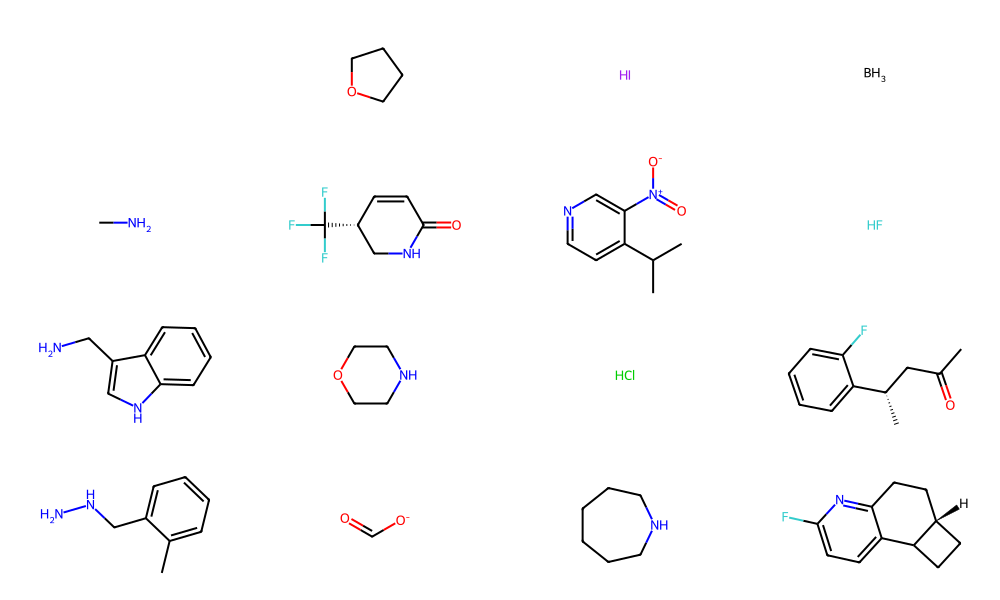

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 8, 32, 11, 8, 21, 10, 32, 32, 32, 5, 5, 21, 10, 6, 21, 5, 18, 26, 6, 5, 18, 26, 6, 21, 10, 5, 18, 6, 5, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 21, 10, 10, 21, 21, 21, 21, 21, 10, 2, 2, 26, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(-c2-C1ccc((C1)C(=O)(=O)C1(=)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:45<01:29,  2.52it/s]

Epoch 1: 114/342 | ['loss=0.08423', '(kl=4.17143', 'recon=0.07589)', 'klw=0.00200 lr=0.00274']


 67%|██████▋   | 229/342 [01:31<00:46,  2.44it/s]

Epoch 1: 228/342 | ['loss=0.15125', '(kl=7.26462', 'recon=0.13672)', 'klw=0.00200 lr=0.00274']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 377.75it/s]


valid 45.933%  |  unique 45.733%


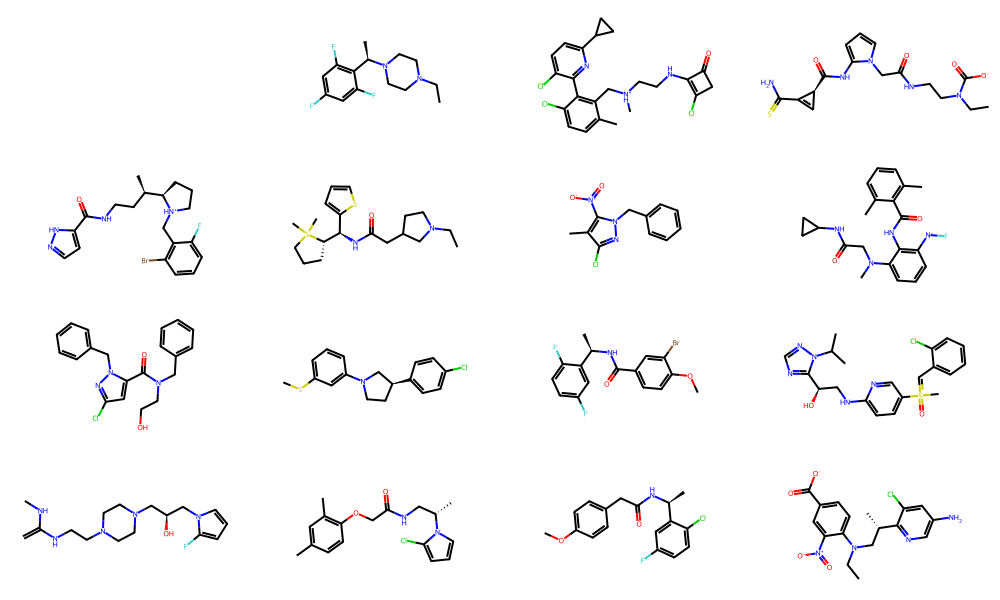

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 8, 32, 11, 32, 32, 10, 32, 32, 32, 5, 5, 21, 11, 6, 25, 5, 18, 26, 6, 5, 18, 26, 6, 32, 10, 10, 18, 6, 5, 21, 6, 21, 21, 25, 10, 10, 32, 32, 32, 32, 21, 11, 10, 21, 21, 21, 21, 26, 11, 21, 5, 26, 21, 11, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(-c2cc1ccc((C2)N(=O)(=O)c11=)(C)CCN11ccccC21CCCCO2C(OC2=C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:32,  2.46it/s]

Epoch 2: 114/342 | ['loss=0.05827', '(kl=2.42577', 'recon=0.04856)', 'klw=0.00400 lr=0.00244']


 67%|██████▋   | 229/342 [01:32<00:45,  2.47it/s]

Epoch 2: 228/342 | ['loss=0.11099', '(kl=4.85559', 'recon=0.09157)', 'klw=0.00400 lr=0.00244']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 386.25it/s]


valid 59.100%  |  unique 59.100%


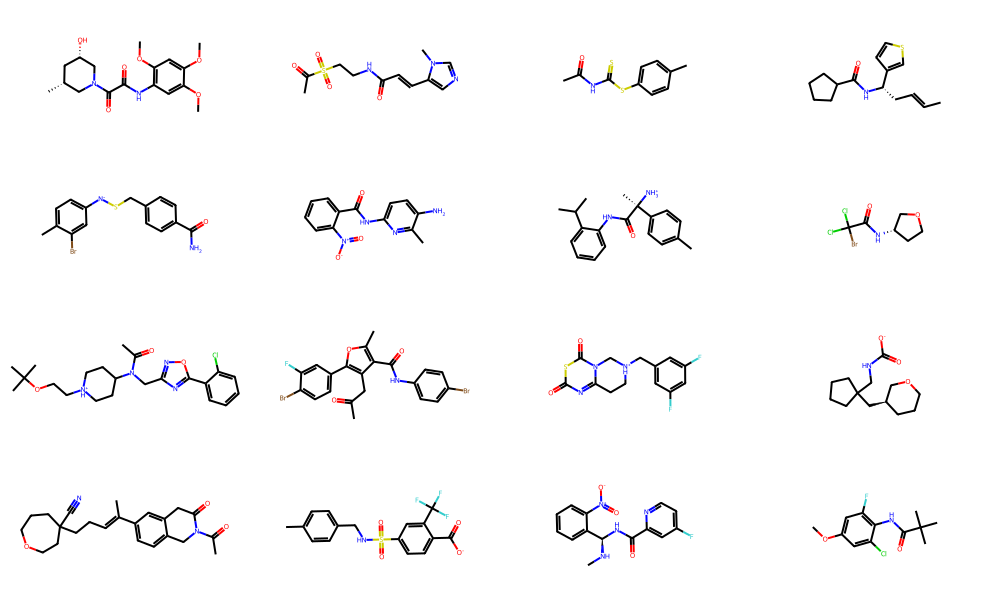

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 8, 32, 11, 32, 32, 10, 32, 32, 32, 5, 5, 28, 11, 6, 25, 5, 18, 26, 6, 5, 18, 26, 6, 21, 5, 5, 18, 6, 5, 21, 6, 21, 32, 32, 10, 10, 32, 32, 32, 32, 21, 11, 11, 21, 21, 21, 21, 26, 11, 21, 2, 5, 5, 5, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(-c2cc1ccc((S2)N(=O)(=O)C((=)(C)Ccc11ccccC22CCCCO2C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.49it/s]

Epoch 3: 114/342 | ['loss=0.05257', '(kl=2.26401', 'recon=0.03899)', 'klw=0.00600 lr=0.00207']


 67%|██████▋   | 229/342 [01:32<00:46,  2.41it/s]

Epoch 3: 228/342 | ['loss=0.10291', '(kl=4.54424', 'recon=0.07564)', 'klw=0.00600 lr=0.00207']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 385.63it/s]


valid 64.900%  |  unique 64.900%


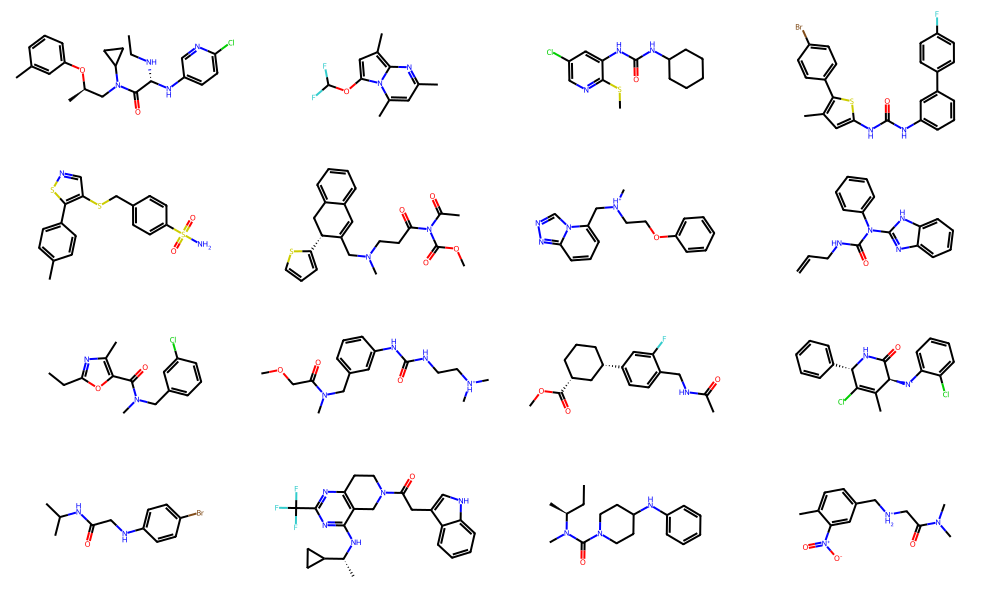

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 8, 32, 11, 8, 32, 10, 32, 32, 32, 32, 5, 25, 11, 6, 25, 5, 18, 26, 6, 5, 18, 26, 6, 25, 10, 21, 18, 6, 5, 21, 6, 21, 32, 25, 5, 10, 32, 32, 32, 32, 22, 32, 11, 21, 21, 21, 21, 21, 11, 21, 2, 5, 5, 5, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(-c2-c1cccc(N2)N(=O)(=O)N1C=)(C)CcN(1ccccFc2CCCCC2C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:34,  2.41it/s]

Epoch 4: 114/342 | ['loss=0.05227', '(kl=2.13665', 'recon=0.03517)', 'klw=0.00800 lr=0.00165']


 67%|██████▋   | 229/342 [01:33<00:46,  2.45it/s]

Epoch 4: 228/342 | ['loss=0.10296', '(kl=4.26405', 'recon=0.06884)', 'klw=0.00800 lr=0.00165']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 381.83it/s]


valid 68.800%  |  unique 68.800%


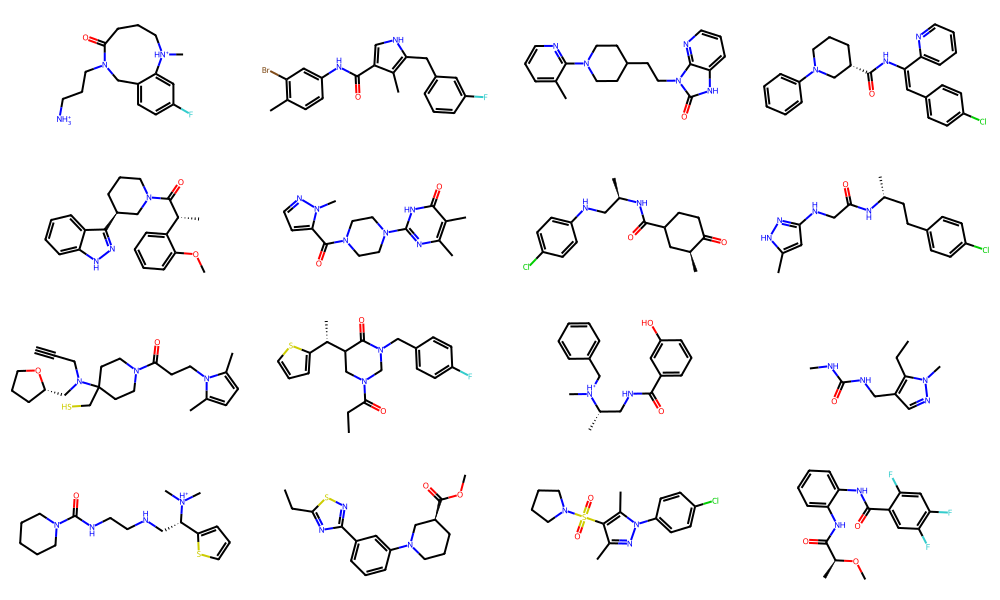

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 35, 34, 32, 5, 8, 32, 11, 32, 32, 10, 32, 32, 32, 5, 5, 21, 11, 6, 25, 5, 18, 26, 6, 5, 18, 26, 6, 25, 10, 21, 18, 6, 5, 21, 6, 21, 5, 32, 10, 10, 32, 32, 32, 5, 21, 34, 11, 21, 21, 21, 21, 21, 11, 21, 2, 10, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1onc(-c2cc1ccc((C2)N(=O)(=O)N1C=)(C)C(c11ccc(Cn2CCCCC2C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.49it/s]

Epoch 5: 114/342 | ['loss=0.05339', '(kl=1.98825', 'recon=0.03350)', 'klw=0.01000 lr=0.00123']


 67%|██████▋   | 229/342 [01:33<00:47,  2.40it/s]

Epoch 5: 228/342 | ['loss=0.10554', '(kl=3.94627', 'recon=0.06607)', 'klw=0.01000 lr=0.00123']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 383.79it/s]


valid 74.333%  |  unique 74.333%


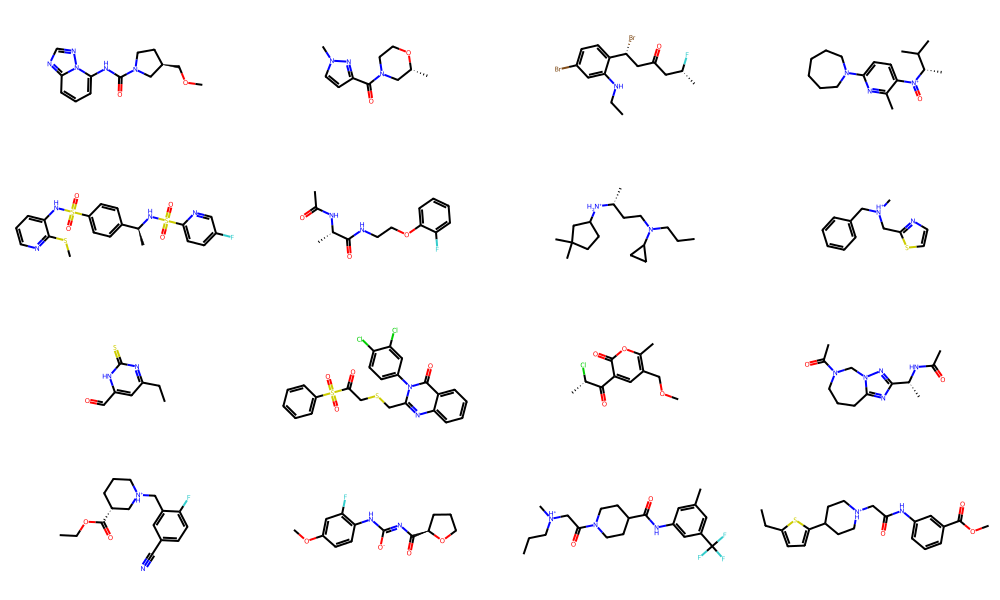

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 34, 34, 32, 5, 8, 32, 11, 32, 32, 10, 32, 32, 32, 5, 5, 28, 11, 6, 28, 5, 18, 26, 6, 5, 18, 26, 6, 21, 10, 21, 18, 6, 5, 21, 6, 21, 5, 32, 10, 10, 32, 32, 32, 32, 22, 11, 11, 2, 21, 21, 26, 26, 11, 2, 2, 26, 26, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1nnc(-c2cc1ccc((S2)S(=O)(=O)C1C=)(C)C(c11ccccF22
mol is none, cannot recon


 34%|███▎      | 115/342 [00:47<01:33,  2.42it/s]

Epoch 6: 114/342 | ['loss=0.05495', '(kl=1.83199', 'recon=0.03297)', 'klw=0.01200 lr=0.00086']


 67%|██████▋   | 229/342 [01:33<00:45,  2.48it/s]

Epoch 6: 228/342 | ['loss=0.10875', '(kl=3.62519', 'recon=0.06525)', 'klw=0.01200 lr=0.00086']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 379.09it/s]


valid 78.333%  |  unique 78.333%


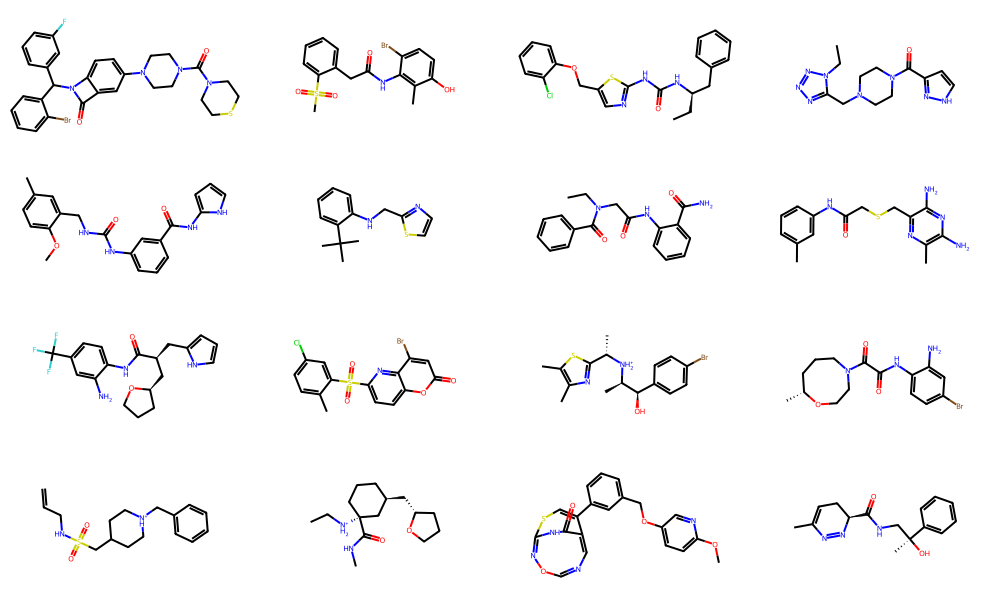

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 32, 11, 32, 32, 10, 32, 32, 32, 5, 5, 21, 11, 6, 21, 5, 18, 26, 6, 5, 18, 26, 6, 21, 5, 21, 18, 6, 5, 21, 6, 21, 5, 32, 10, 10, 32, 32, 32, 32, 22, 5, 11, 2, 21, 21, 26, 26, 11, 21, 2, 26, 26, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(Cc2cc1ccc((C2)C(=O)(=O)C(C=)(C)C(c11ccccF(2
mol is none, cannot recon


 34%|███▎      | 115/342 [00:47<01:32,  2.44it/s]

Epoch 7: 114/342 | ['loss=0.05656', '(kl=1.68187', 'recon=0.03302)', 'klw=0.01400 lr=0.00056']


 67%|██████▋   | 229/342 [01:33<00:46,  2.45it/s]

Epoch 7: 228/342 | ['loss=0.11224', '(kl=3.32945', 'recon=0.06562)', 'klw=0.01400 lr=0.00056']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 383.81it/s]


valid 81.033%  |  unique 81.033%


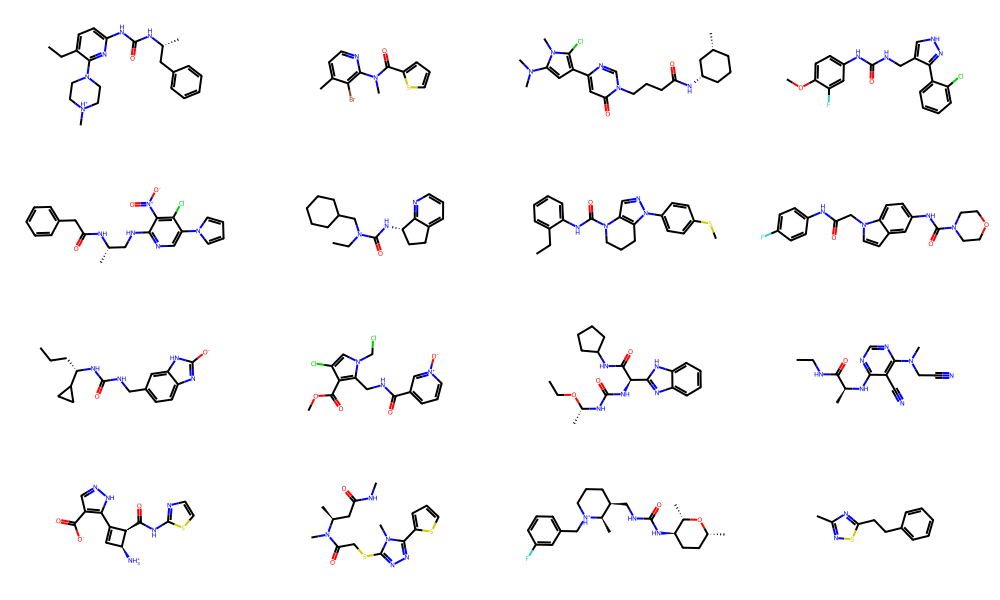

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 11, 8, 32, 11, 8, 10, 10, 32, 32, 32, 5, 5, 21, 11, 21, 21, 5, 18, 26, 6, 5, 18, 26, 6, 21, 10, 10, 21, 6, 5, 21, 6, 21, 5, 21, 10, 10, 32, 32, 32, 5, 21, 11, 11, 21, 21, 21, 21, 21, 11, 21, 2, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc2-c2-11ccc((C2CC(=O)(=O)C11C)(C)C(C11ccc(C22CCCCC2C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:33,  2.42it/s]

Epoch 8: 114/342 | ['loss=0.05843', '(kl=1.54678', 'recon=0.03369)', 'klw=0.01600 lr=0.00037']


 67%|██████▋   | 229/342 [01:33<00:44,  2.51it/s]

Epoch 8: 228/342 | ['loss=0.11611', '(kl=3.04944', 'recon=0.06731)', 'klw=0.01600 lr=0.00037']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 386.03it/s]


valid 81.533%  |  unique 81.533%


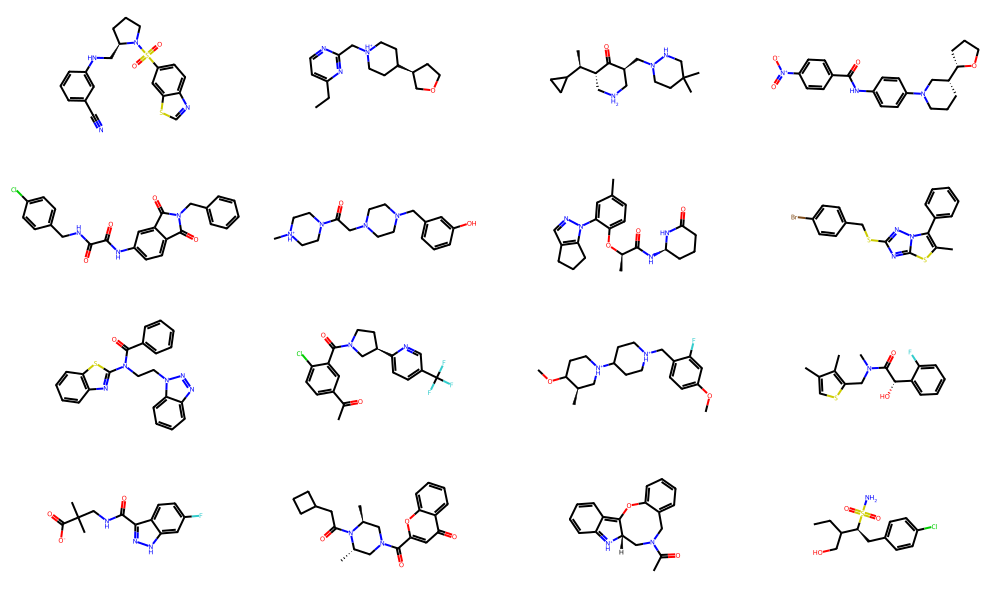

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 11, 8, 32, 11, 32, 10, 10, 32, 32, 32, 5, 5, 9, 11, 21, 21, 5, 18, 26, 6, 5, 18, 26, 6, 21, 10, 21, 18, 6, 5, 21, 6, 21, 5, 32, 10, 10, 32, 32, 32, 32, 21, 11, 11, 21, 21, 21, 21, 26, 11, 21, 2, 26, 26, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc2-c2c11ccc((/2CC(=O)(=O)C1C=)(C)C(c11ccccC22CCCCO2C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:30,  2.50it/s]

Epoch 9: 114/342 | ['loss=0.06048', '(kl=1.39848', 'recon=0.03531)', 'klw=0.01800 lr=0.00030']


 67%|██████▋   | 229/342 [01:33<00:46,  2.45it/s]

Epoch 9: 228/342 | ['loss=0.12014', '(kl=2.74490', 'recon=0.07073)', 'klw=0.01800 lr=0.00030']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 382.66it/s]


valid 84.400%  |  unique 84.400%


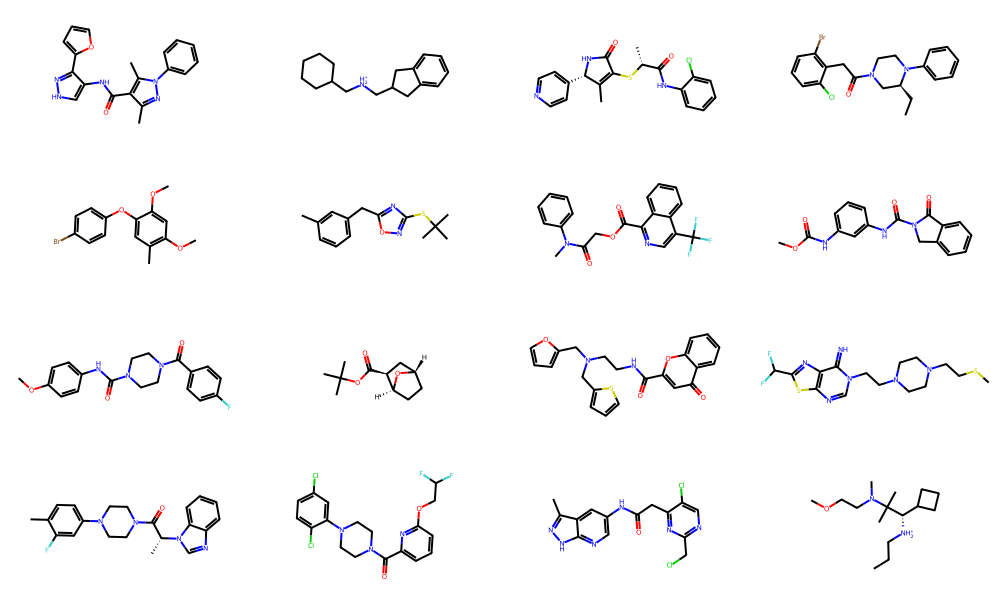

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 8, 32, 11, 32, 9, 10, 32, 32, 32, 5, 5, 9, 11, 6, 9, 5, 18, 26, 6, 5, 18, 26, 6, 21, 10, 10, 18, 6, 5, 21, 6, 21, 5, 32, 10, 10, 32, 32, 32, 32, 21, 5, 11, 21, 21, 21, 21, 26, 11, 21, 2, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(-c2c/1ccc((/2)/(=O)(=O)C11=)(C)C(c11ccccC(2CCCCO2C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.47it/s]

Epoch 10: 114/342 | ['loss=0.07668', '(kl=0.63123', 'recon=0.06405)', 'klw=0.02000 lr=0.00293']


 67%|██████▋   | 229/342 [01:33<00:46,  2.45it/s]

Epoch 10: 228/342 | ['loss=0.14555', '(kl=1.19689', 'recon=0.12161)', 'klw=0.02000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 386.12it/s]


valid 75.233%  |  unique 75.233%


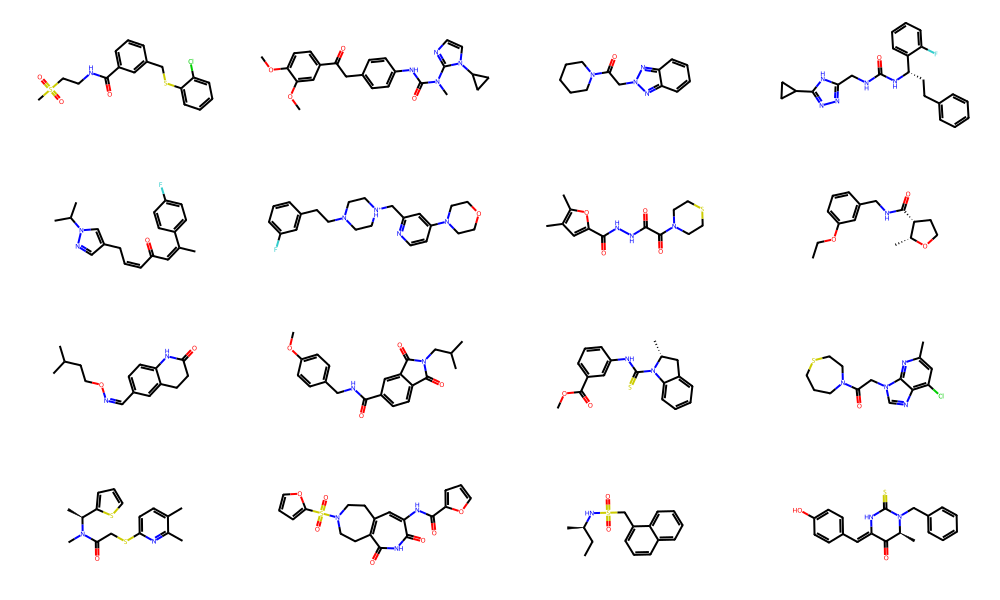

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 11, 11, 8, 21, 10, 32, 32, 32, 5, 5, 21, 11, 6, 21, 5, 18, 26, 6, 5, 18, 26, 6, 32, 10, 5, 18, 6, 5, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 11, 11, 21, 32, 21, 26, 26, 10, 21, 5, 26, 5, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(C22-C1ccc((C2)C(=O)(=O)c1(=)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.49it/s]

Epoch 11: 114/342 | ['loss=0.06899', '(kl=0.42633', 'recon=0.05962)', 'klw=0.02200 lr=0.00274']


 67%|██████▋   | 229/342 [01:33<00:46,  2.44it/s]

Epoch 11: 228/342 | ['loss=0.13642', '(kl=0.76685', 'recon=0.11955)', 'klw=0.02200 lr=0.00274']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 381.66it/s]


valid 78.733%  |  unique 78.733%


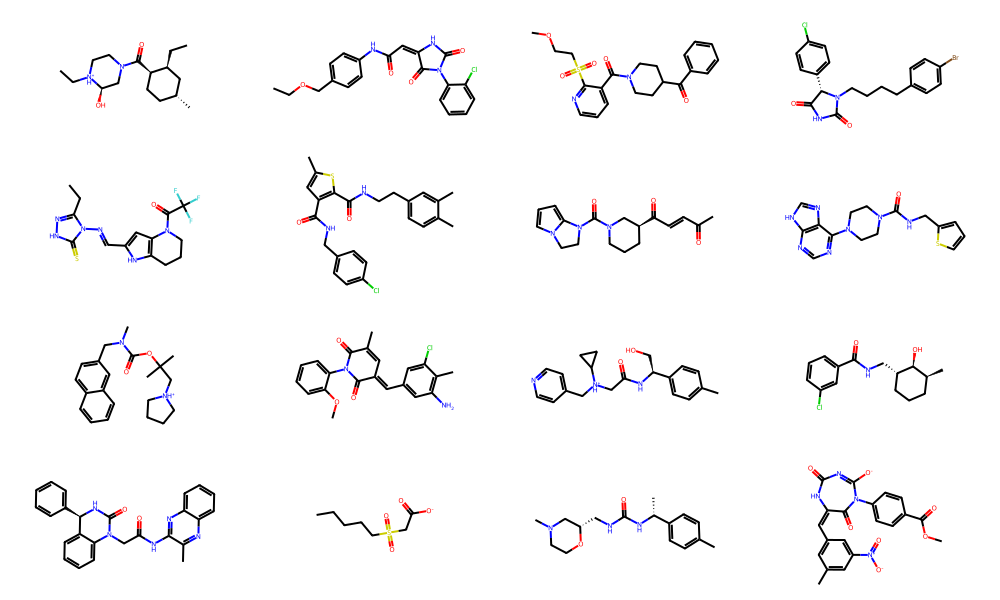

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 34, 32, 32, 5, 8, 34, 11, 8, 10, 10, 32, 32, 32, 32, 32, 21, 11, 6, 29, 21, 18, 26, 6, 5, 18, 26, 6, 32, 10, 21, 18, 6, 5, 21, 6, 21, 29, 34, 10, 10, 32, 32, 32, 32, 21, 32, 11, 21, 21, 21, 21, 26, 10, 21, 21, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ncc(-n2-11cccccC2)[C=O)(=O)c1C=)(C)C[n11ccccCc2CCCCO1CCOC1=C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.47it/s]

Epoch 12: 114/342 | ['loss=0.06725', '(kl=0.19837', 'recon=0.06248)', 'klw=0.02400 lr=0.00244']


 67%|██████▋   | 229/342 [01:33<00:46,  2.45it/s]

Epoch 12: 228/342 | ['loss=0.13318', '(kl=0.33262', 'recon=0.12520)', 'klw=0.02400 lr=0.00244']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 382.36it/s]


valid 83.167%  |  unique 83.167%


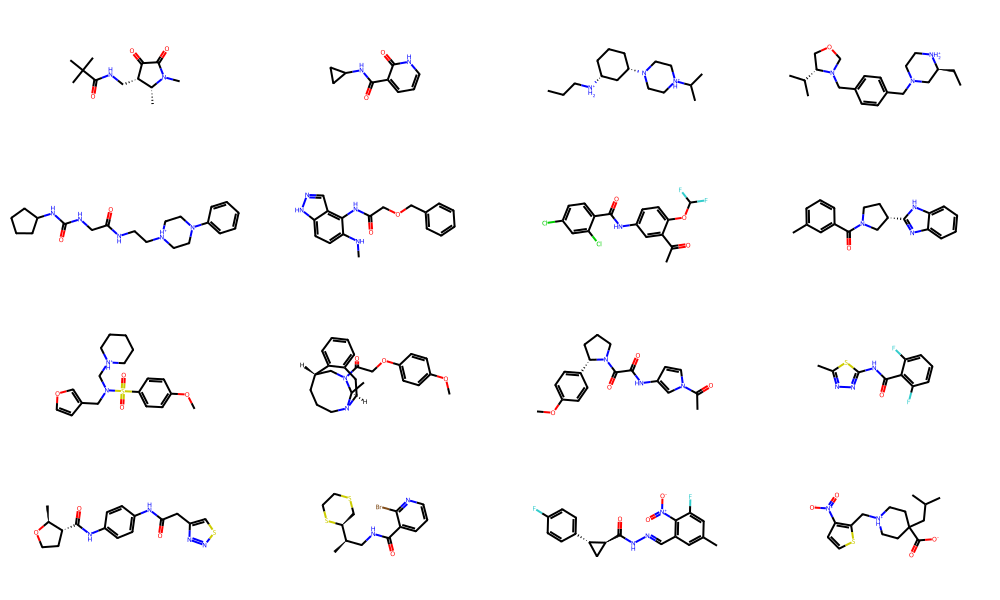

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 26, 10, 32, 32, 32, 5, 21, 32, 11, 32, 21, 10, 32, 32, 32, 5, 5, 21, 11, 6, 29, 21, 18, 26, 6, 5, 18, 26, 6, 32, 10, 32, 21, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 32, 11, 2, 32, 21, 21, 26, 10, 21, 21, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CO1ccc(Cc2cC1ccc((C2)[C=O)(=O)c1cC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.48it/s]

Epoch 13: 114/342 | ['loss=0.06539', '(kl=0.05880', 'recon=0.06386)', 'klw=0.02600 lr=0.00207']


 67%|██████▋   | 229/342 [01:33<00:47,  2.38it/s]

Epoch 13: 228/342 | ['loss=0.12959', '(kl=0.09324', 'recon=0.12717)', 'klw=0.02600 lr=0.00207']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 377.30it/s]


valid 85.200%  |  unique 85.200%


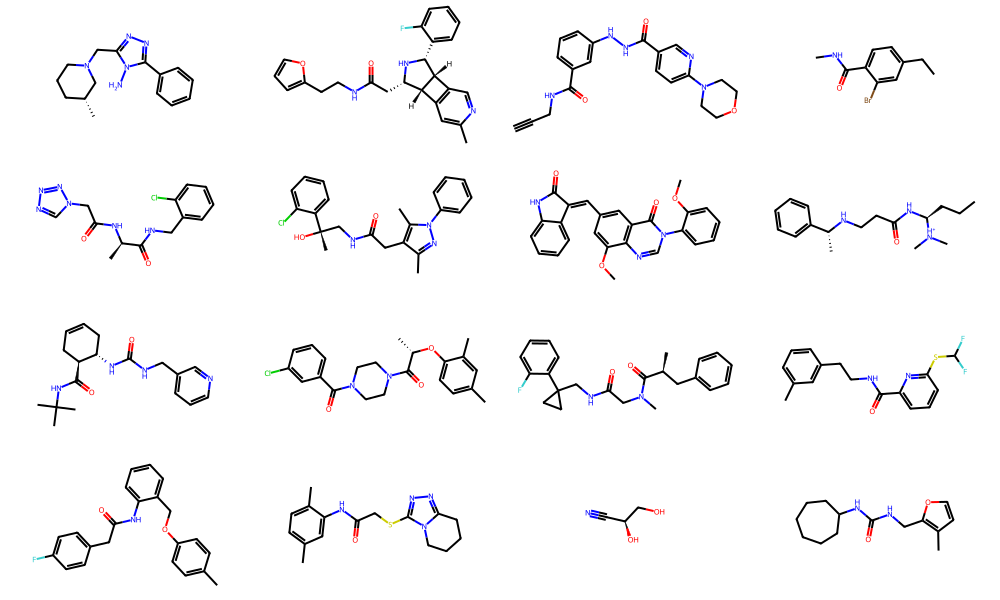

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 32, 11, 21, 21, 10, 34, 32, 32, 5, 5, 21, 11, 6, 29, 21, 18, 26, 6, 5, 18, 26, 6, 32, 5, 21, 21, 6, 5, 21, 6, 21, 2, 34, 10, 10, 32, 32, 32, 32, 21, 5, 11, 21, 32, 21, 21, 26, 10, 21, 21, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cc2CC1ncc((C2)[C=O)(=O)c(CC)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:33,  2.44it/s]

Epoch 14: 114/342 | ['loss=0.06355', '(kl=0.01450', 'recon=0.06314)', 'klw=0.02800 lr=0.00165']


 67%|██████▋   | 229/342 [01:33<00:46,  2.44it/s]

Epoch 14: 228/342 | ['loss=0.12605', '(kl=0.02450', 'recon=0.12536)', 'klw=0.02800 lr=0.00165']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 380.86it/s]


valid 85.467%  |  unique 85.467%


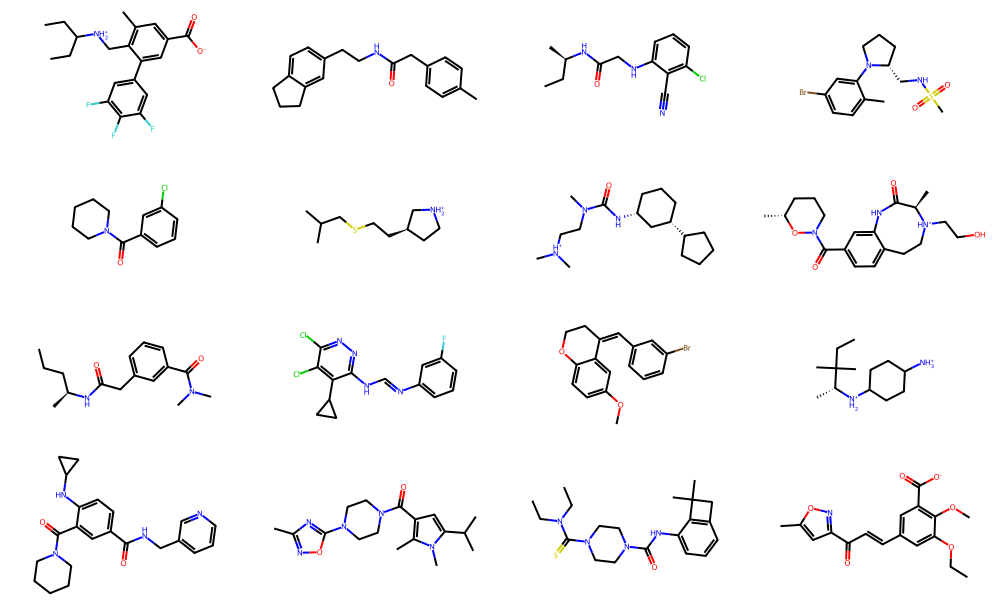

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 11, 11, 32, 21, 10, 32, 32, 32, 5, 5, 21, 11, 21, 29, 5, 18, 26, 6, 5, 18, 26, 6, 32, 10, 5, 21, 6, 5, 21, 6, 21, 2, 29, 10, 10, 32, 32, 32, 32, 22, 5, 11, 21, 32, 21, 21, 26, 10, 21, 2, 26, 4, 5, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(C22cC1ccc((C2C[(=O)(=O)c1(C)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:32,  2.45it/s]

Epoch 15: 114/342 | ['loss=0.06208', '(kl=0.00609', 'recon=0.06189)', 'klw=0.03000 lr=0.00123']


 67%|██████▋   | 229/342 [01:33<00:46,  2.44it/s]

Epoch 15: 228/342 | ['loss=0.12321', '(kl=0.01067', 'recon=0.12289)', 'klw=0.03000 lr=0.00123']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 377.94it/s]


valid 87.100%  |  unique 87.100%


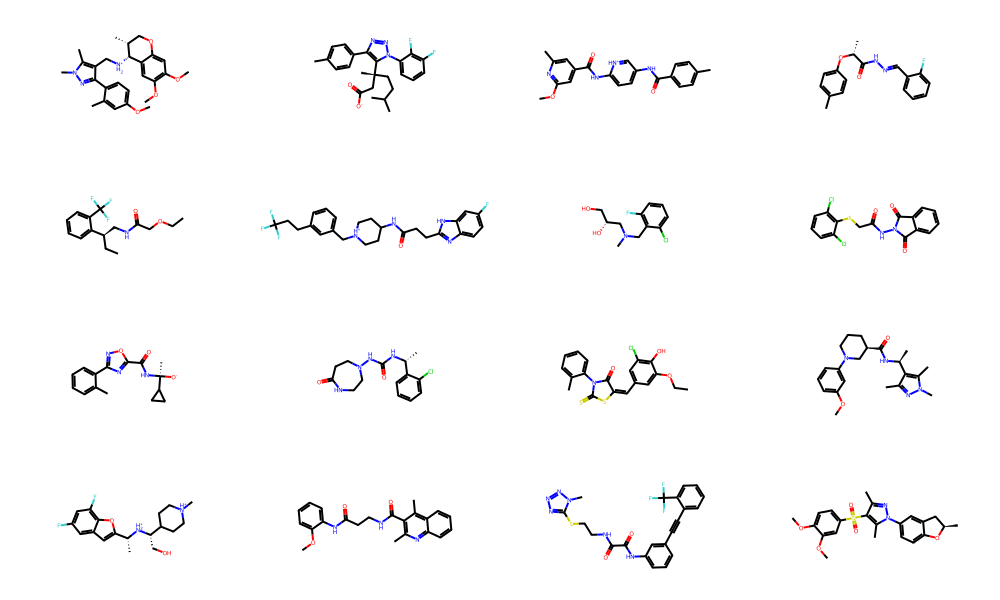

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 34, 11, 8, 21, 10, 32, 32, 32, 5, 5, 21, 11, 21, 29, 5, 18, 26, 6, 5, 18, 26, 6, 32, 5, 32, 21, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 21, 32, 11, 21, 32, 21, 21, 26, 5, 21, 2, 26, 21, 26, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(Cn2-C1ccc((C2C[(=O)(=O)c(cC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:32,  2.47it/s]

Epoch 16: 114/342 | ['loss=0.06072', '(kl=0.00325', 'recon=0.06061)', 'klw=0.03200 lr=0.00086']


 67%|██████▋   | 229/342 [01:33<00:46,  2.42it/s]

Epoch 16: 228/342 | ['loss=0.12050', '(kl=0.00592', 'recon=0.12031)', 'klw=0.03200 lr=0.00086']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 378.58it/s]


valid 88.600%  |  unique 88.600%


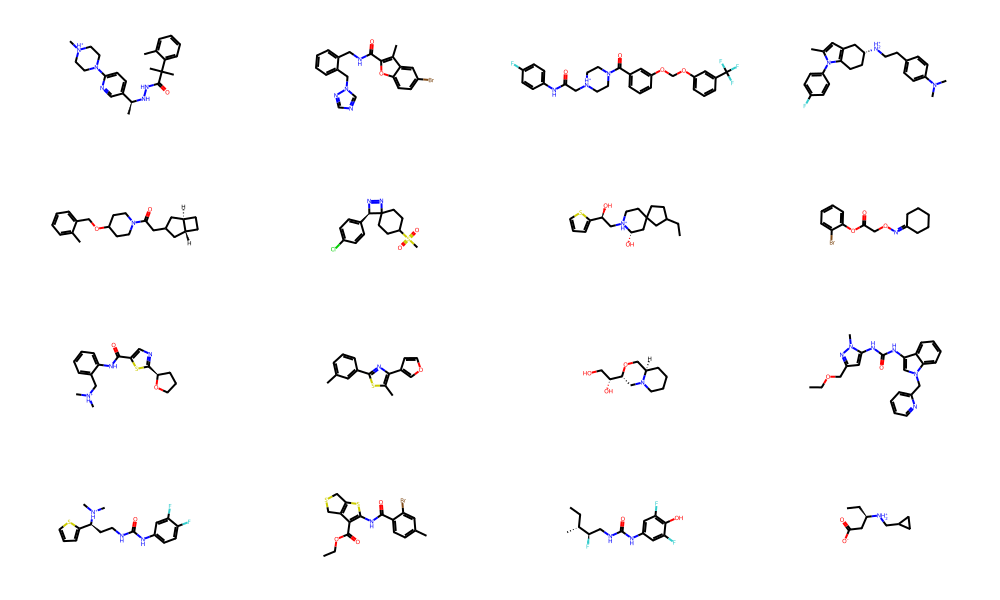

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 34, 11, 8, 21, 10, 32, 32, 32, 5, 5, 21, 11, 21, 29, 5, 18, 26, 6, 5, 18, 26, 6, 32, 5, 21, 18, 6, 5, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 11, 11, 2, 21, 21, 21, 26, 10, 21, 2, 26, 26, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cn2-C1ccc((C2C[(=O)(=O)c(C=)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:47<01:33,  2.42it/s]

Epoch 17: 114/342 | ['loss=0.05937', '(kl=0.00208', 'recon=0.05930)', 'klw=0.03400 lr=0.00056']


 67%|██████▋   | 229/342 [01:33<00:45,  2.47it/s]

Epoch 17: 228/342 | ['loss=0.11795', '(kl=0.00385', 'recon=0.11782)', 'klw=0.03400 lr=0.00056']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 378.91it/s]


valid 89.200%  |  unique 89.167%


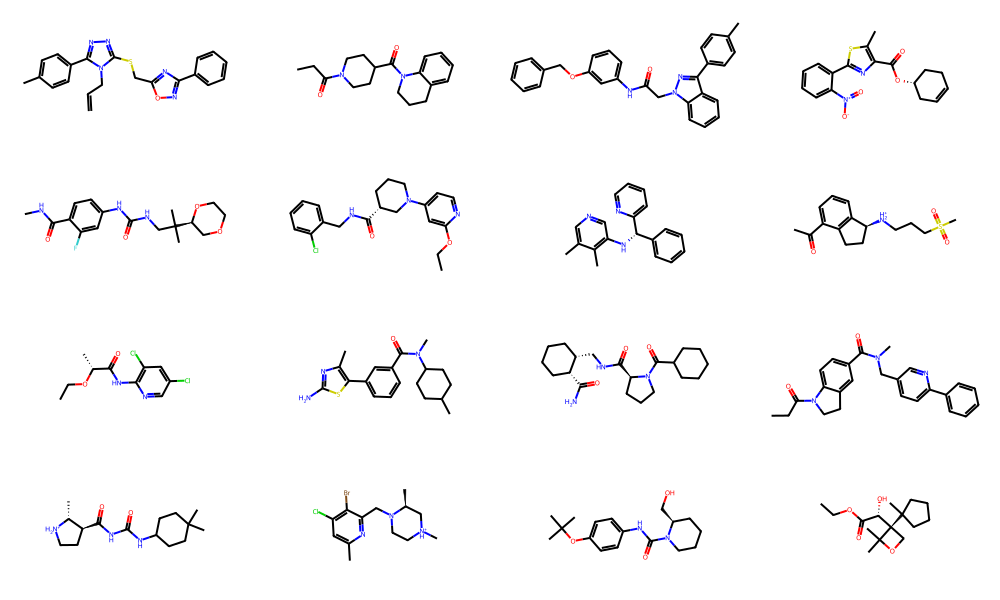

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 32, 11, 8, 21, 10, 32, 32, 32, 5, 5, 21, 11, 21, 34, 5, 18, 26, 6, 5, 18, 26, 6, 32, 5, 21, 18, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 32, 11, 21, 26, 21, 21, 26, 11, 21, 2, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cc2-C1ccc((C2Cn(=O)(=O)c(C=)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.47it/s]

Epoch 18: 114/342 | ['loss=0.05832', '(kl=0.00144', 'recon=0.05827)', 'klw=0.03600 lr=0.00037']


 67%|██████▋   | 229/342 [01:33<00:45,  2.46it/s]

Epoch 18: 228/342 | ['loss=0.11624', '(kl=0.00271', 'recon=0.11614)', 'klw=0.03600 lr=0.00037']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 379.83it/s]


valid 90.467%  |  unique 90.467%


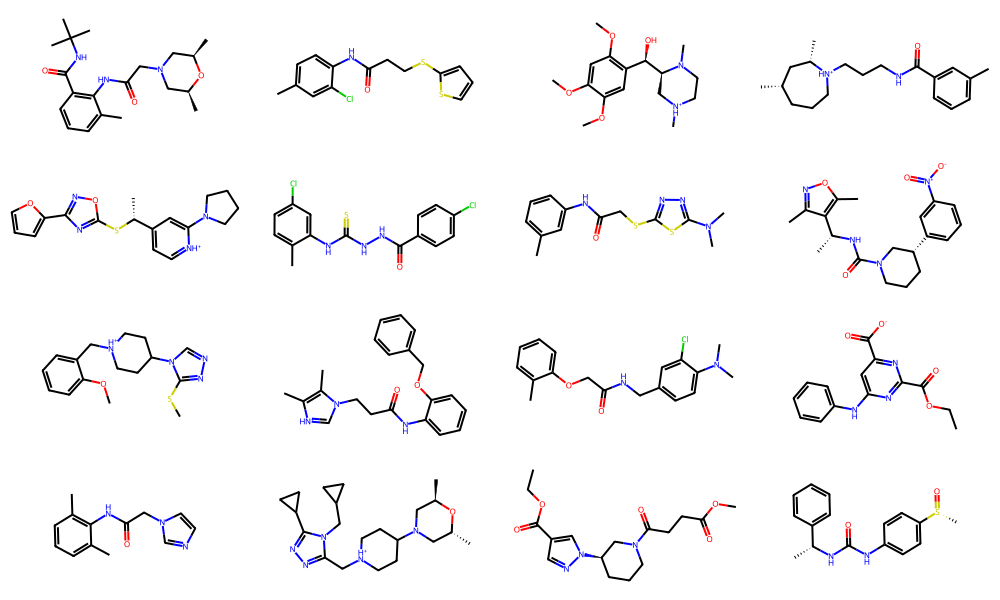

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 32, 11, 8, 21, 10, 32, 32, 32, 5, 5, 21, 11, 21, 29, 5, 18, 26, 6, 5, 18, 26, 6, 32, 5, 5, 18, 6, 5, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 32, 10, 21, 26, 21, 11, 26, 11, 21, 2, 26, 26, 26, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cc2-C1ccc((C2C[(=O)(=O)c((=)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.48it/s]

Epoch 19: 114/342 | ['loss=0.05770', '(kl=0.00107', 'recon=0.05766)', 'klw=0.03800 lr=0.00030']


 67%|██████▋   | 229/342 [01:33<00:45,  2.46it/s]

Epoch 19: 228/342 | ['loss=0.11504', '(kl=0.00202', 'recon=0.11496)', 'klw=0.03800 lr=0.00030']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 377.95it/s]


valid 91.867%  |  unique 91.867%


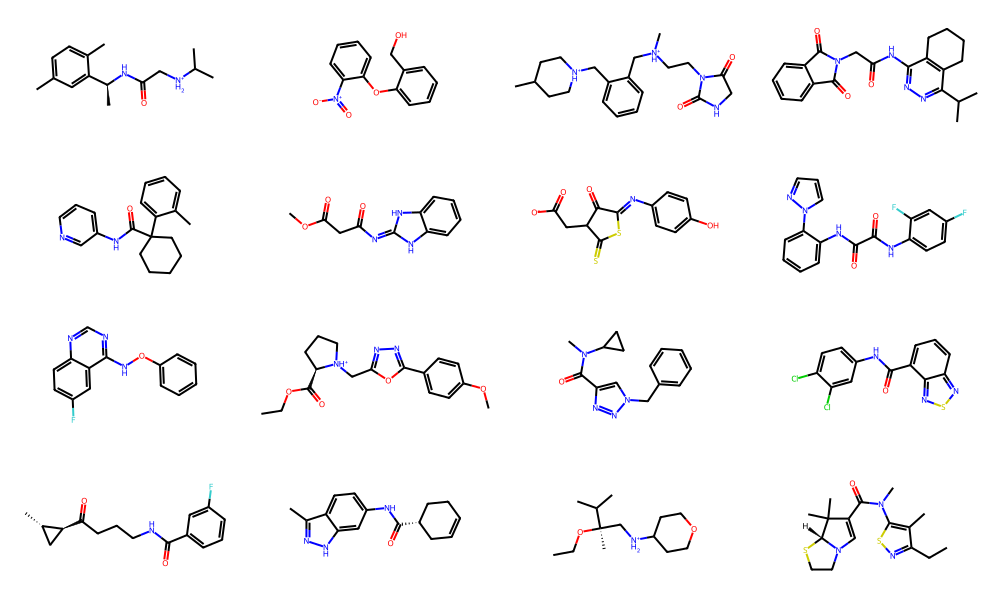

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 34, 11, 8, 21, 10, 32, 32, 32, 5, 5, 21, 11, 6, 21, 5, 18, 26, 6, 5, 18, 26, 6, 21, 5, 5, 18, 6, 5, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 32, 11, 2, 21, 21, 21, 26, 11, 21, 2, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cn2-C1ccc((C2)C(=O)(=O)C((=)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:33,  2.44it/s]

Epoch 20: 114/342 | ['loss=0.06509', '(kl=0.01485', 'recon=0.06449)', 'klw=0.04000 lr=0.00293']


 67%|██████▋   | 229/342 [01:33<00:46,  2.43it/s]

Epoch 20: 228/342 | ['loss=0.13028', '(kl=0.01701', 'recon=0.12960)', 'klw=0.04000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 378.00it/s]


valid 83.700%  |  unique 83.700%


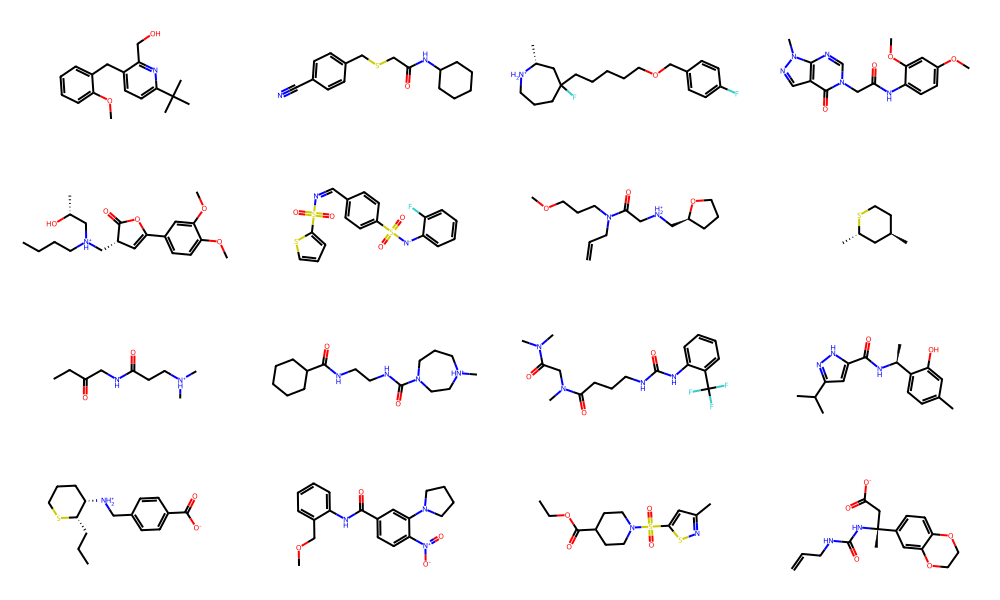

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 11, 11, 32, 21, 10, 32, 32, 32, 5, 5, 21, 11, 6, 21, 21, 18, 26, 6, 5, 18, 26, 6, 32, 21, 21, 18, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 32, 11, 2, 32, 21, 21, 26, 10, 21, 21, 26, 21, 21, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(C22cC1ccc((C2)CC=O)(=O)cCC=)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.48it/s]

Epoch 21: 114/342 | ['loss=0.06645', '(kl=0.00189', 'recon=0.06637)', 'klw=0.04200 lr=0.00274']


 67%|██████▋   | 229/342 [01:33<00:45,  2.47it/s]

Epoch 21: 228/342 | ['loss=0.13127', '(kl=0.00337', 'recon=0.13113)', 'klw=0.04200 lr=0.00274']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 377.74it/s]


valid 76.433%  |  unique 76.433%


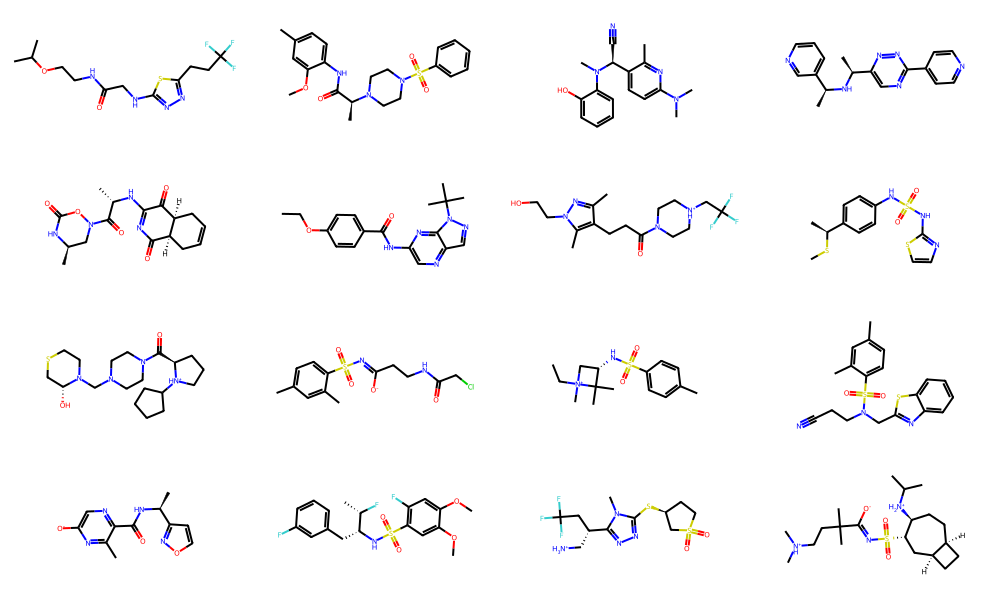

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 11, 11, 25, 21, 10, 34, 32, 32, 5, 5, 21, 11, 6, 25, 5, 18, 26, 6, 5, 18, 26, 6, 32, 5, 21, 18, 6, 5, 21, 6, 21, 2, 32, 5, 10, 32, 32, 32, 32, 22, 5, 11, 2, 32, 21, 21, 26, 5, 21, 5, 26, 5, 10, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(C22NC1ncc((C2)N(=O)(=O)c(C=)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:32,  2.46it/s]

Epoch 22: 114/342 | ['loss=0.06496', '(kl=0.00123', 'recon=0.06490)', 'klw=0.04400 lr=0.00244']


 67%|██████▋   | 229/342 [01:32<00:45,  2.49it/s]

Epoch 22: 228/342 | ['loss=0.12876', '(kl=0.00224', 'recon=0.12866)', 'klw=0.04400 lr=0.00244']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 383.23it/s]


valid 84.567%  |  unique 84.567%


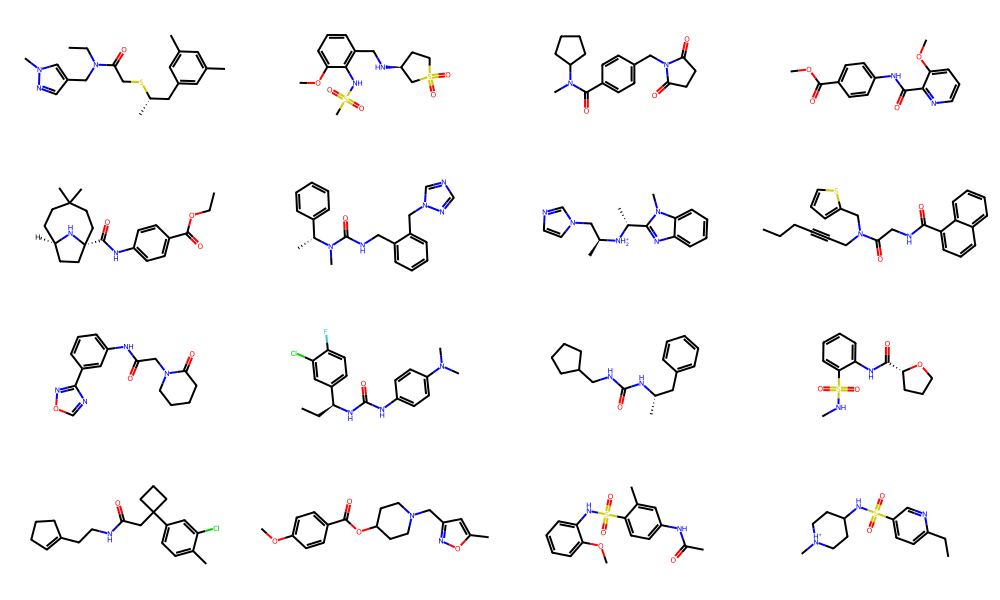

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 32, 11, 21, 21, 10, 32, 32, 32, 32, 5, 21, 11, 6, 21, 5, 18, 26, 6, 5, 18, 26, 6, 21, 5, 21, 21, 6, 5, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 21, 5, 10, 2, 32, 21, 21, 26, 11, 21, 2, 21, 5, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cc2CC1cccc(C2)C(=O)(=O)C(CC)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:30,  2.51it/s]

Epoch 23: 114/342 | ['loss=0.06361', '(kl=0.00091', 'recon=0.06357)', 'klw=0.04600 lr=0.00207']


 67%|██████▋   | 229/342 [01:32<00:46,  2.43it/s]

Epoch 23: 228/342 | ['loss=0.12619', '(kl=0.00168', 'recon=0.12611)', 'klw=0.04600 lr=0.00207']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 382.90it/s]


valid 84.100%  |  unique 84.100%


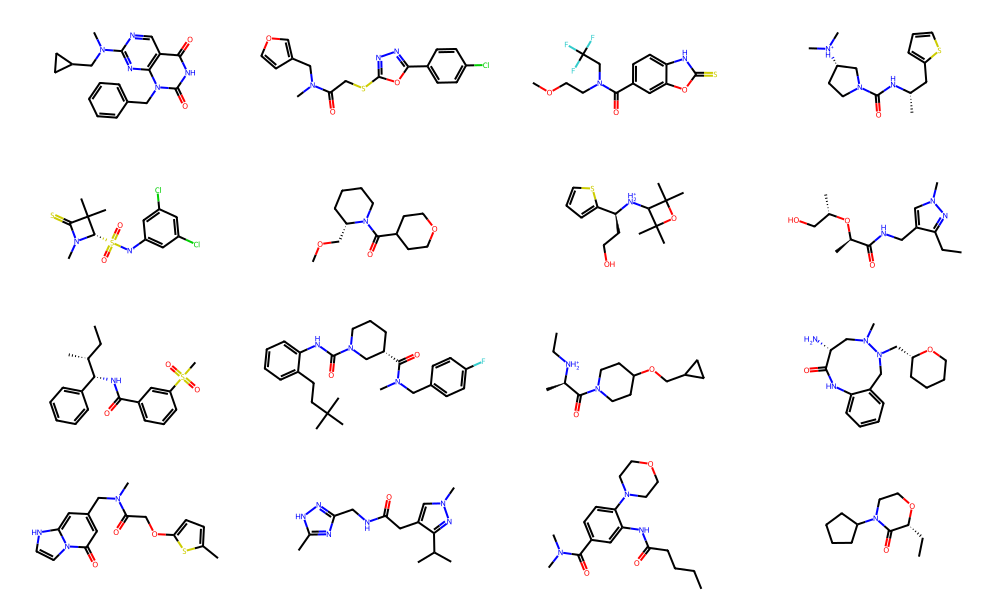

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 11, 11, 25, 21, 10, 32, 32, 32, 32, 32, 21, 11, 21, 29, 5, 18, 26, 6, 5, 18, 26, 6, 32, 10, 21, 21, 6, 5, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 21, 5, 11, 2, 32, 21, 21, 26, 5, 21, 2, 26, 26, 26, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(C22NC1cccccC2C[(=O)(=O)c1CC)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:30,  2.50it/s]

Epoch 24: 114/342 | ['loss=0.06248', '(kl=0.00066', 'recon=0.06245)', 'klw=0.04800 lr=0.00165']


 67%|██████▋   | 229/342 [01:32<00:45,  2.49it/s]

Epoch 24: 228/342 | ['loss=0.12400', '(kl=0.00122', 'recon=0.12395)', 'klw=0.04800 lr=0.00165']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 382.23it/s]


valid 84.533%  |  unique 84.533%


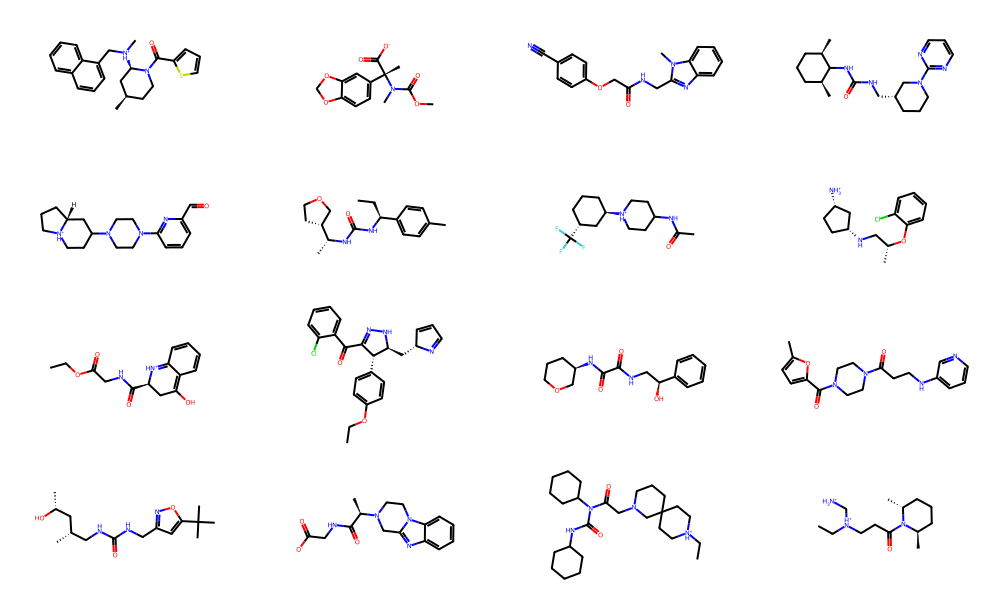

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 32, 11, 25, 21, 10, 32, 32, 32, 5, 5, 21, 11, 6, 21, 5, 18, 26, 6, 5, 18, 26, 6, 32, 5, 21, 21, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 21, 5, 11, 2, 21, 21, 21, 26, 5, 21, 2, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cc2NC1ccc((C2)C(=O)(=O)c(CC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:33,  2.43it/s]

Epoch 25: 114/342 | ['loss=0.06127', '(kl=0.00047', 'recon=0.06125)', 'klw=0.05000 lr=0.00123']


 67%|██████▋   | 229/342 [01:33<00:45,  2.49it/s]

Epoch 25: 228/342 | ['loss=0.12165', '(kl=0.00088', 'recon=0.12160)', 'klw=0.05000 lr=0.00123']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 382.87it/s]


valid 88.267%  |  unique 88.267%


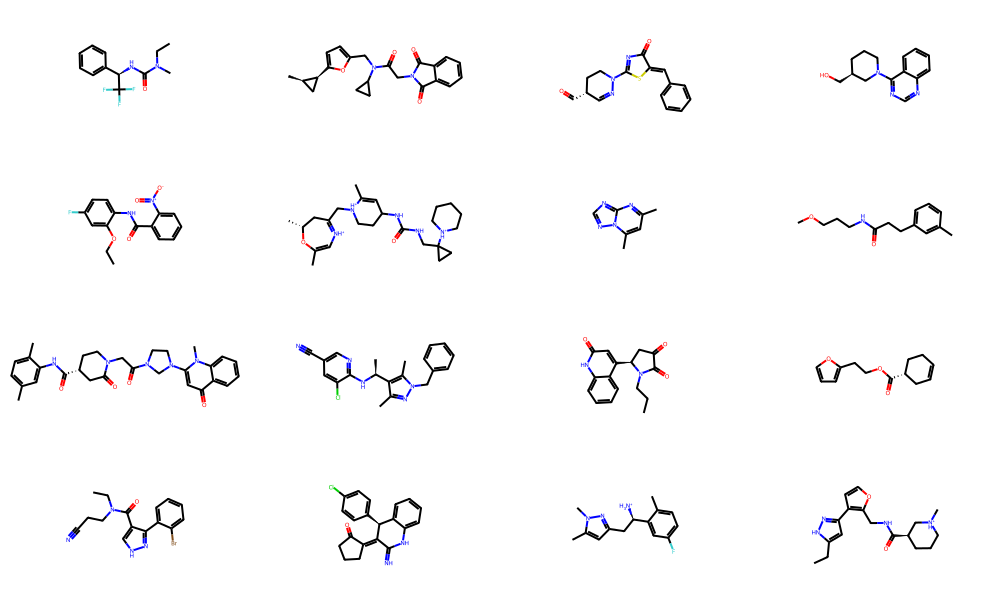

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 34, 11, 25, 21, 10, 32, 32, 32, 5, 32, 21, 11, 21, 21, 5, 18, 26, 6, 5, 18, 26, 6, 32, 10, 21, 21, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 5, 11, 2, 21, 21, 21, 26, 10, 21, 21, 26, 21, 10, 18, 2]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cn2NC1ccc(cC2CC(=O)(=O)c1CC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:32,  2.45it/s]

Epoch 26: 114/342 | ['loss=0.05995', '(kl=0.00032', 'recon=0.05993)', 'klw=0.05200 lr=0.00086']


 67%|██████▋   | 229/342 [01:32<00:46,  2.45it/s]

Epoch 26: 228/342 | ['loss=0.11919', '(kl=0.00060', 'recon=0.11916)', 'klw=0.05200 lr=0.00086']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 382.96it/s]


valid 90.367%  |  unique 90.367%


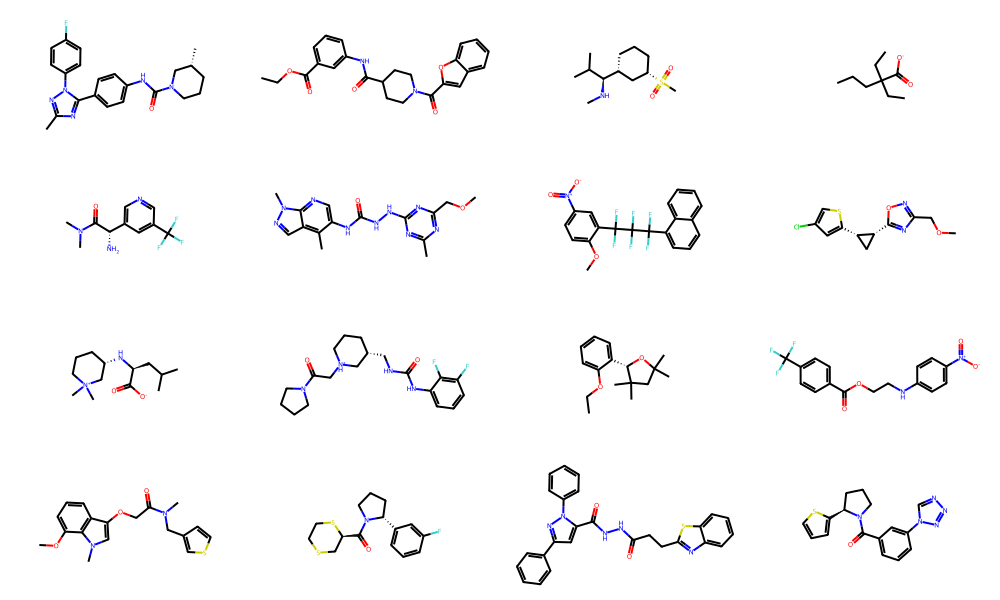

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 34, 11, 25, 21, 10, 32, 32, 32, 32, 5, 21, 11, 21, 21, 5, 18, 26, 6, 5, 18, 26, 6, 32, 10, 21, 21, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 5, 11, 2, 21, 21, 21, 5, 10, 21, 21, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cn2NC1cccc(C2CC(=O)(=O)c1CC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:34,  2.41it/s]

Epoch 27: 114/342 | ['loss=0.05901', '(kl=0.00026', 'recon=0.05899)', 'klw=0.05400 lr=0.00056']


 67%|██████▋   | 229/342 [01:32<00:45,  2.47it/s]

Epoch 27: 228/342 | ['loss=0.11741', '(kl=0.00049', 'recon=0.11738)', 'klw=0.05400 lr=0.00056']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 388.48it/s]


valid 90.400%  |  unique 90.400%


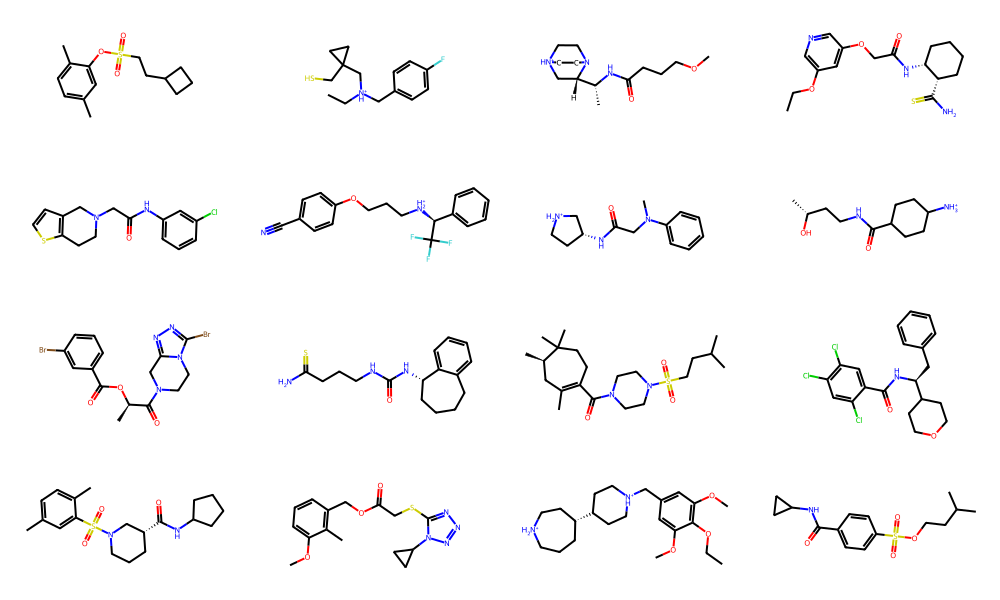

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 34, 11, 25, 21, 10, 32, 32, 32, 32, 5, 21, 11, 6, 29, 5, 18, 26, 6, 5, 18, 26, 6, 32, 5, 21, 21, 6, 21, 21, 6, 21, 2, 32, 21, 10, 32, 32, 32, 32, 21, 5, 11, 2, 21, 21, 21, 26, 5, 21, 2, 26, 21, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cn2NC1cccc(C2)[(=O)(=O)c(CC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.47it/s]

Epoch 28: 114/342 | ['loss=0.05817', '(kl=0.00019', 'recon=0.05816)', 'klw=0.05600 lr=0.00037']


 67%|██████▋   | 229/342 [01:32<00:45,  2.47it/s]

Epoch 28: 228/342 | ['loss=0.11580', '(kl=0.00037', 'recon=0.11578)', 'klw=0.05600 lr=0.00037']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 389.34it/s]


valid 90.433%  |  unique 90.433%


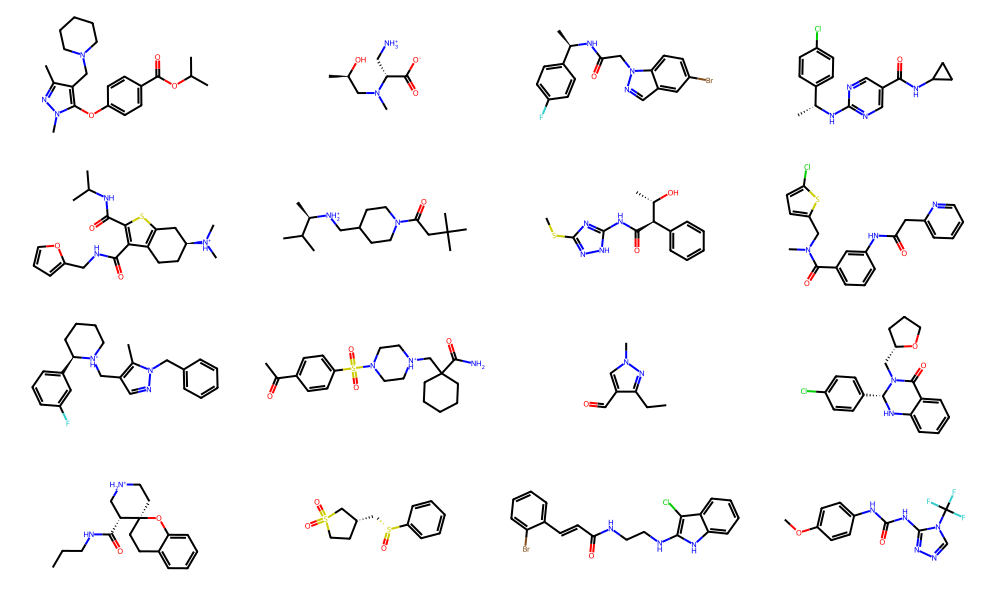

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 34, 11, 25, 21, 10, 32, 32, 32, 5, 5, 21, 11, 21, 21, 5, 18, 26, 6, 5, 18, 26, 6, 32, 10, 21, 21, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 5, 11, 2, 32, 21, 21, 26, 10, 21, 21, 26, 21, 10, 18, 2]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cn2NC1ccc((C2CC(=O)(=O)c1CC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.47it/s]

Epoch 29: 114/342 | ['loss=0.05768', '(kl=0.00016', 'recon=0.05767)', 'klw=0.05800 lr=0.00030']


 67%|██████▋   | 229/342 [01:32<00:45,  2.49it/s]

Epoch 29: 228/342 | ['loss=0.11490', '(kl=0.00031', 'recon=0.11489)', 'klw=0.05800 lr=0.00030']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 388.28it/s]


valid 90.600%  |  unique 90.600%


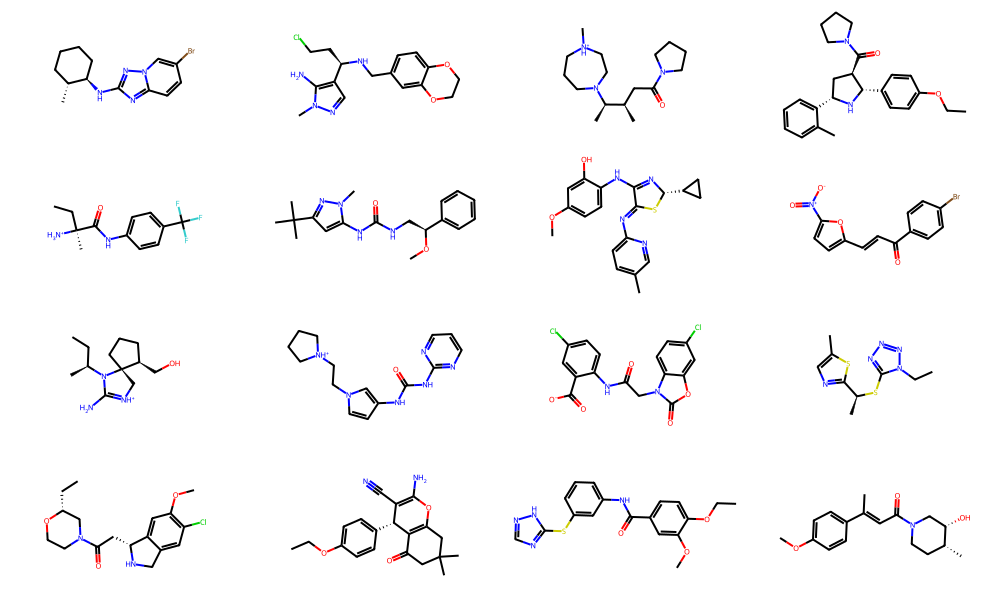

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 34, 11, 25, 21, 10, 32, 32, 32, 32, 5, 21, 11, 21, 21, 5, 18, 26, 6, 5, 18, 26, 6, 32, 10, 21, 21, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 22, 5, 11, 2, 32, 21, 21, 26, 10, 21, 21, 26, 21, 10, 18, 2]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cn2NC1cccc(C2CC(=O)(=O)c1CC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:32,  2.47it/s]

Epoch 30: 114/342 | ['loss=0.06347', '(kl=0.00126', 'recon=0.06340)', 'klw=0.06000 lr=0.00293']


 67%|██████▋   | 229/342 [01:32<00:45,  2.49it/s]

Epoch 30: 228/342 | ['loss=0.12852', '(kl=0.00254', 'recon=0.12837)', 'klw=0.06000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 388.39it/s]


valid 76.500%  |  unique 76.500%


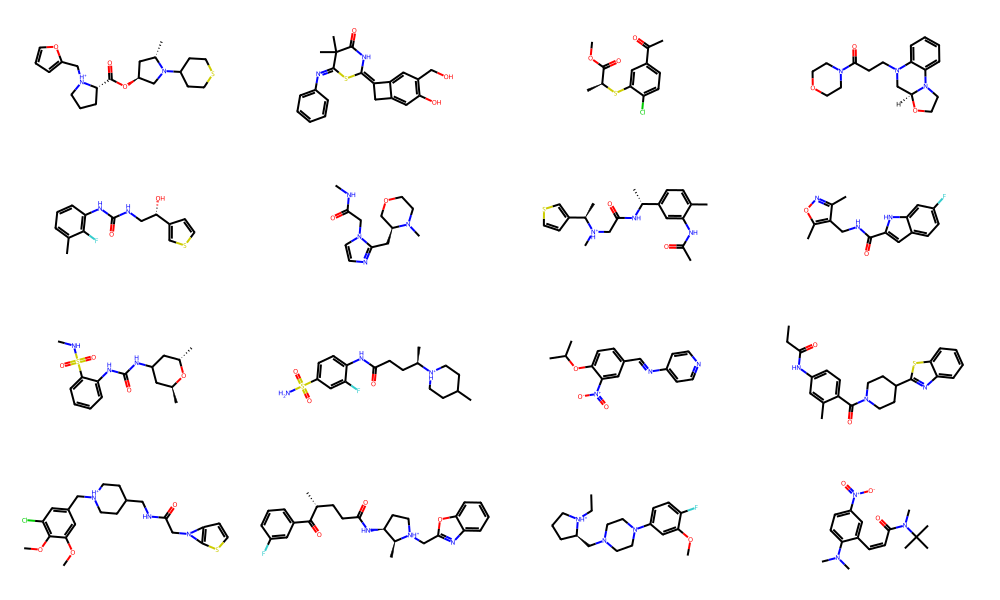

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 11, 11, 25, 21, 10, 32, 32, 32, 5, 5, 21, 11, 6, 21, 5, 18, 26, 6, 5, 18, 26, 6, 21, 5, 21, 18, 6, 5, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 21, 5, 11, 2, 32, 21, 21, 26, 10, 21, 2, 5, 4, 10, 18, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(C22NC1ccc((C2)C(=O)(=O)C(C=)(C)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:31,  2.48it/s]

Epoch 31: 114/342 | ['loss=0.06767', '(kl=0.00350', 'recon=0.06745)', 'klw=0.06200 lr=0.00274']


 67%|██████▋   | 229/342 [01:32<00:47,  2.39it/s]

Epoch 31: 228/342 | ['loss=0.13511', '(kl=0.01158', 'recon=0.13439)', 'klw=0.06200 lr=0.00274']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 385.03it/s]


valid 68.133%  |  unique 68.100%


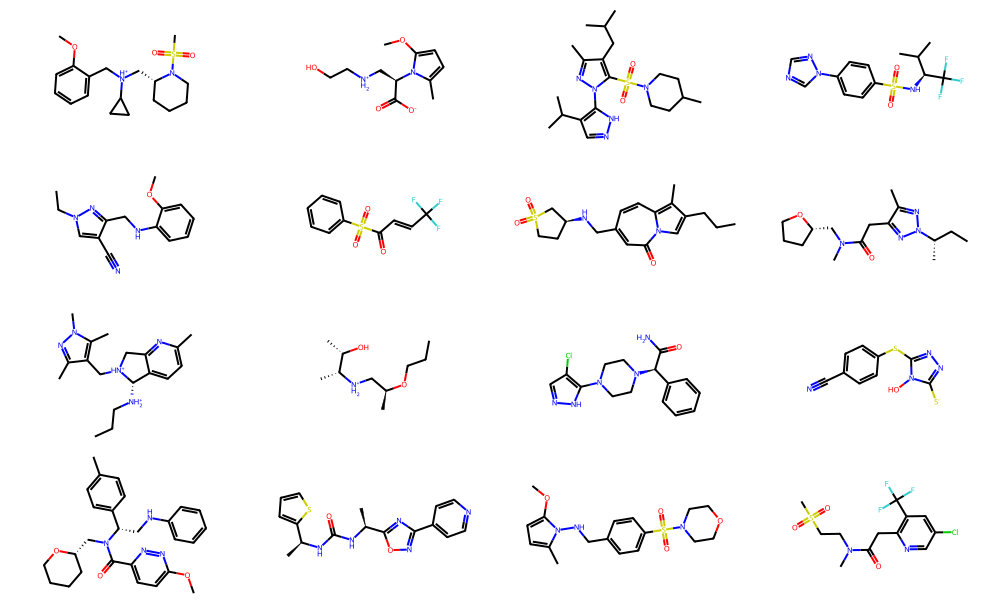

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 34, 11, 34, 21, 11, 34, 32, 32, 5, 5, 21, 11, 6, 34, 21, 18, 26, 6, 5, 18, 26, 6, 32, 21, 21, 21, 6, 21, 21, 6, 21, 2, 32, 10, 10, 32, 32, 32, 32, 21, 5, 11, 2, 34, 21, 21, 26, 10, 21, 2, 26, 5, 10, 21, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cn2nC2ncc((C2)nC=O)(=O)cCCC)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:46<01:29,  2.53it/s]

Epoch 32: 114/342 | ['loss=0.07030', '(kl=0.02473', 'recon=0.06872)', 'klw=0.06400 lr=0.00244']


 67%|██████▋   | 229/342 [01:32<00:44,  2.54it/s]

Epoch 32: 228/342 | ['loss=0.14007', '(kl=0.05433', 'recon=0.13659)', 'klw=0.06400 lr=0.00244']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 386.16it/s]


valid 50.167%  |  unique 50.167%


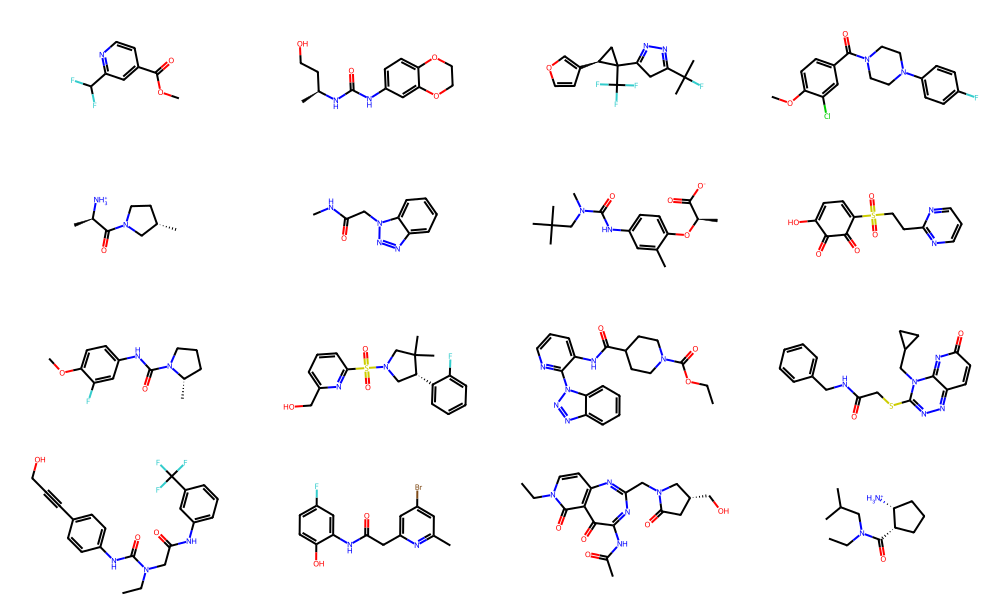

save model ckpt.pt
true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 18, 10, 32, 32, 11, 11, 21, 11, 11, 21, 21, 10, 34, 32, 32, 32, 32, 21, 11, 21, 21, 21, 18, 26, 6, 5, 18, 26, 6, 32, 5, 32, 18, 6, 21, 21, 6, 21, 2, 21, 21, 10, 32, 32, 32, 32, 21, 11, 11, 2, 32, 21, 21, 21, 11, 2, 2, 2, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: C=1cc22C22CC1nccccC2CCC=O)(=O)c(c=)CC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.56it/s]

Epoch 33: 114/342 | ['loss=2658.33228', '(kl=40091.16658', 'recon=12.31526)', 'klw=0.06600 lr=0.00207']


 67%|██████▋   | 229/342 [01:29<00:43,  2.59it/s]

Epoch 33: 228/342 | ['loss=2661.08644', '(kl=40117.77732', 'recon=13.31311)', 'klw=0.06600 lr=0.00207']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 382.49it/s]

valid 1.900%  |  unique 0.767%


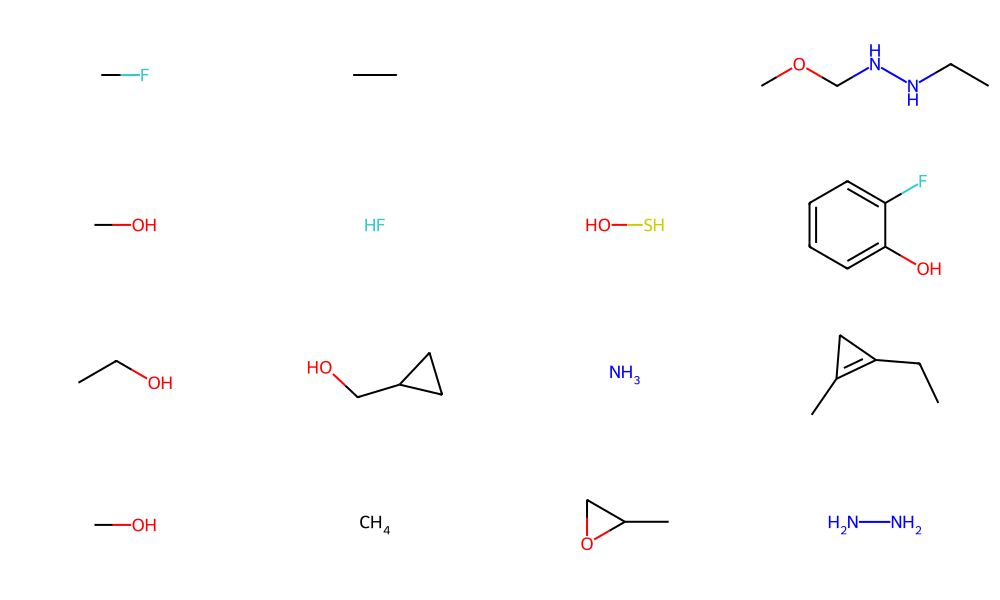

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CCccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:45<01:29,  2.55it/s]

Epoch 34: 114/342 | ['loss=17.05665', '(kl=237.72130', 'recon=0.89161)', 'klw=0.06800 lr=0.00165']


 67%|██████▋   | 229/342 [01:30<00:44,  2.56it/s]

Epoch 34: 228/342 | ['loss=17.92433', '(kl=245.48023', 'recon=1.23167)', 'klw=0.06800 lr=0.00165']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 381.19it/s]

valid 3.567%  |  unique 0.833%


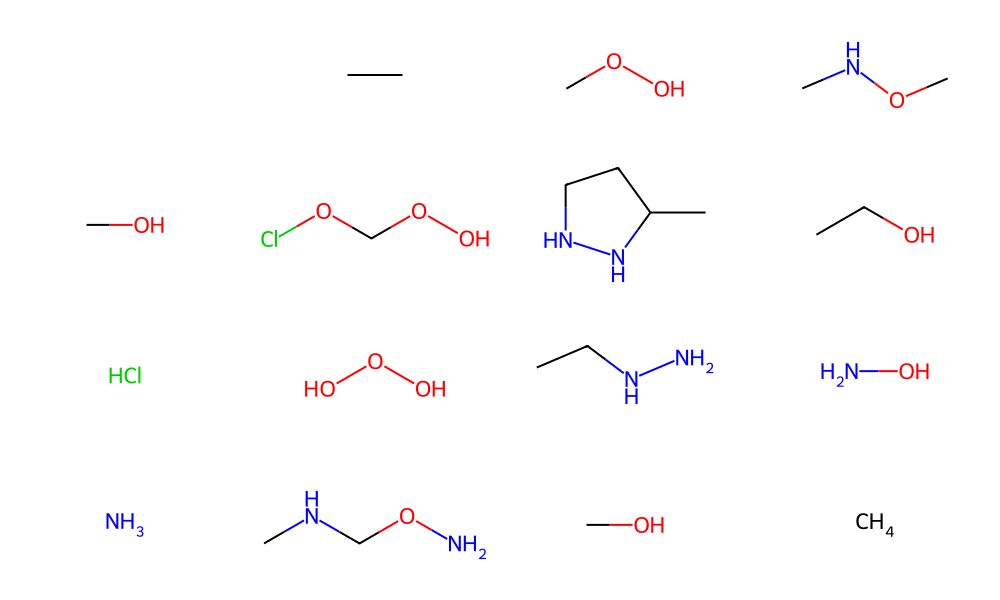

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: C11111111111111111111111ccccccccccccccccccccccccccccccccccccccc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:45<01:28,  2.55it/s]

Epoch 35: 114/342 | ['loss=0.69661', '(kl=5.94626', 'recon=0.28037)', 'klw=0.07000 lr=0.00123']


 67%|██████▋   | 229/342 [01:30<00:44,  2.54it/s]

Epoch 35: 228/342 | ['loss=1.32390', '(kl=11.29240', 'recon=0.53343)', 'klw=0.07000 lr=0.00123']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 379.05it/s]

valid 3.167%  |  unique 1.200%


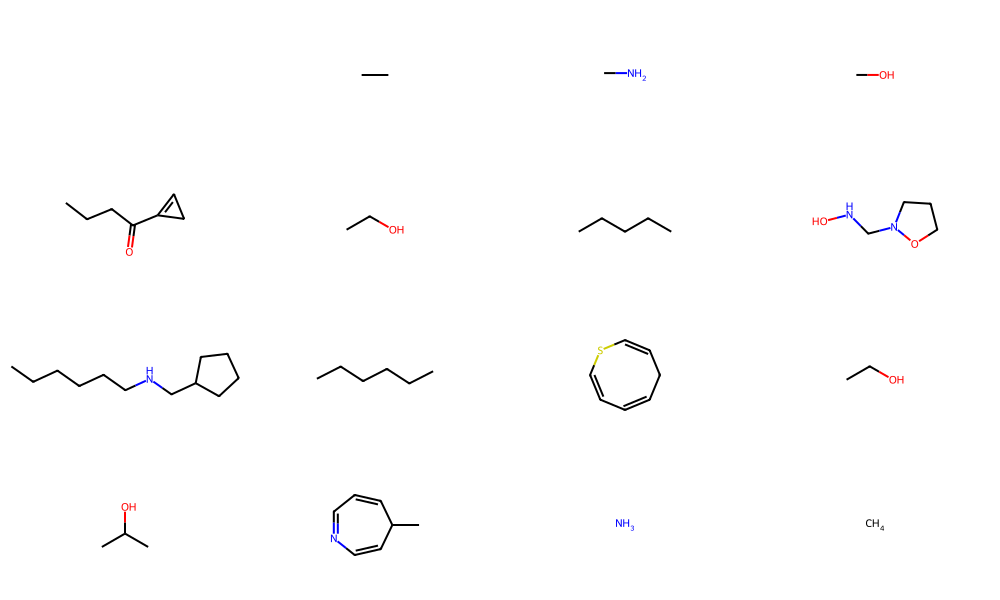

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 21, 21, 6, 6, 32, 21, 8, 6, 32, 32, 21, 21, 6, 32, 21, 6, 32, 21, 32, 21, 32, 32, 32, 32, 32, 21, 32, 32, 2, 37, 21, 2, 2, 32, 32, 21, 21, 21, 6, 2, 2]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CCccccccccccccccccCcccCC))cC-)ccCC)cC)cCcCcccccCcc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:45<01:32,  2.44it/s]

Epoch 36: 114/342 | ['loss=0.77514', '(kl=6.99909', 'recon=0.27120)', 'klw=0.07200 lr=0.00086']


 67%|██████▋   | 229/342 [01:30<00:45,  2.47it/s]

Epoch 36: 228/342 | ['loss=1.39622', '(kl=12.34778', 'recon=0.50718)', 'klw=0.07200 lr=0.00086']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 385.91it/s]

valid 2.433%  |  unique 0.933%


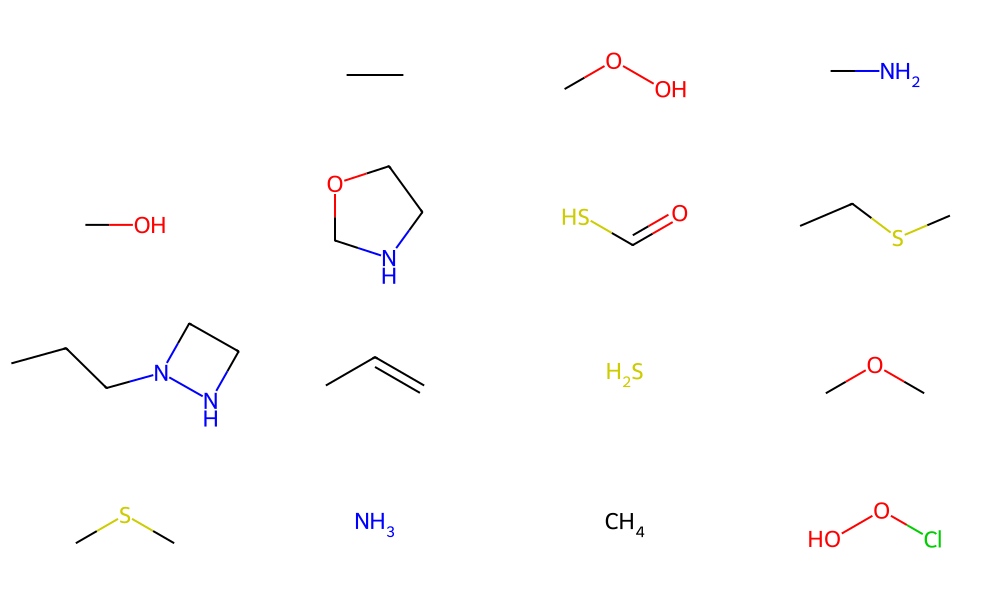

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 5, 21, 32, 32, 32, 21, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 21, 21, 26, 6, 32, 21, 26, 6, 32, 32, 21, 18, 6, 32, 21, 6, 32, 32, 32, 32, 32, 2, 32, 32, 32, 21, 32, 32, 2, 32, 21, 21, 21, 32, 2, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC(CcccCccCcccccccCcccCCO)cCO)ccC=)cC)ccccc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:45<01:26,  2.62it/s]

Epoch 37: 114/342 | ['loss=0.74034', '(kl=5.80510', 'recon=0.31076)', 'klw=0.07400 lr=0.00056']


 67%|██████▋   | 229/342 [01:30<00:43,  2.60it/s]

Epoch 37: 228/342 | ['loss=1.65339', '(kl=13.27644', 'recon=0.67093)', 'klw=0.07400 lr=0.00056']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 395.36it/s]

valid 2.733%  |  unique 1.100%


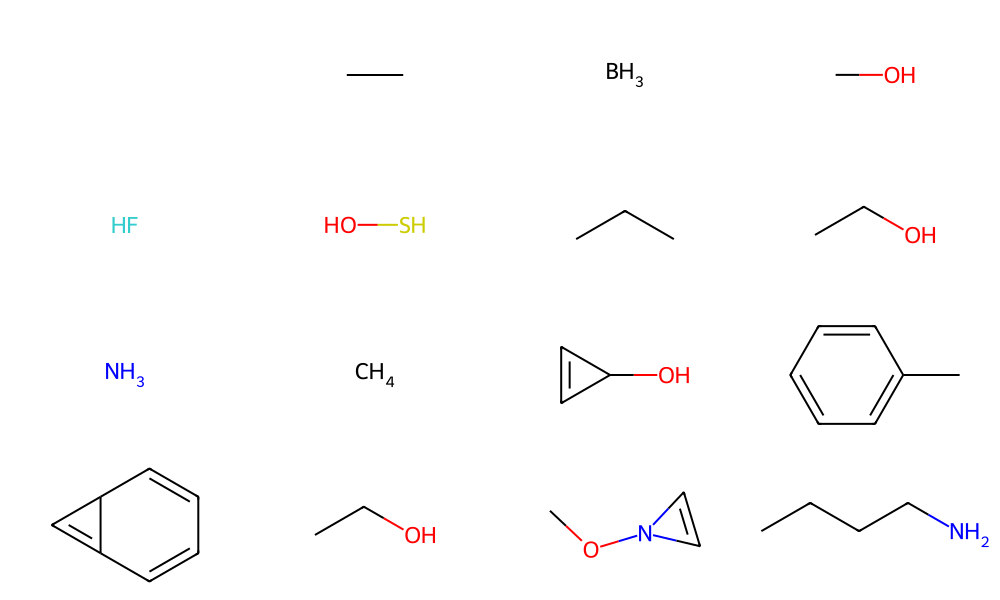

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 21, 21, 32, 32, 32, 21, 32, 32, 21, 32, 32, 21, 32, 32, 32, 32, 21, 32, 21, 32, 21, 21, 21, 21, 32, 21, 21, 6, 32, 32, 21, 21, 6, 32, 21, 6, 32, 6, 32, 32, 32, 21, 32, 32, 32, 21, 32, 32, 21, 32, 21, 6, 6, 32, 21, 6, 6, 6, 6, 21, 6]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CCCCcccCccCccCccccCcCcCCCCcCC)ccCC)cC)c)cccCcccCccCcC))cC))))C)
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.58it/s]

Epoch 38: 114/342 | ['loss=0.71443', '(kl=5.44525', 'recon=0.30059)', 'klw=0.07600 lr=0.00037']


 67%|██████▋   | 229/342 [01:29<00:44,  2.57it/s]

Epoch 38: 228/342 | ['loss=1.40218', '(kl=10.51055', 'recon=0.60338)', 'klw=0.07600 lr=0.00037']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 400.86it/s]

valid 2.300%  |  unique 0.867%


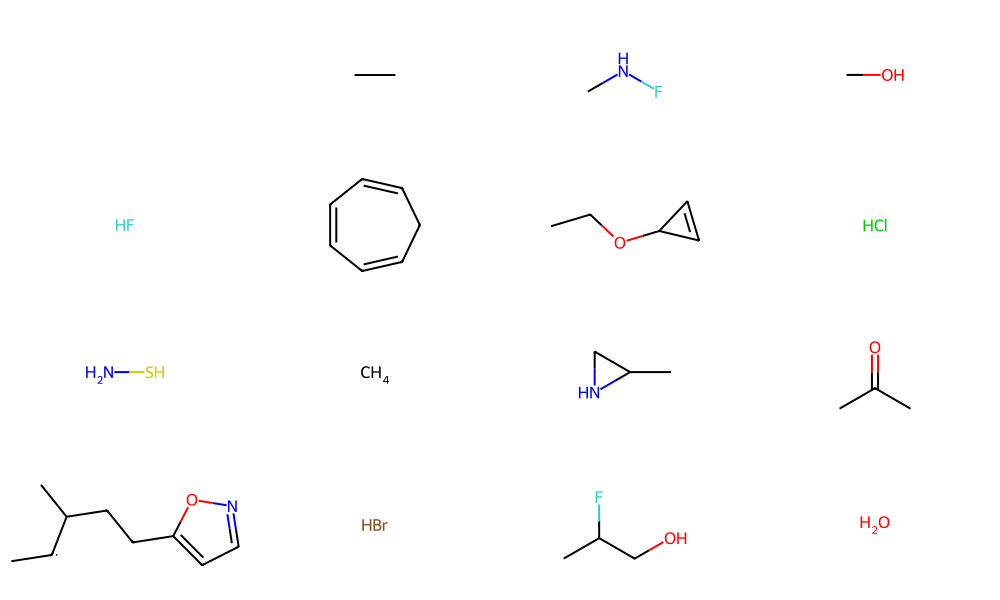

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.60it/s]

Epoch 39: 114/342 | ['loss=0.62208', '(kl=4.22663', 'recon=0.29241)', 'klw=0.07800 lr=0.00030']


 67%|██████▋   | 229/342 [01:29<00:43,  2.57it/s]

Epoch 39: 228/342 | ['loss=1.11432', '(kl=7.60481', 'recon=0.52114)', 'klw=0.07800 lr=0.00030']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 393.77it/s]

valid 1.533%  |  unique 0.767%


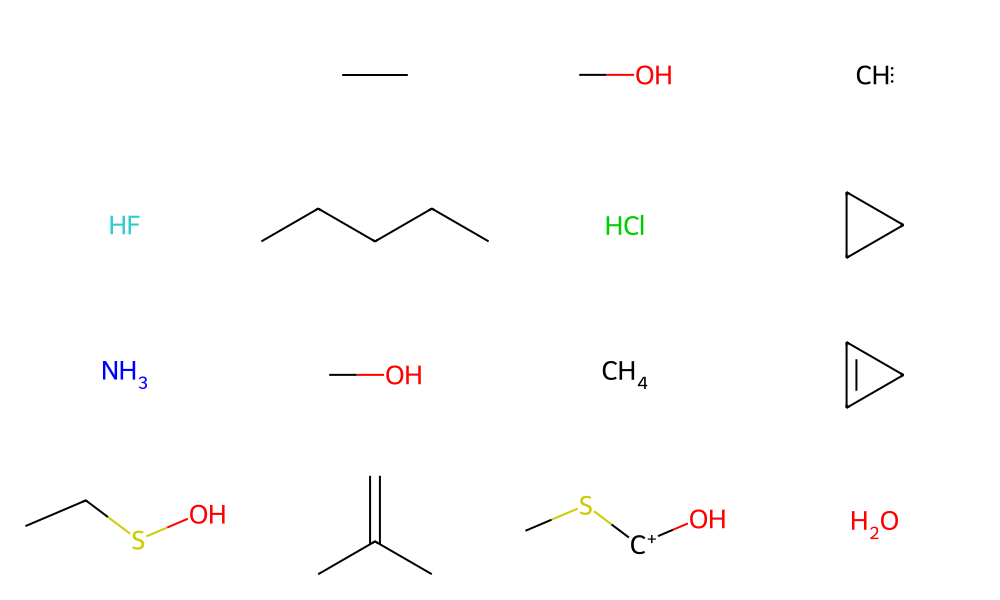

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 21, 32, 21, 32, 21, 21, 6, 21, 32, 21, 21, 21, 21, 6, 21, 6, 21, 6, 6, 21, 21, 6, 32, 21, 6, 32, 6, 32, 6, 6, 21, 6, 32, 6, 21, 6, 32, 21, 6, 21, 6, 6, 6, 21, 6, 6, 6, 6, 21, 6]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CcccccccccCccCcCcCC)CcCCCC)C)C))CC)cC)c)c))C)c)C)cC)C)))C))))C)
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:29,  2.53it/s]

Epoch 40: 114/342 | ['loss=0.93219', '(kl=8.15661', 'recon=0.27966)', 'klw=0.08000 lr=0.00293']


 67%|██████▋   | 229/342 [01:28<00:43,  2.60it/s]

Epoch 40: 228/342 | ['loss=1.91665', '(kl=16.65849', 'recon=0.58397)', 'klw=0.08000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 399.31it/s]

valid 3.100%  |  unique 1.333%


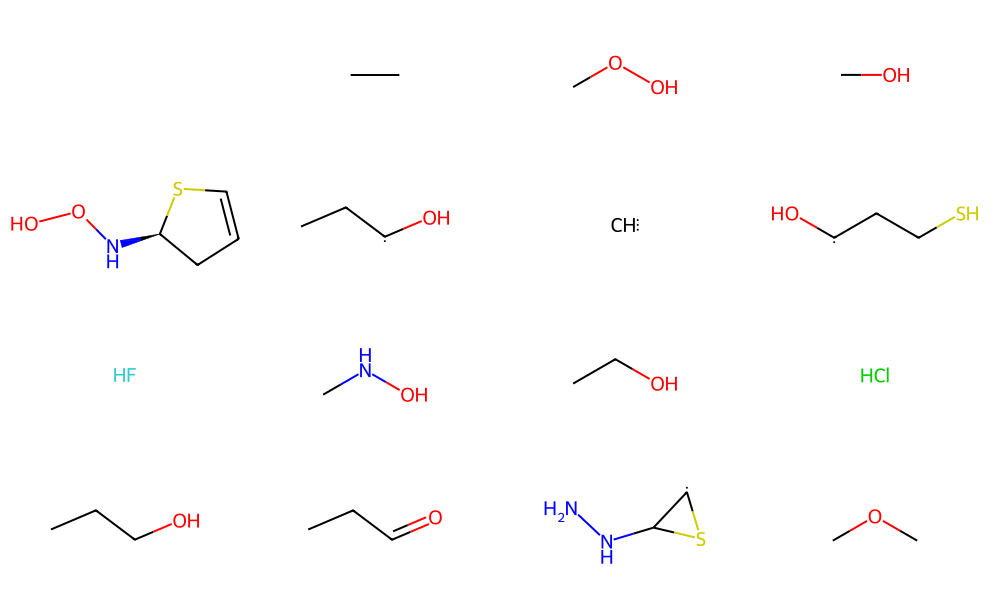

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[26, 21, 32, 21, 32, 32, 32, 21, 6, 32, 6, 32, 32, 6, 32, 32, 32, 32, 21, 32, 6, 32, 21, 18, 26, 6, 32, 21, 26, 6, 32, 32, 6, 18, 6, 32, 21, 6, 32, 6, 32, 32, 32, 6, 32, 32, 32, 21, 32, 32, 6, 32, 6, 6, 6, 32, 6, 6, 6, 21, 21, 6, 6]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: OCcCcccC)c)cc)ccccCc)cC=O)cCO)cc)=)cC)c)ccc)cccCcc)c)))c)))CC))
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.56it/s]

Epoch 41: 114/342 | ['loss=0.59635', '(kl=4.73050', 'recon=0.20845)', 'klw=0.08200 lr=0.00274']


 67%|██████▋   | 229/342 [01:28<00:43,  2.58it/s]

Epoch 41: 228/342 | ['loss=1.53631', '(kl=12.58670', 'recon=0.50420)', 'klw=0.08200 lr=0.00274']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 399.10it/s]

valid 2.133%  |  unique 0.900%


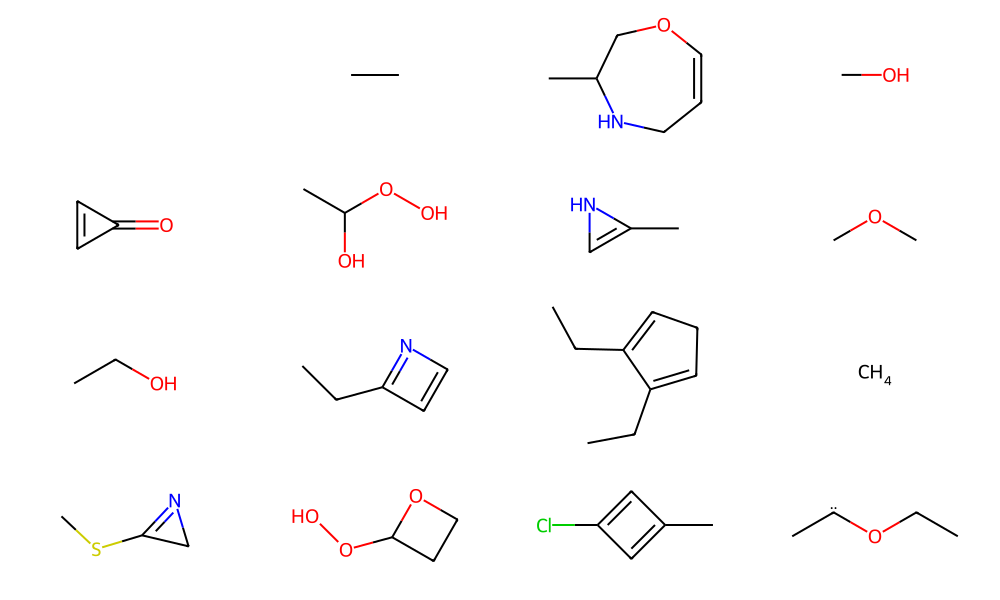

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


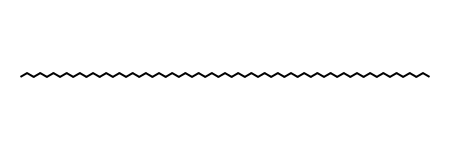

 34%|███▎      | 115/342 [00:44<01:27,  2.60it/s]

Epoch 42: 114/342 | ['loss=0.73374', '(kl=5.30483', 'recon=0.28814)', 'klw=0.08400 lr=0.00244']


 67%|██████▋   | 229/342 [01:28<00:43,  2.62it/s]

Epoch 42: 228/342 | ['loss=1.38473', '(kl=9.47326', 'recon=0.58898)', 'klw=0.08400 lr=0.00244']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 400.49it/s]

valid 2.200%  |  unique 1.467%


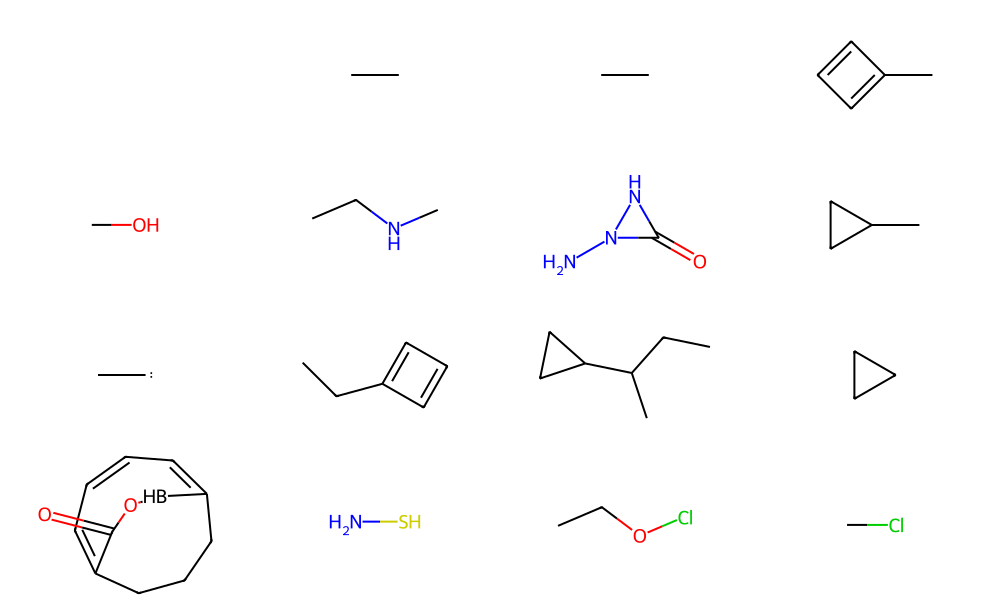

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 32, 21, 6, 11, 32, 21, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 21, 18, 26, 6, 25, 21, 26, 6, 25, 5, 21, 18, 6, 21, 18, 6, 21, 21, 21, 21, 11, 32, 32, 32, 32, 21, 32, 32, 32, 32, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 6]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccccC)2cCccccccCcccC=O)NCO)N(C=)C=)CCCC2ccccCccccCCCCCCCCCC)
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.56it/s]

Epoch 43: 114/342 | ['loss=0.60273', '(kl=4.38810', 'recon=0.22535)', 'klw=0.08600 lr=0.00207']


 67%|██████▋   | 229/342 [01:29<00:44,  2.55it/s]

Epoch 43: 228/342 | ['loss=1.19624', '(kl=8.36399', 'recon=0.47693)', 'klw=0.08600 lr=0.00207']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 397.45it/s]

valid 1.833%  |  unique 1.500%


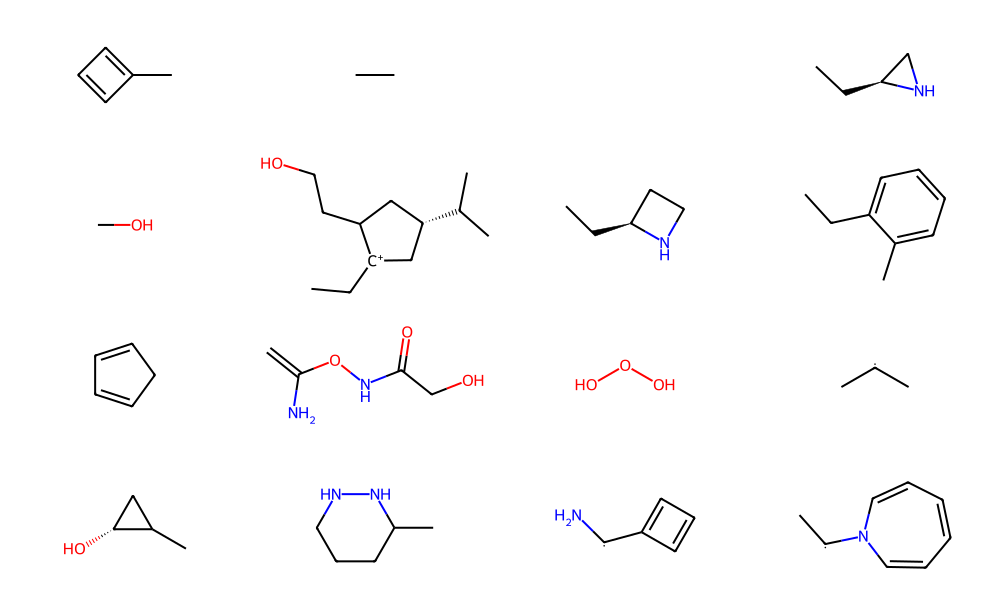

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 26, 10, 32, 32, 32, 5, 21, 6, 12, 32, 21, 11, 32, 32, 32, 32, 32, 21, 11, 32, 32, 21, 18, 26, 6, 25, 18, 26, 6, 25, 21, 5, 18, 6, 32, 22, 6, 21, 21, 21, 21, 11, 32, 32, 32, 32, 21, 11, 32, 32, 32, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CO1ccc(C)3cC2cccccC2ccC=O)N=O)NC(=)cF)CCCC2ccccC2cccCCCCCCCCC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.57it/s]

Epoch 44: 114/342 | ['loss=0.56892', '(kl=4.14497', 'recon=0.20417)', 'klw=0.08800 lr=0.00165']


 67%|██████▋   | 229/342 [01:29<00:45,  2.50it/s]

Epoch 44: 228/342 | ['loss=1.11176', '(kl=8.28204', 'recon=0.38294)', 'klw=0.08800 lr=0.00165']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 406.60it/s]

valid 1.800%  |  unique 1.733%


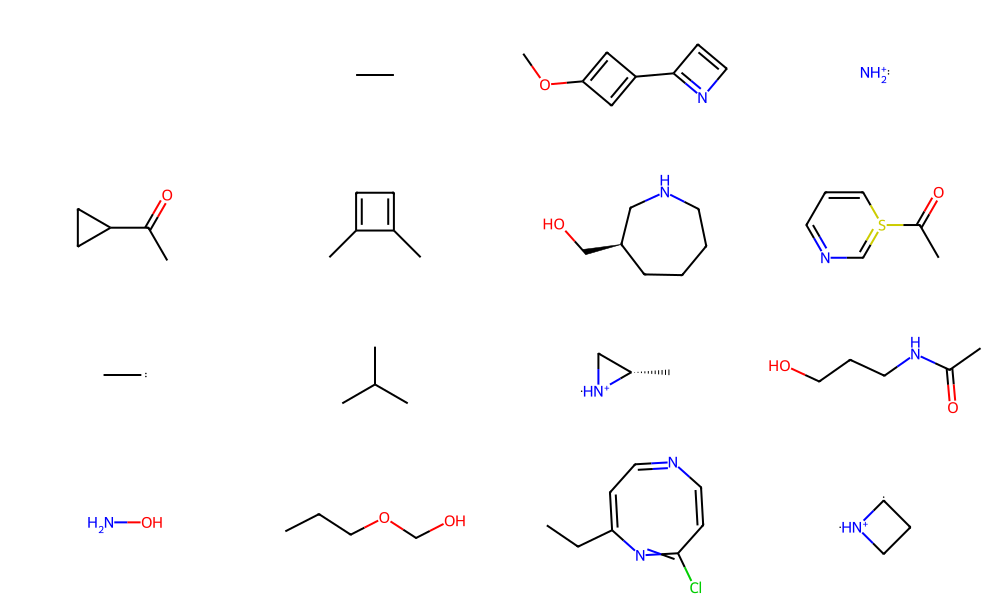

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 32, 21, 32, 11, 32, 32, 10, 32, 32, 32, 32, 32, 21, 11, 32, 32, 21, 18, 26, 6, 25, 18, 26, 6, 25, 21, 5, 18, 6, 32, 21, 6, 32, 21, 21, 21, 10, 32, 32, 32, 32, 21, 11, 32, 21, 32, 21, 6, 5, 21, 6, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccccCc2cc1cccccC2ccC=O)N=O)NC(=)cC)cCCC1ccccC2cCcC)(C)CCCC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:30,  2.51it/s]

Epoch 45: 114/342 | ['loss=0.71786', '(kl=5.20801', 'recon=0.24914)', 'klw=0.09000 lr=0.00123']


 67%|██████▋   | 229/342 [01:28<00:44,  2.54it/s]

Epoch 45: 228/342 | ['loss=1.44580', '(kl=10.17556', 'recon=0.53000)', 'klw=0.09000 lr=0.00123']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 403.52it/s]

valid 2.100%  |  unique 1.700%


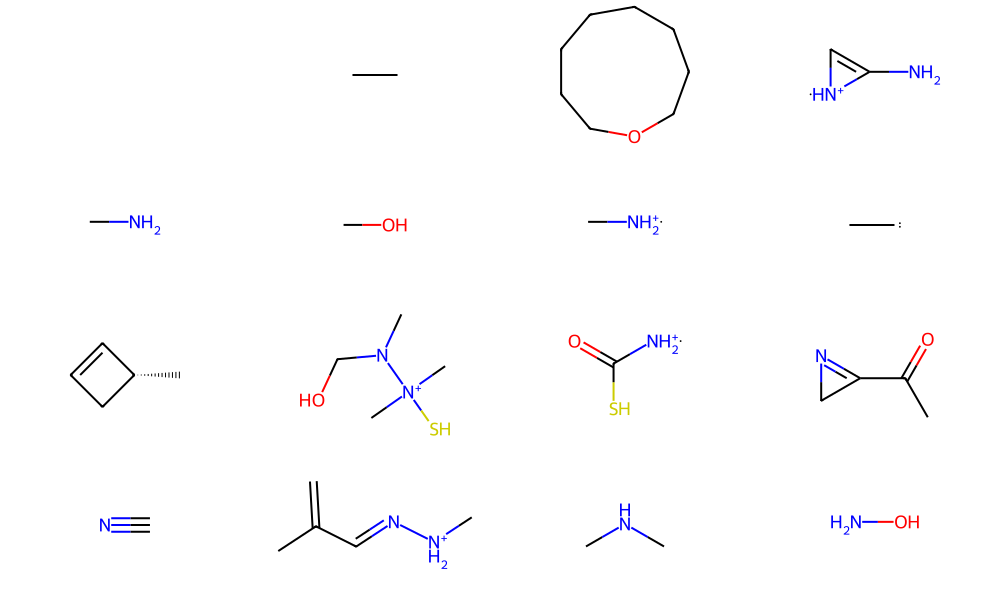

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 32, 32, 32, 6, 32, 21, 6, 31, 32, 32, 6, 32, 32, 32, 32, 32, 21, 6, 32, 32, 21, 21, 19, 6, 32, 21, 26, 6, 32, 32, 21, 21, 19, 6, 21, 6, 32, 21, 32, 32, 32, 32, 32, 32, 32, 21, 6, 31, 32, 21, 21, 21, 6, 32, 32, 21, 21, 21, 21, 32, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Ccccc)cC)]cc)cccccC)ccCC@)cCO)ccCC@)C)cCcccccccC)]cCCC)ccCCCCcC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:26,  2.61it/s]

Epoch 46: 114/342 | ['loss=0.57363', '(kl=4.06381', 'recon=0.19976)', 'klw=0.09200 lr=0.00086']


 67%|██████▋   | 229/342 [01:28<00:44,  2.55it/s]

Epoch 46: 228/342 | ['loss=1.06300', '(kl=7.59533', 'recon=0.36423)', 'klw=0.09200 lr=0.00086']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 406.38it/s]

valid 2.467%  |  unique 2.233%


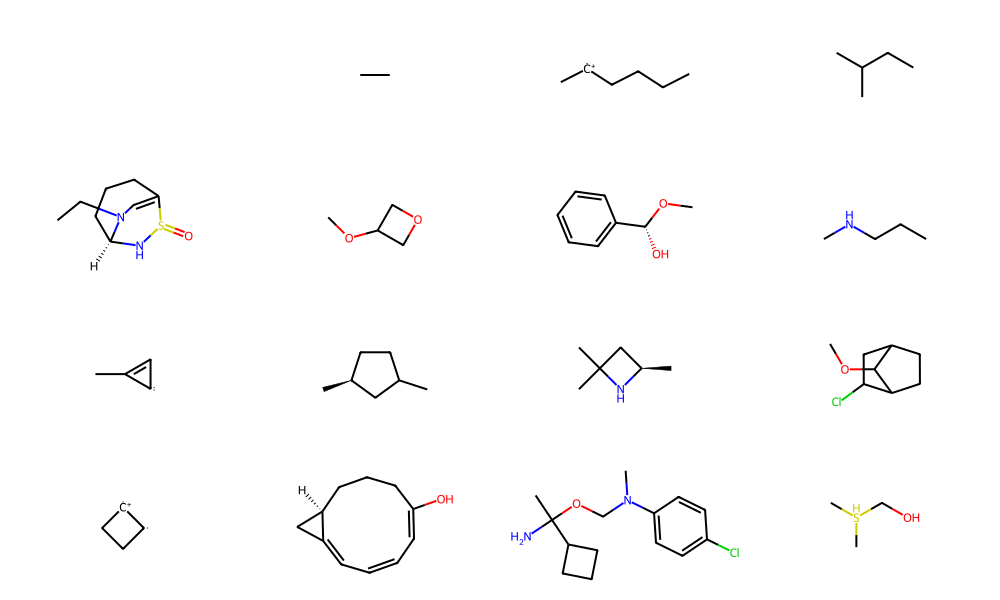

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 6, 32, 32, 21, 5, 32, 32, 32, 32, 32, 21, 6, 32, 21, 21, 18, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 21, 21, 6, 21, 21, 21, 21, 10, 32, 32, 32, 32, 21, 11, 32, 6, 32, 21, 5, 21, 21, 21, 21, 21, 21, 21, 6, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(C)ccC(cccccC)cCC=O)N=O)NCC=)CC)CCCC1ccccC2c)cC(CCCCCCC)C
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.60it/s]

Epoch 47: 114/342 | ['loss=0.44873', '(kl=3.01096', 'recon=0.16570)', 'klw=0.09400 lr=0.00056']


 67%|██████▋   | 229/342 [01:29<00:44,  2.55it/s]

Epoch 47: 228/342 | ['loss=0.87861', '(kl=5.91582', 'recon=0.32252)', 'klw=0.09400 lr=0.00056']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 406.13it/s]

valid 2.533%  |  unique 2.100%


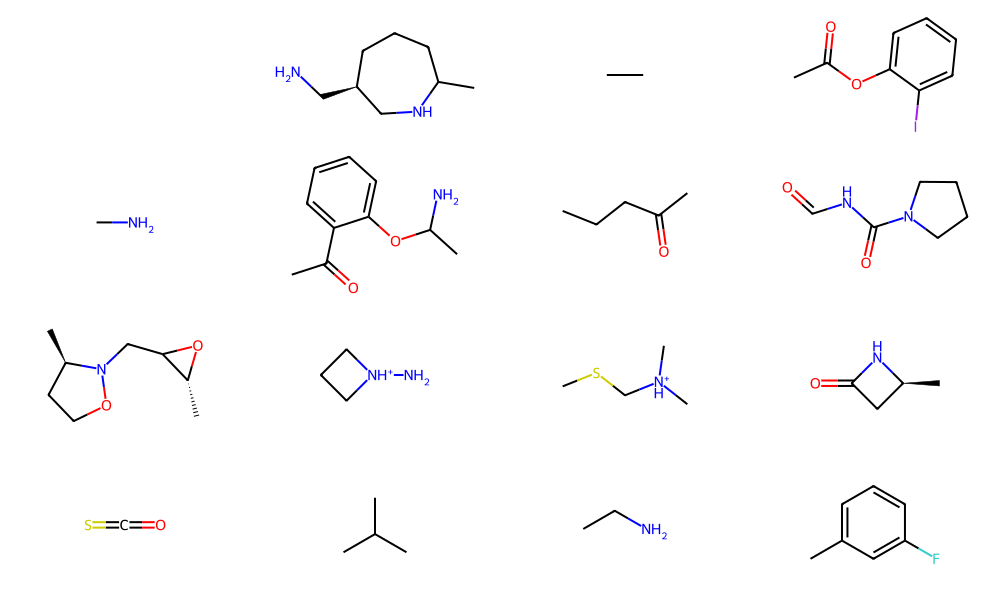

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CcCcccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.55it/s]

Epoch 48: 114/342 | ['loss=0.45286', '(kl=2.99178', 'recon=0.16565)', 'klw=0.09600 lr=0.00037']


 67%|██████▋   | 229/342 [01:29<00:44,  2.56it/s]

Epoch 48: 228/342 | ['loss=0.89863', '(kl=5.87615', 'recon=0.33452)', 'klw=0.09600 lr=0.00037']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 403.32it/s]

valid 2.333%  |  unique 2.133%


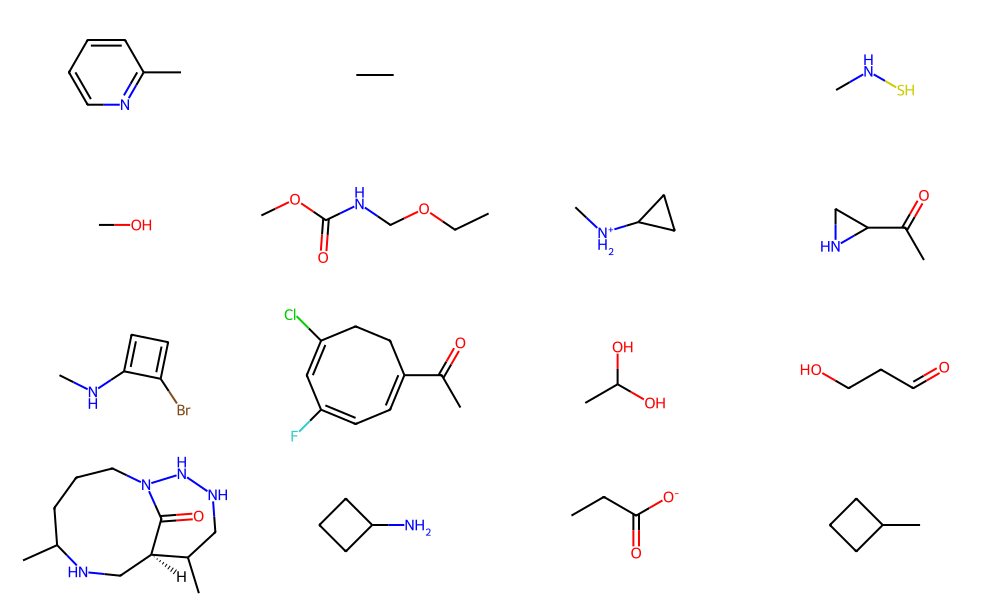

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[22, 32, 10, 32, 32, 32, 32, 21, 6, 32, 32, 21, 10, 32, 32, 32, 32, 32, 21, 6, 32, 32, 21, 18, 26, 6, 25, 18, 26, 6, 25, 32, 21, 18, 6, 21, 21, 6, 21, 21, 32, 10, 10, 32, 32, 32, 32, 21, 6, 32, 32, 32, 21, 21, 21, 5, 32, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Fc1ccccC)ccC1cccccC)ccC=O)N=O)NcC=)CC)CCc11ccccC)cccCCC(cCCCC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.61it/s]

Epoch 49: 114/342 | ['loss=0.44531', '(kl=2.93606', 'recon=0.15758)', 'klw=0.09800 lr=0.00030']


 67%|██████▋   | 229/342 [01:29<00:43,  2.59it/s]

Epoch 49: 228/342 | ['loss=0.87684', '(kl=5.78788', 'recon=0.30963)', 'klw=0.09800 lr=0.00030']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 406.84it/s]

valid 2.633%  |  unique 2.467%


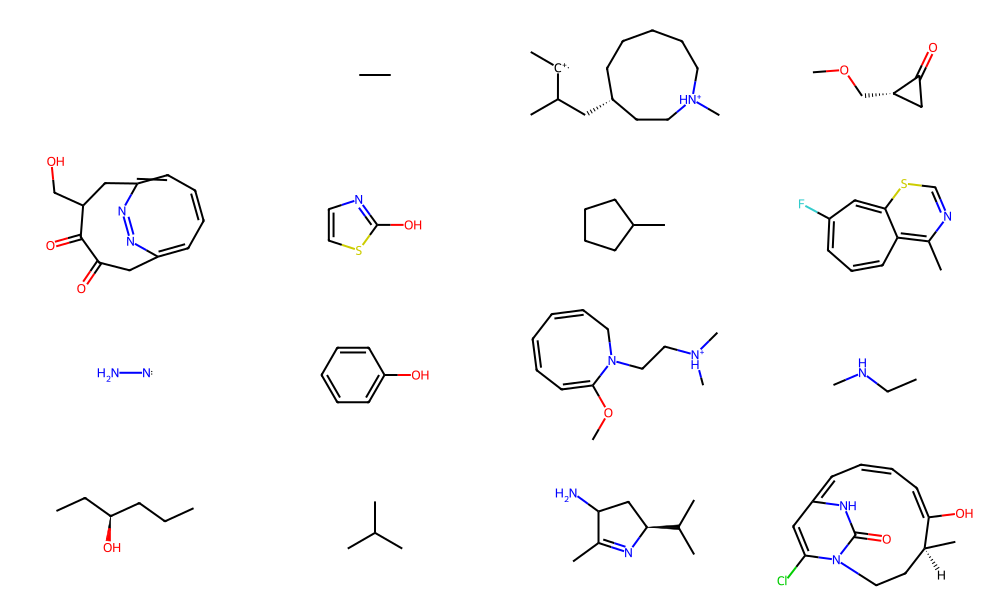

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 32, 32, 32, 32, 32, 32, 6, 6, 32, 32, 32, 32, 32, 32, 32, 32, 21, 6, 6, 32, 21, 21, 21, 6, 32, 21, 26, 6, 32, 32, 21, 21, 6, 32, 21, 6, 32, 32, 32, 21, 6, 21, 6, 32, 32, 21, 6, 32, 32, 32, 21, 6, 6, 32, 32, 21, 6, 6, 6, 6, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CCcccccc))ccccccccC))cCCC)cCO)ccCC)cC)cccC)C)ccC)cccC))ccC))))c
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.59it/s]

Epoch 50: 114/342 | ['loss=0.59496', '(kl=3.65827', 'recon=0.22913)', 'klw=0.10000 lr=0.00293']


 67%|██████▋   | 229/342 [01:28<00:44,  2.56it/s]

Epoch 50: 228/342 | ['loss=1.18326', '(kl=7.09506', 'recon=0.47375)', 'klw=0.10000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 398.94it/s]

valid 0.933%  |  unique 0.800%


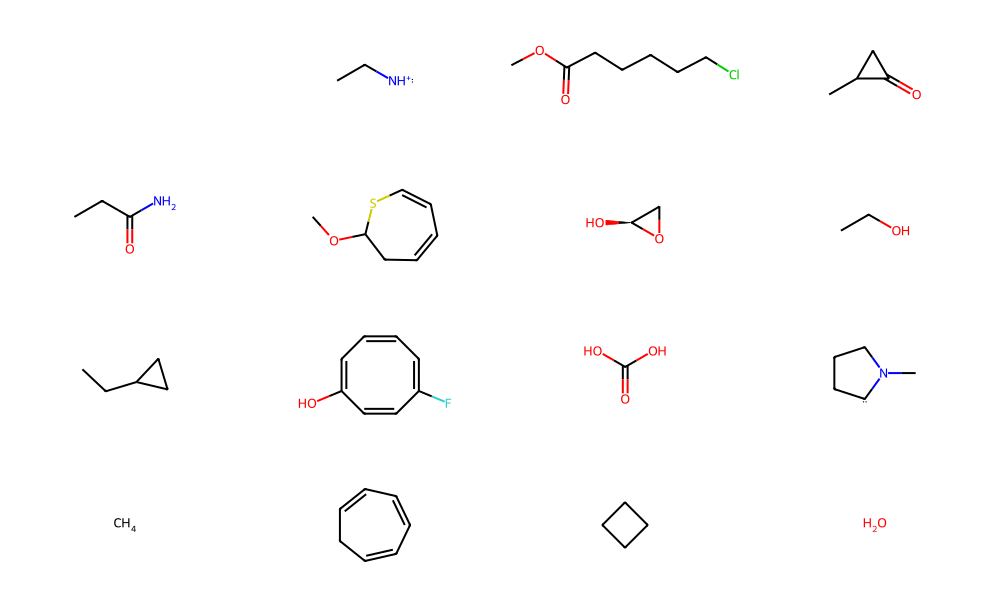

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 6, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cccc1ccccccccccccccccccc)cccCcccccccc1ccccccccccccccc1ccccccccc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:25,  2.64it/s]

Epoch 51: 114/342 | ['loss=0.65281', '(kl=3.83374', 'recon=0.26177)', 'klw=0.10200 lr=0.00274']


 67%|██████▋   | 229/342 [01:28<00:43,  2.61it/s]

Epoch 51: 228/342 | ['loss=1.20959', '(kl=6.58649', 'recon=0.53776)', 'klw=0.10200 lr=0.00274']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 408.17it/s]

valid 1.467%  |  unique 1.300%


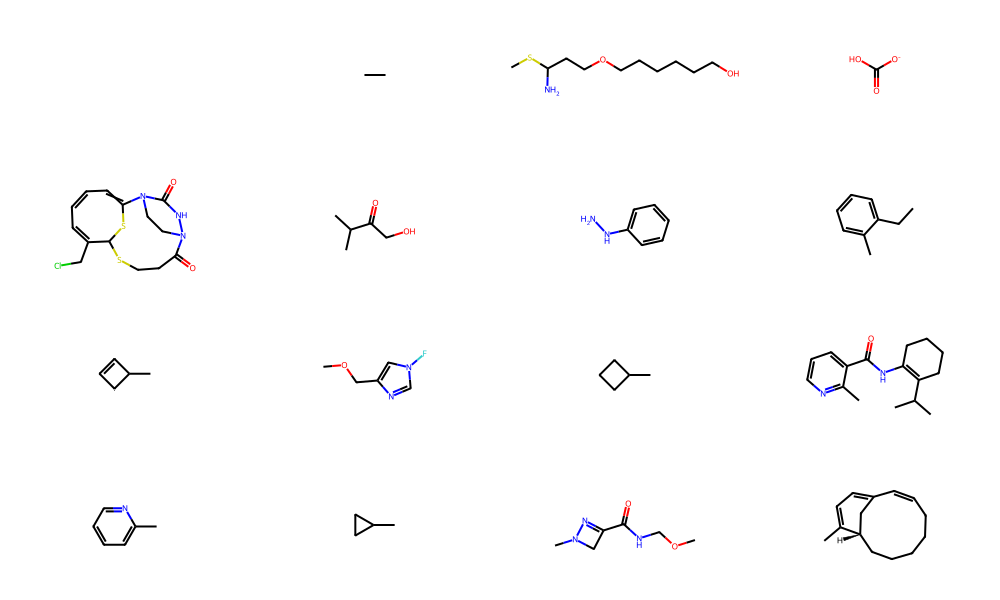

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 21, 32, 32, 32, 32, 21, 26, 6, 32, 21, 26, 6, 32, 32, 5, 18, 6, 32, 32, 6, 32, 32, 32, 32, 10, 32, 32, 32, 32, 21, 32, 32, 32, 32, 32, 21, 21, 10, 2, 21, 21, 5, 21, 21, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccccCccccccccccCccccCO)cCO)cc(=)cc)cccc1ccccCcccccCC1
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:29,  2.55it/s]

Epoch 52: 114/342 | ['loss=0.48434', '(kl=2.98016', 'recon=0.17440)', 'klw=0.10400 lr=0.00244']


 67%|██████▋   | 229/342 [01:28<00:43,  2.61it/s]

Epoch 52: 228/342 | ['loss=0.91643', '(kl=5.57805', 'recon=0.33632)', 'klw=0.10400 lr=0.00244']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 410.72it/s]

valid 1.233%  |  unique 1.067%


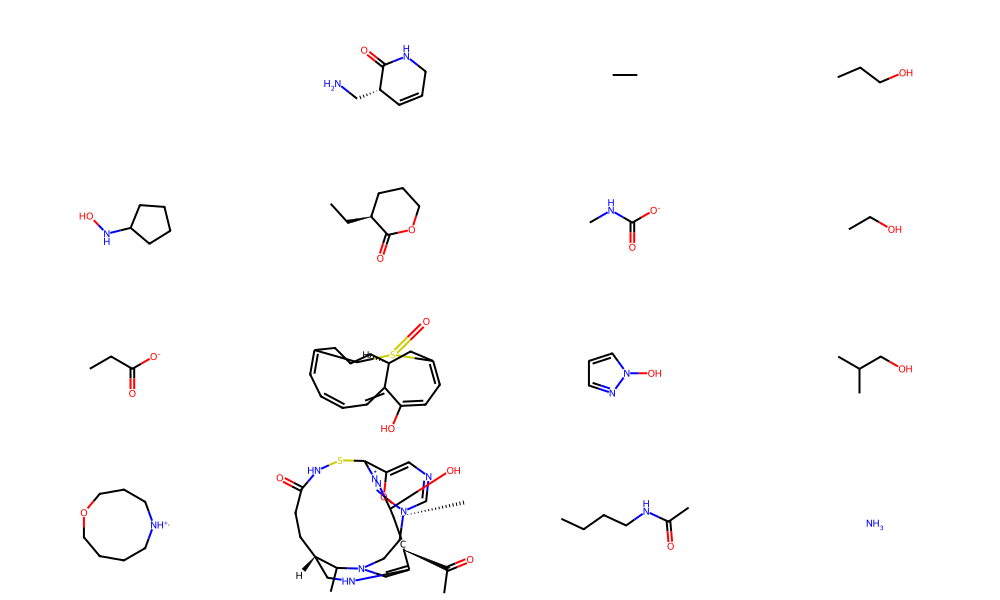

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 11, 5, 32, 32, 11, 32, 32, 32, 5, 32, 21, 11, 6, 32, 5, 18, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 21, 21, 6, 21, 6, 32, 21, 11, 32, 32, 32, 32, 21, 11, 11, 32, 32, 21, 21, 21, 11, 21, 21, 21, 21, 11, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(C2(cc2ccc(cC2)c(=O)N=O)NCC=)CC)C)cC2ccccC22ccCCC2CCCC2
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:29,  2.53it/s]

Epoch 53: 114/342 | ['loss=0.75188', '(kl=4.99665', 'recon=0.22223)', 'klw=0.10600 lr=0.00207']


 67%|██████▋   | 229/342 [01:28<00:43,  2.61it/s]

Epoch 53: 228/342 | ['loss=1.29955', '(kl=8.35672', 'recon=0.41374)', 'klw=0.10600 lr=0.00207']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 409.62it/s]

valid 1.733%  |  unique 1.467%


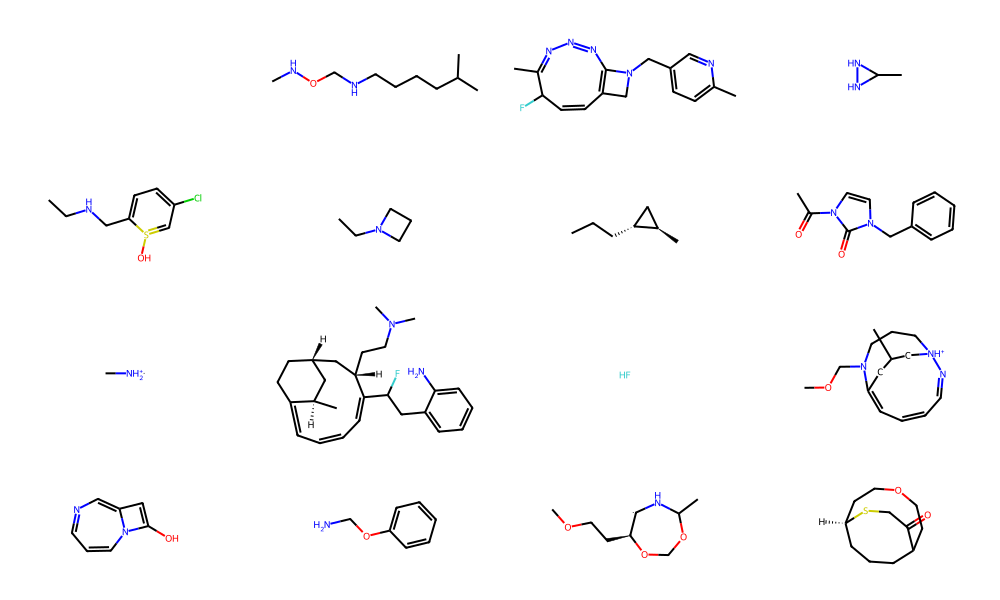

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 18, 10, 32, 32, 32, 5, 21, 11, 11, 32, 21, 11, 32, 32, 32, 32, 32, 21, 11, 6, 32, 21, 18, 26, 6, 25, 18, 26, 6, 25, 21, 5, 18, 6, 21, 21, 6, 21, 6, 32, 21, 10, 32, 32, 32, 32, 21, 11, 11, 2, 21, 21, 10, 21, 21, 21, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: C=1ccc(C22cC2cccccC2)cC=O)N=O)NC(=)CC)C)cC1ccccC22
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:26,  2.61it/s]

Epoch 54: 114/342 | ['loss=0.39054', '(kl=2.32645', 'recon=0.13928)', 'klw=0.10800 lr=0.00165']


 67%|██████▋   | 229/342 [01:28<00:42,  2.63it/s]

Epoch 54: 228/342 | ['loss=0.73770', '(kl=4.32147', 'recon=0.27098)', 'klw=0.10800 lr=0.00165']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 410.39it/s]

valid 1.833%  |  unique 1.500%


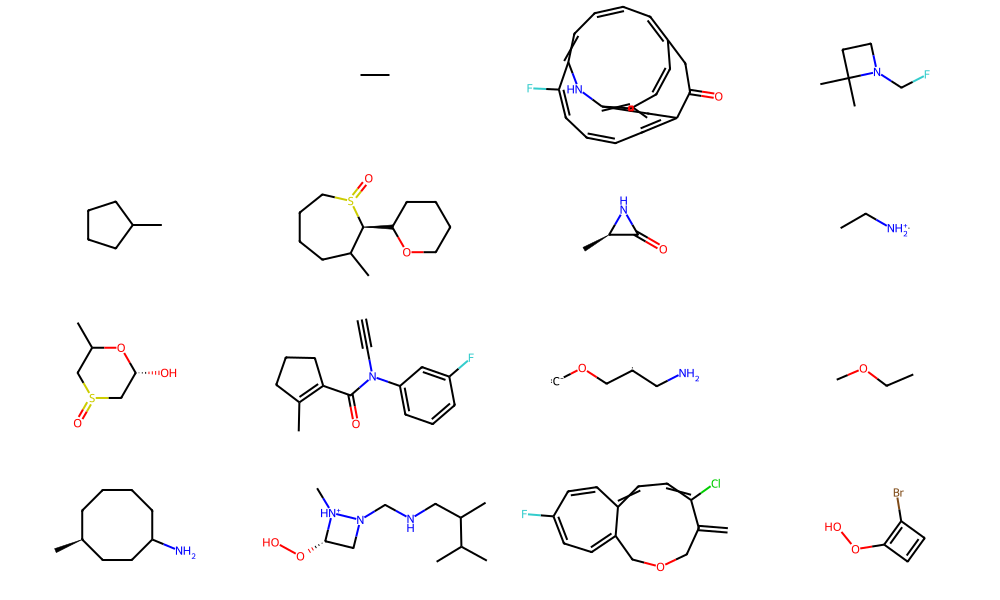

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 11, 11, 32, 32, 11, 32, 32, 32, 32, 32, 21, 11, 6, 21, 21, 18, 26, 6, 25, 18, 26, 6, 25, 32, 5, 18, 6, 21, 21, 6, 21, 6, 32, 21, 11, 32, 32, 32, 32, 21, 11, 11, 32, 32, 21, 21, 11, 11, 21, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(C22cc2cccccC2)CC=O)N=O)Nc(=)CC)C)cC2ccccC22ccCC22CCCCC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.59it/s]

Epoch 55: 114/342 | ['loss=0.34631', '(kl=1.82250', 'recon=0.14584)', 'klw=0.11000 lr=0.00123']


 67%|██████▋   | 229/342 [01:29<00:44,  2.54it/s]

Epoch 55: 228/342 | ['loss=0.94601', '(kl=5.58338', 'recon=0.33184)', 'klw=0.11000 lr=0.00123']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 409.47it/s]

valid 1.267%  |  unique 1.067%


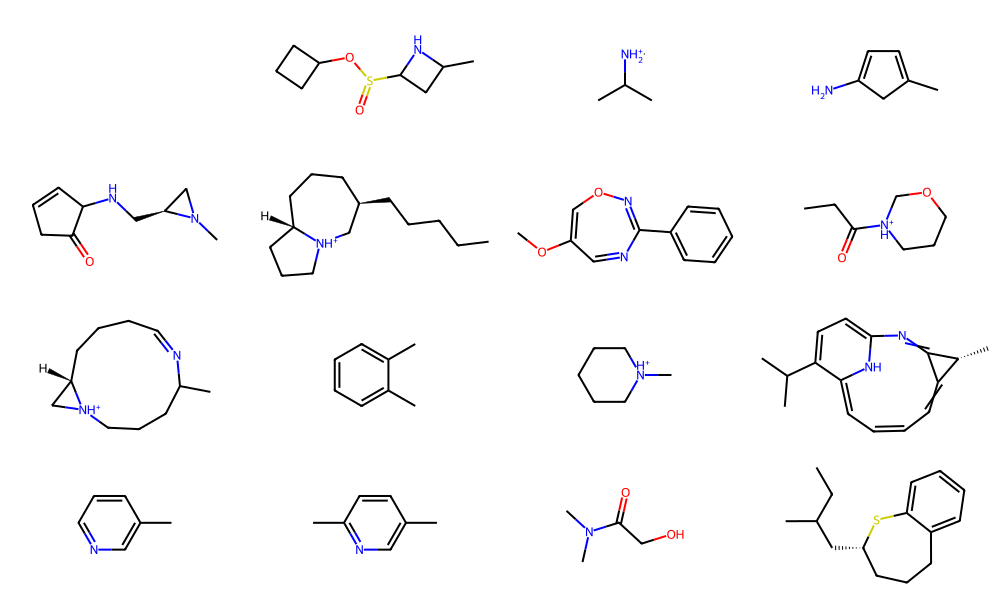

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 18, 10, 32, 32, 32, 5, 21, 32, 11, 32, 32, 32, 32, 32, 32, 5, 32, 21, 11, 6, 32, 32, 21, 26, 6, 25, 18, 26, 6, 25, 32, 21, 18, 6, 32, 22, 6, 32, 6, 32, 10, 10, 32, 32, 32, 32, 21, 11, 32, 32, 32, 21, 5, 32, 10, 21, 21, 21, 21, 21, 2, 2]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: C=1ccc(Cc2cccccc(cC2)ccCO)N=O)NcC=)cF)c)c11ccccC2cccC(c1CCCCC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.55it/s]

Epoch 56: 114/342 | ['loss=0.42978', '(kl=2.47350', 'recon=0.15275)', 'klw=0.11200 lr=0.00086']


 67%|██████▋   | 229/342 [01:28<00:43,  2.59it/s]

Epoch 56: 228/342 | ['loss=0.74871', '(kl=4.19529', 'recon=0.27884)', 'klw=0.11200 lr=0.00086']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 408.39it/s]

valid 2.433%  |  unique 2.133%


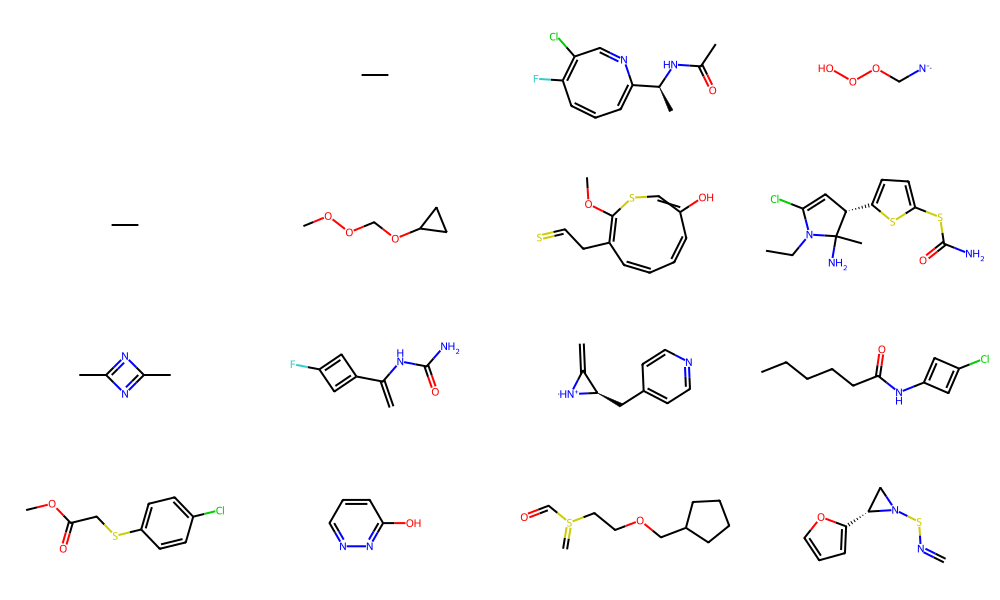

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 32, 11, 32, 21, 11, 32, 32, 32, 32, 32, 21, 11, 6, 21, 21, 18, 26, 6, 25, 18, 26, 6, 25, 32, 5, 18, 6, 21, 21, 6, 21, 6, 32, 21, 10, 32, 32, 32, 32, 21, 11, 32, 2, 32, 21, 21, 10, 11, 21, 21, 21, 21, 11, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(Cc2cC2cccccC2)CC=O)N=O)Nc(=)CC)C)cC1ccccC2c
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:29,  2.54it/s]

Epoch 57: 114/342 | ['loss=0.27717', '(kl=1.31493', 'recon=0.12726)', 'klw=0.11400 lr=0.00056']


 67%|██████▋   | 229/342 [01:29<00:43,  2.59it/s]

Epoch 57: 228/342 | ['loss=0.62182', '(kl=3.04810', 'recon=0.27434)', 'klw=0.11400 lr=0.00056']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 406.21it/s]

valid 1.733%  |  unique 1.500%


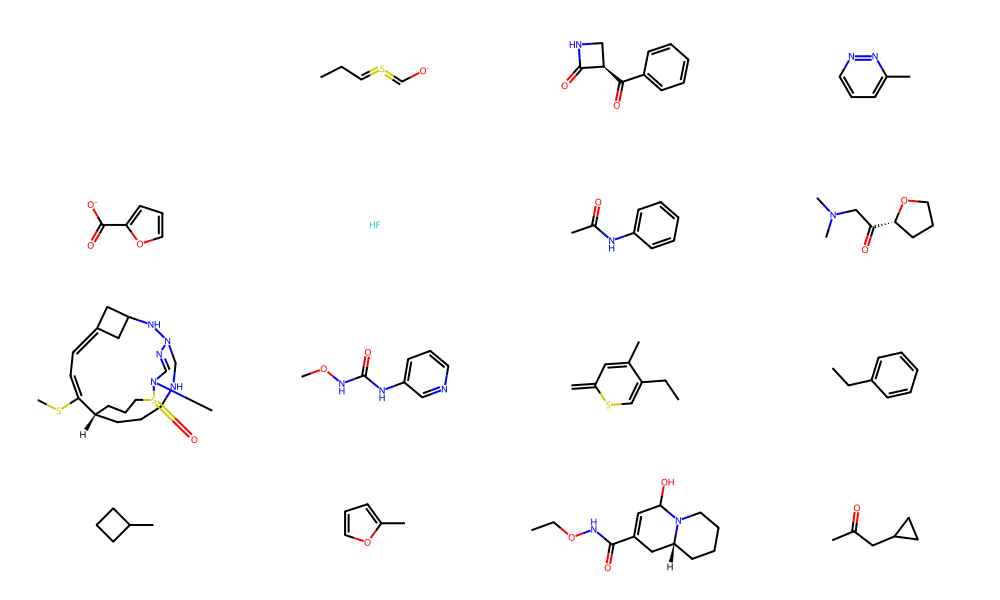

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 21, 32, 6, 21, 21, 18, 6, 6, 25, 18, 26, 6, 32, 32, 2, 18, 6, 21, 21, 6, 21, 2, 21, 32, 10, 32, 32, 32, 32, 21, 11, 32, 2, 32, 21, 21, 2, 5, 2, 2, 21, 21, 2, 2, 2]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(CccCcccccccCc)CC=))N=O)cc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.56it/s]

Epoch 58: 114/342 | ['loss=0.56594', '(kl=3.08854', 'recon=0.20767)', 'klw=0.11600 lr=0.00037']


 67%|██████▋   | 229/342 [01:28<00:43,  2.61it/s]

Epoch 58: 228/342 | ['loss=1.04178', '(kl=5.57568', 'recon=0.39500)', 'klw=0.11600 lr=0.00037']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 404.41it/s]

valid 2.167%  |  unique 1.933%


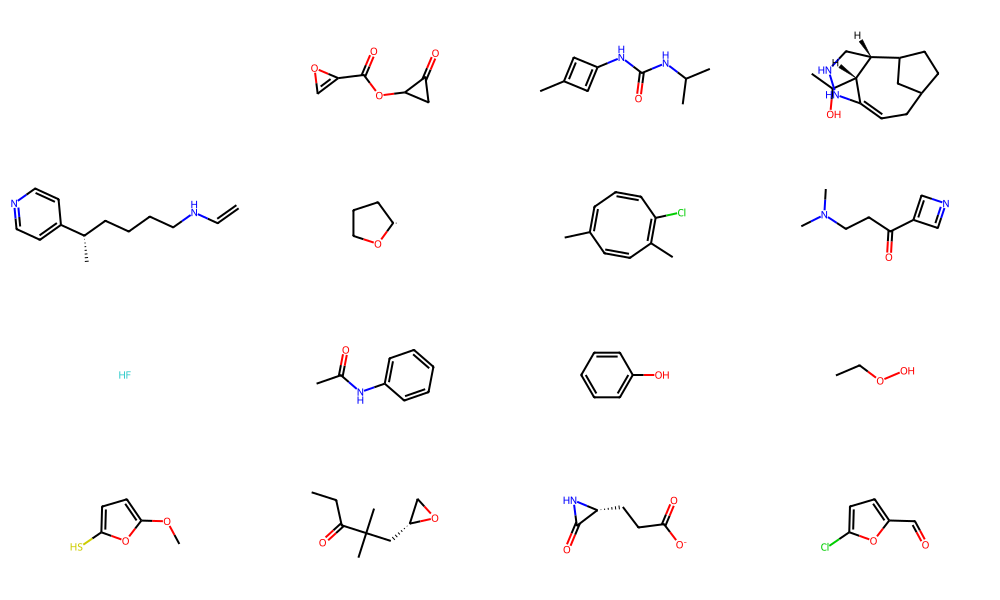

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 32, 11, 8, 32, 11, 32, 32, 32, 32, 32, 21, 11, 6, 21, 21, 18, 26, 6, 25, 18, 26, 6, 25, 32, 5, 18, 6, 21, 21, 6, 21, 6, 32, 5, 10, 32, 32, 32, 32, 21, 11, 11, 2, 32, 21, 21, 11, 11, 21, 21, 21, 5, 11, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cc2-c2cccccC2)CC=O)N=O)Nc(=)CC)C)c(1ccccC22
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.59it/s]

Epoch 59: 114/342 | ['loss=0.37457', '(kl=1.81035', 'recon=0.16094)', 'klw=0.11800 lr=0.00030']


 67%|██████▋   | 229/342 [01:28<00:44,  2.54it/s]

Epoch 59: 228/342 | ['loss=0.70007', '(kl=3.40048', 'recon=0.29881)', 'klw=0.11800 lr=0.00030']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 413.03it/s]

valid 1.900%  |  unique 1.733%


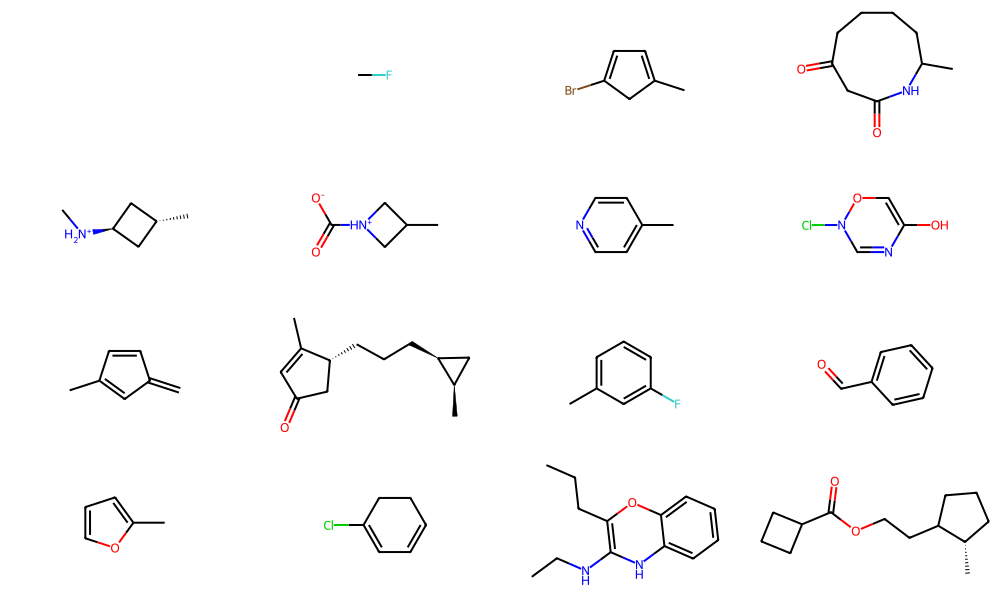

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 11, 5, 32, 32, 11, 32, 32, 32, 32, 32, 21, 11, 6, 21, 5, 18, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 21, 21, 6, 21, 6, 32, 5, 10, 32, 32, 32, 32, 21, 11, 32, 32, 32, 21, 21, 21, 11, 21, 21, 21, 21, 11, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(C2(cc2cccccC2)C(=O)N=O)NCC=)CC)C)c(1ccccC2cccCCC2CCCC2
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:25,  2.65it/s]

Epoch 60: 114/342 | ['loss=0.47365', '(kl=2.65312', 'recon=0.15528)', 'klw=0.12000 lr=0.00293']


 67%|██████▋   | 229/342 [01:28<00:43,  2.60it/s]

Epoch 60: 228/342 | ['loss=1.36331', '(kl=8.22811', 'recon=0.37594)', 'klw=0.12000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 404.58it/s]

valid 2.133%  |  unique 1.800%


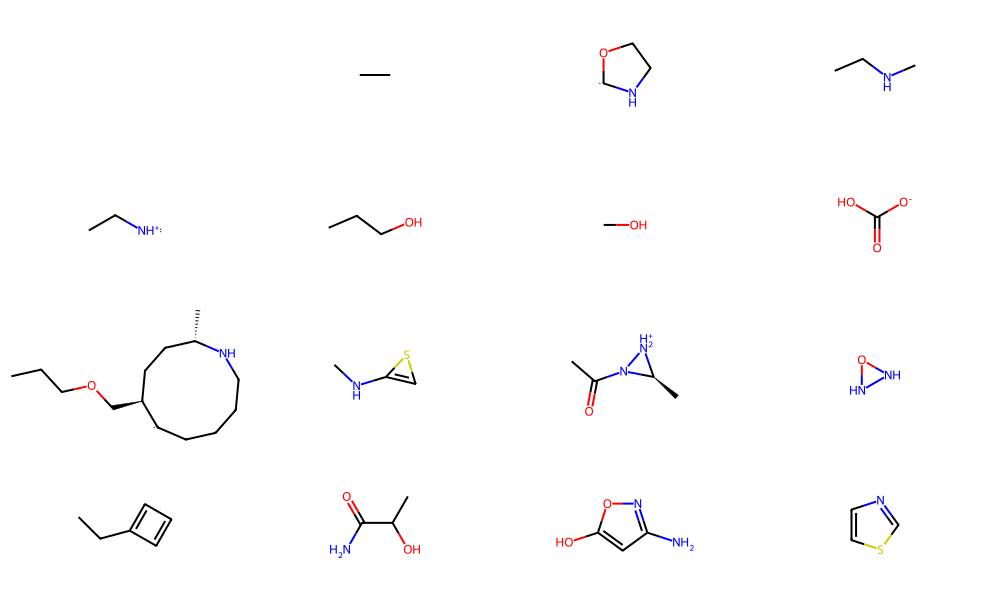

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 32, 32, 32, 21, 11, 32, 32, 32, 32, 32, 21, 32, 6, 21, 21, 21, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 21, 21, 6, 21, 21, 21, 21, 11, 32, 32, 32, 32, 22, 11, 32, 2, 32, 21, 21, 21, 5, 21, 21, 21, 21, 21, 21, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(CcccC2cccccCc)CCCO)N=O)NCC=)CC)CCCC2ccccF2c
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.58it/s]

Epoch 61: 114/342 | ['loss=0.83723', '(kl=5.08341', 'recon=0.21706)', 'klw=0.12200 lr=0.00274']


 67%|██████▋   | 229/342 [01:28<00:43,  2.58it/s]

Epoch 61: 228/342 | ['loss=1.83615', '(kl=10.71862', 'recon=0.52848)', 'klw=0.12200 lr=0.00274']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 405.40it/s]

valid 1.767%  |  unique 1.233%


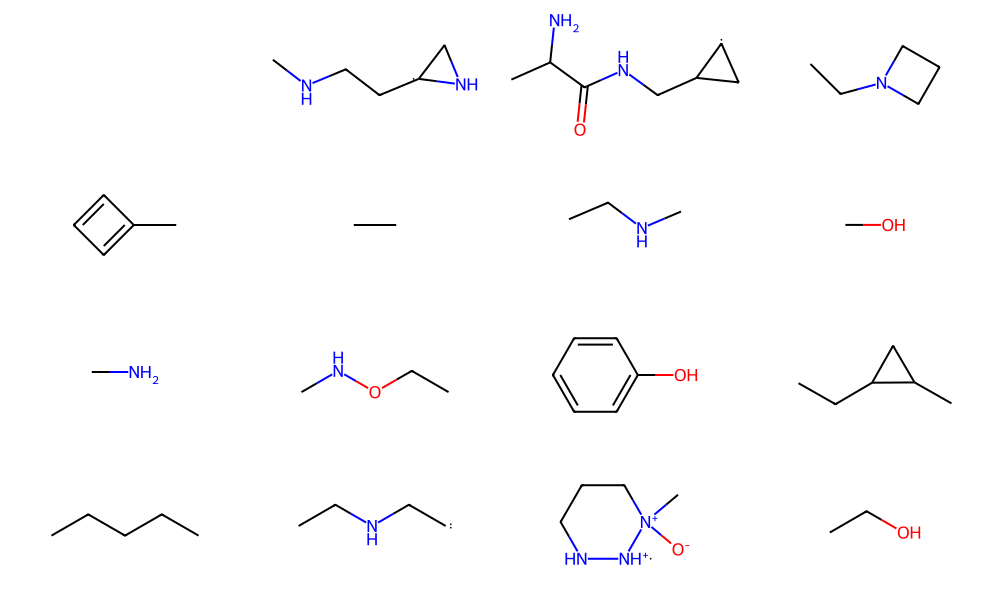

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 32, 32, 32, 32, 32, 32, 32, 32, 8, 32, 8, 32, 8, 32, 32, 8, 32, 8, 32, 8, 32, 32, 8, 8, 8, 32, 32, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CCcccccccc-c-c-cc-c-c-cc---cc----------------------------------
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:28,  2.56it/s]

Epoch 62: 114/342 | ['loss=1.04995', '(kl=6.22708', 'recon=0.27779)', 'klw=0.12400 lr=0.00244']


 67%|██████▋   | 229/342 [01:28<00:43,  2.61it/s]

Epoch 62: 228/342 | ['loss=1.99469', '(kl=11.87247', 'recon=0.52250)', 'klw=0.12400 lr=0.00244']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 389.97it/s]

valid 1.633%  |  unique 1.367%


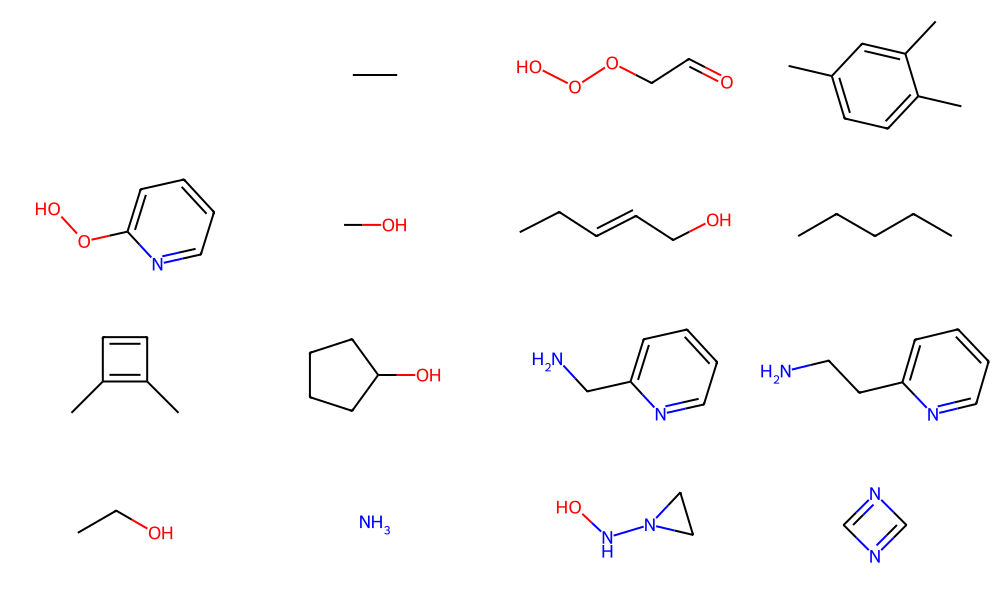

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 26, 32, 21, 10, 10, 32, 21, 10, 10, 32, 21, 5, 32, 32, 32, 5, 32, 21, 6, 32, 32, 21, 21, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 32, 21, 6, 21, 21, 21, 5, 10, 21, 32, 32, 32, 21, 6, 32, 2, 21, 21, 21, 21, 21, 2, 21, 21, 21, 21, 21, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: COcC11cC11cC(ccc(cC)ccCCO)N=O)NCC=)cC)CCC(1CcccC)c
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:29,  2.55it/s]

Epoch 63: 114/342 | ['loss=1.24617', '(kl=8.16796', 'recon=0.21701)', 'klw=0.12600 lr=0.00207']


 67%|██████▋   | 229/342 [01:28<00:43,  2.58it/s]

Epoch 63: 228/342 | ['loss=2.14863', '(kl=13.72903', 'recon=0.41877)', 'klw=0.12600 lr=0.00207']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 403.90it/s]

valid 1.300%  |  unique 1.100%


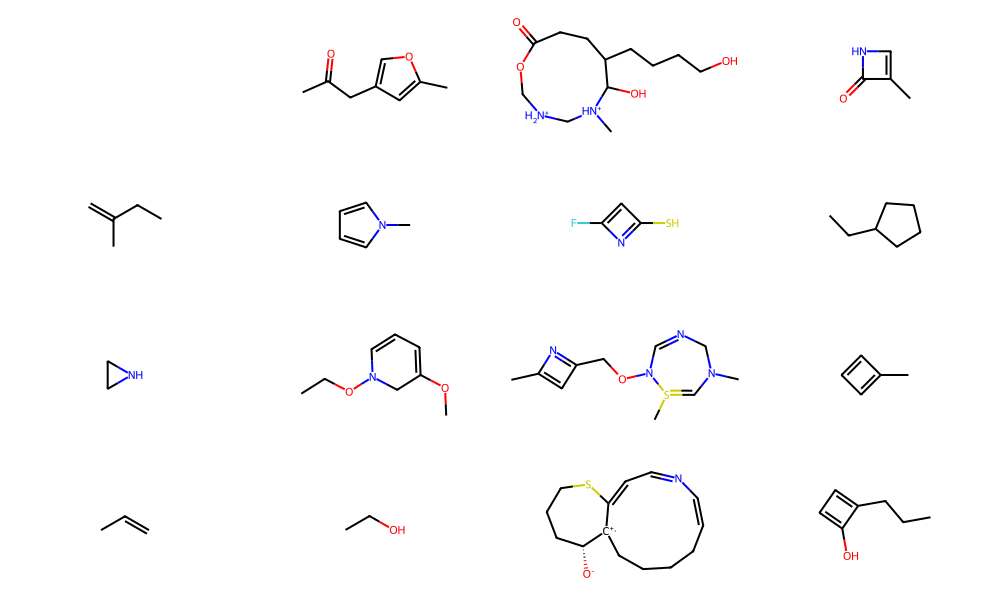

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 32, 21, 6, 11, 32, 21, 11, 32, 32, 32, 5, 32, 21, 6, 6, 32, 21, 18, 26, 6, 25, 21, 26, 6, 25, 21, 21, 18, 6, 21, 21, 6, 21, 21, 21, 21, 10, 2, 32, 32, 5, 21, 10, 32, 2, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccccC)2cC2ccc(cC))cC=O)NCO)NCC=)CC)CCCC1
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:29,  2.53it/s]

Epoch 64: 114/342 | ['loss=0.47582', '(kl=2.51744', 'recon=0.15359)', 'klw=0.12800 lr=0.00165']


 67%|██████▋   | 229/342 [01:29<00:44,  2.55it/s]

Epoch 64: 228/342 | ['loss=0.96749', '(kl=4.98441', 'recon=0.32949)', 'klw=0.12800 lr=0.00165']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 402.52it/s]

valid 1.133%  |  unique 0.900%


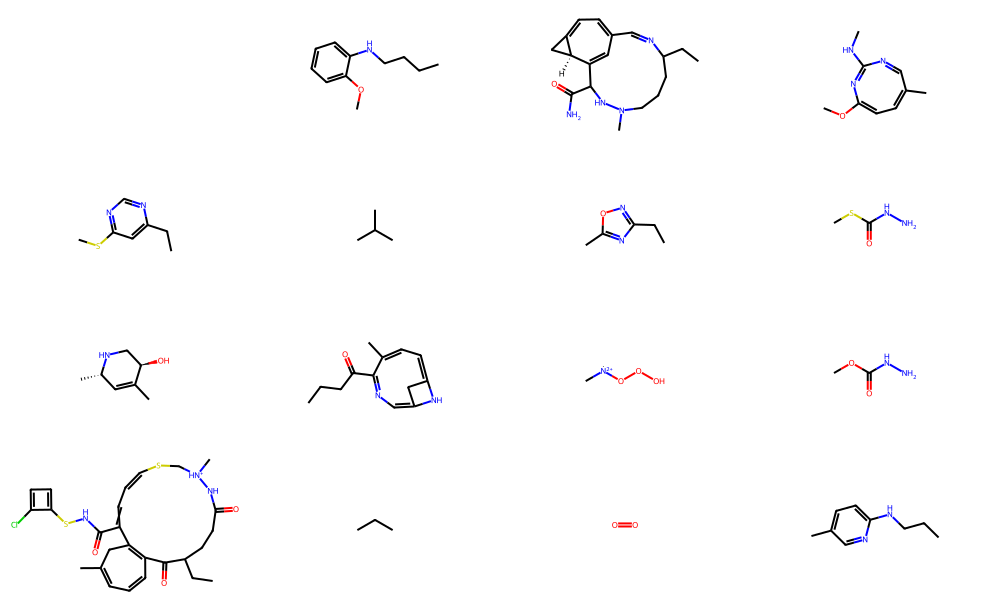

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 23, 32, 6, 21, 10, 32, 32, 32, 5, 32, 21, 32, 6, 32, 21, 26, 26, 6, 25, 18, 26, 6, 25, 32, 6, 21, 6, 32, 26, 6, 32, 6, 32, 21, 10, 2, 32, 32, 32, 21, 11, 32, 2, 32, 21, 2, 2, 10, 2, 6, 21, 21, 10, 2, 6]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(CHc)C1ccc(cCc)cCOO)N=O)Nc)C)cO)c)cC1
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.60it/s]

Epoch 65: 114/342 | ['loss=0.57262', '(kl=3.14118', 'recon=0.16427)', 'klw=0.13000 lr=0.00123']


 67%|██████▋   | 229/342 [01:28<00:44,  2.53it/s]

Epoch 65: 228/342 | ['loss=1.07788', '(kl=5.64874', 'recon=0.34355)', 'klw=0.13000 lr=0.00123']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 408.55it/s]

valid 1.133%  |  unique 0.767%


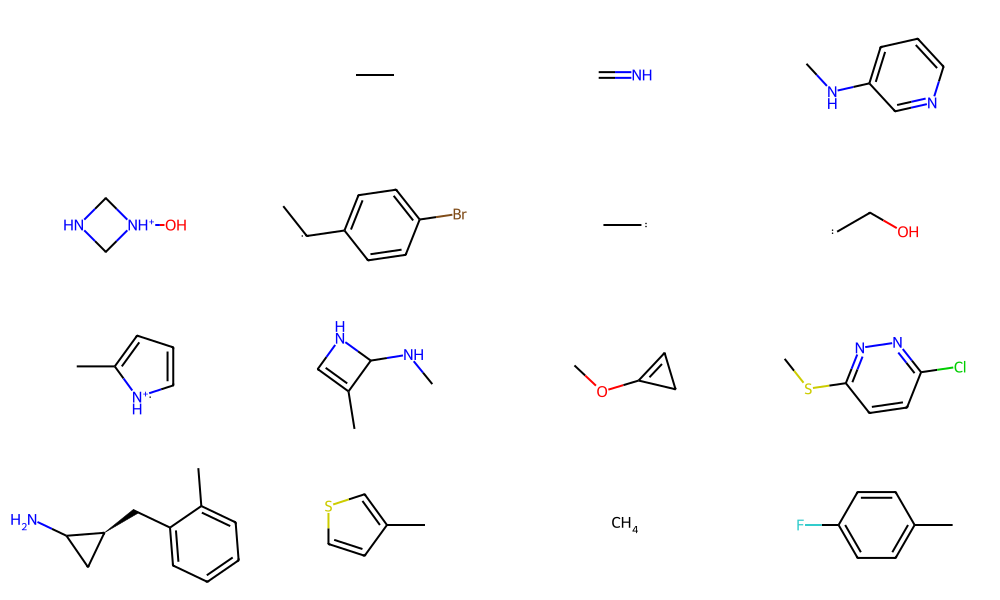

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 29, 32, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: C[c((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.60it/s]

Epoch 66: 114/342 | ['loss=0.66856', '(kl=2.84030', 'recon=0.29364)', 'klw=0.13200 lr=0.00086']


 67%|██████▋   | 229/342 [01:28<00:43,  2.60it/s]

Epoch 66: 228/342 | ['loss=1.35030', '(kl=5.85576', 'recon=0.57734)', 'klw=0.13200 lr=0.00086']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 380.75it/s]

valid 0.700%  |  unique 0.600%


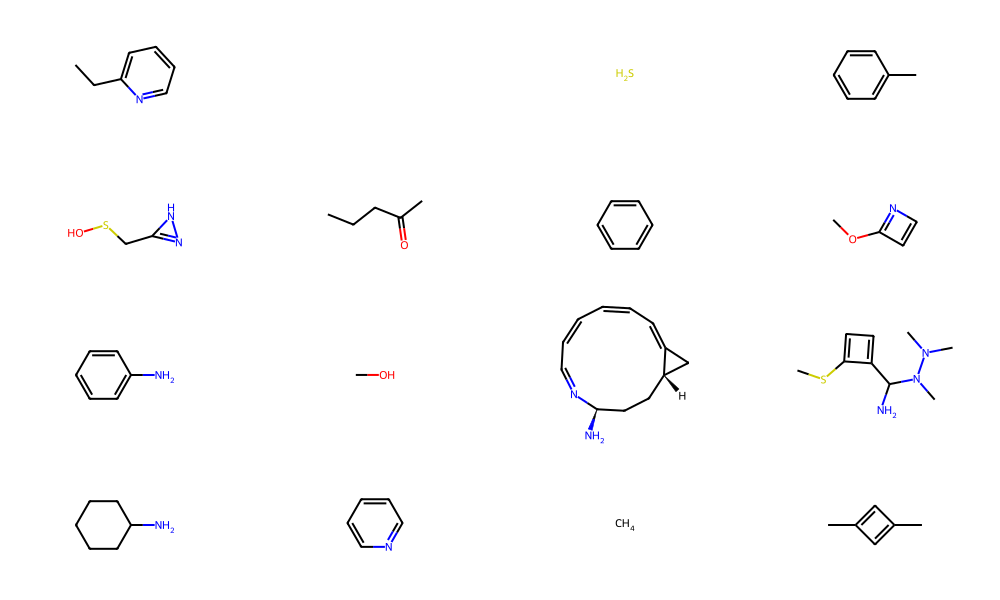

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 5, 21, 23, 23, 31, 21, 23, 23, 21, 6, 23, 21, 23, 23, 31, 23, 21, 23, 23, 32, 32, 32, 21, 6, 32, 21, 6, 32, 32, 32, 32, 21, 32, 5, 21, 6, 5, 23, 5, 32, 32, 32, 32, 5, 32, 21, 32, 5, 5, 21, 10, 21, 32, 32, 32, 32, 10, 5, 32, 21, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC(CHH]CHHC)HCHH]HCHHcccC)cC)ccccCc(C)(H(cccc(cCc((C1Ccccc1(cCc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.59it/s]

Epoch 67: 114/342 | ['loss=0.57330', '(kl=2.82195', 'recon=0.19516)', 'klw=0.13400 lr=0.00056']


 67%|██████▋   | 229/342 [01:28<00:43,  2.59it/s]

Epoch 67: 228/342 | ['loss=1.16710', '(kl=6.03737', 'recon=0.35809)', 'klw=0.13400 lr=0.00056']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 406.64it/s]

valid 1.000%  |  unique 0.833%


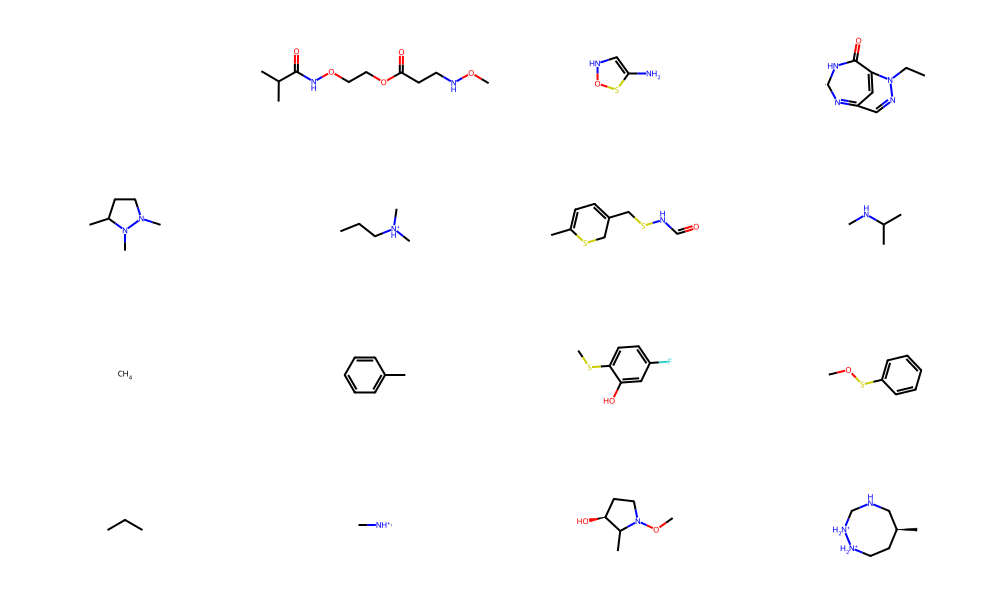

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 32, 11, 21, 21, 11, 32, 32, 32, 32, 32, 21, 11, 6, 32, 21, 18, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 21, 21, 6, 21, 5, 32, 21, 11, 32, 32, 32, 32, 21, 11, 32, 2, 32, 21, 21, 21, 11, 21, 21, 21, 21, 21, 2, 6]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(Cc2CC2cccccC2)cC=O)N=O)NCC=)CC)C(cC2ccccC2c
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.59it/s]

Epoch 68: 114/342 | ['loss=0.53471', '(kl=2.73257', 'recon=0.16308)', 'klw=0.13600 lr=0.00037']


 67%|██████▋   | 229/342 [01:28<00:44,  2.54it/s]

Epoch 68: 228/342 | ['loss=1.06071', '(kl=5.35540', 'recon=0.33238)', 'klw=0.13600 lr=0.00037']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 400.62it/s]

valid 1.033%  |  unique 0.900%


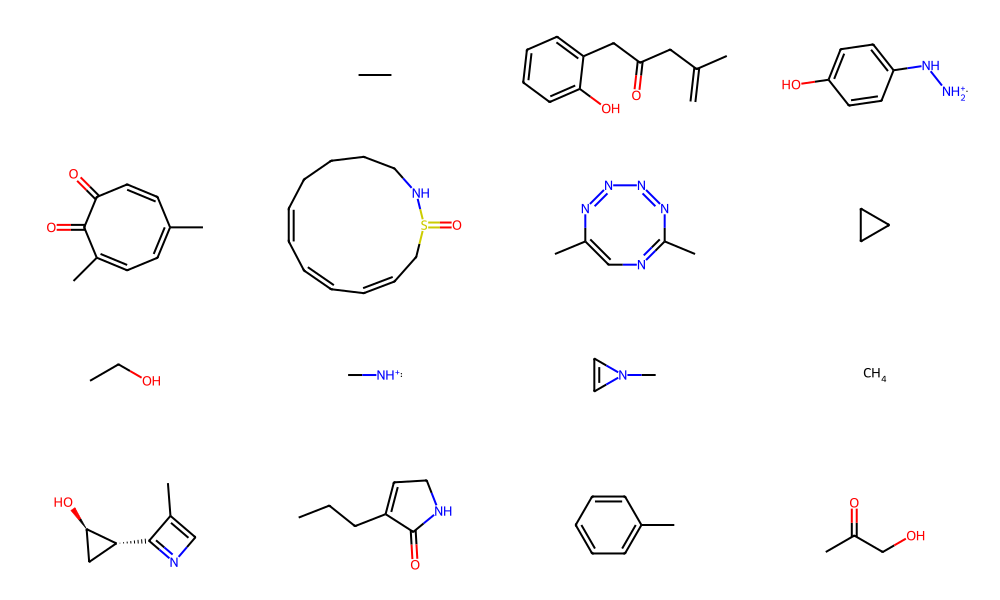

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 32, 10, 32, 32, 32, 5, 21, 11, 5, 32, 5, 11, 32, 32, 32, 32, 32, 21, 11, 6, 32, 21, 21, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 21, 21, 6, 21, 21, 32, 5, 11, 32, 32, 32, 32, 21, 11, 32, 6, 32, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: Cc1ccc(C2(c(2cccccC2)cCCO)N=O)NCC=)CC)CCc(2ccccC2c)cCCCCCCCCC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:29,  2.55it/s]

Epoch 69: 114/342 | ['loss=0.52213', '(kl=2.68456', 'recon=0.15166)', 'klw=0.13800 lr=0.00030']


 67%|██████▋   | 229/342 [01:28<00:44,  2.57it/s]

Epoch 69: 228/342 | ['loss=0.96924', '(kl=4.88103', 'recon=0.29566)', 'klw=0.13800 lr=0.00030']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 391.16it/s]

valid 1.200%  |  unique 1.000%


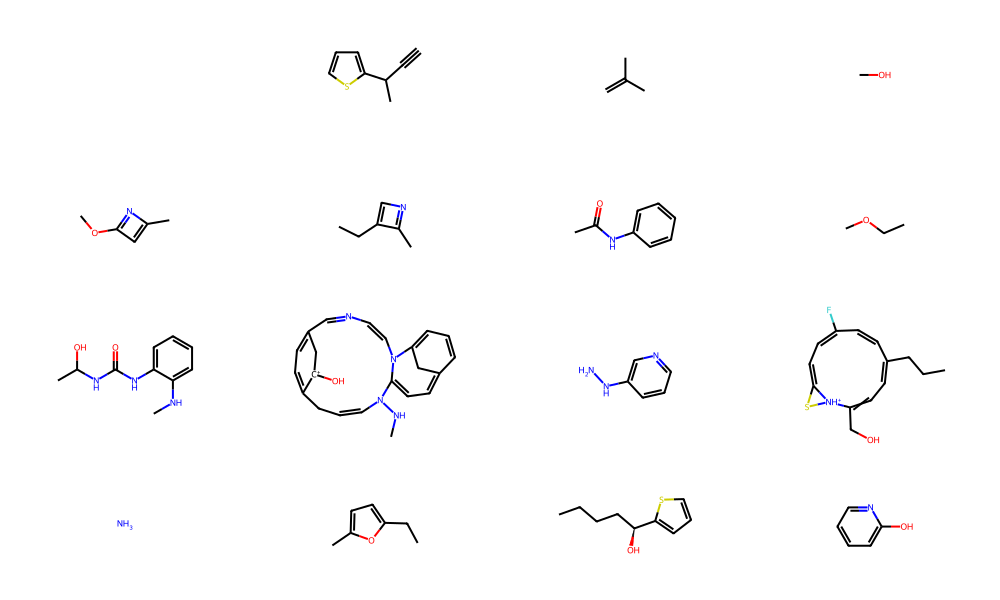

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 18, 10, 32, 32, 32, 5, 21, 32, 32, 32, 21, 11, 32, 32, 32, 5, 32, 21, 11, 6, 21, 21, 18, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 21, 21, 6, 21, 21, 21, 21, 11, 32, 32, 32, 32, 21, 11, 32, 2, 32, 21, 21, 21, 11, 21, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: C=1ccc(CcccC2ccc(cC2)CC=O)N=O)NCC=)CC)CCCC2ccccC2c
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.60it/s]

Epoch 70: 114/342 | ['loss=0.57962', '(kl=2.70878', 'recon=0.20039)', 'klw=0.14000 lr=0.00293']


 67%|██████▋   | 229/342 [01:28<00:43,  2.62it/s]

Epoch 70: 228/342 | ['loss=1.31323', '(kl=5.93635', 'recon=0.48214)', 'klw=0.14000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 392.44it/s]

valid 1.567%  |  unique 1.333%


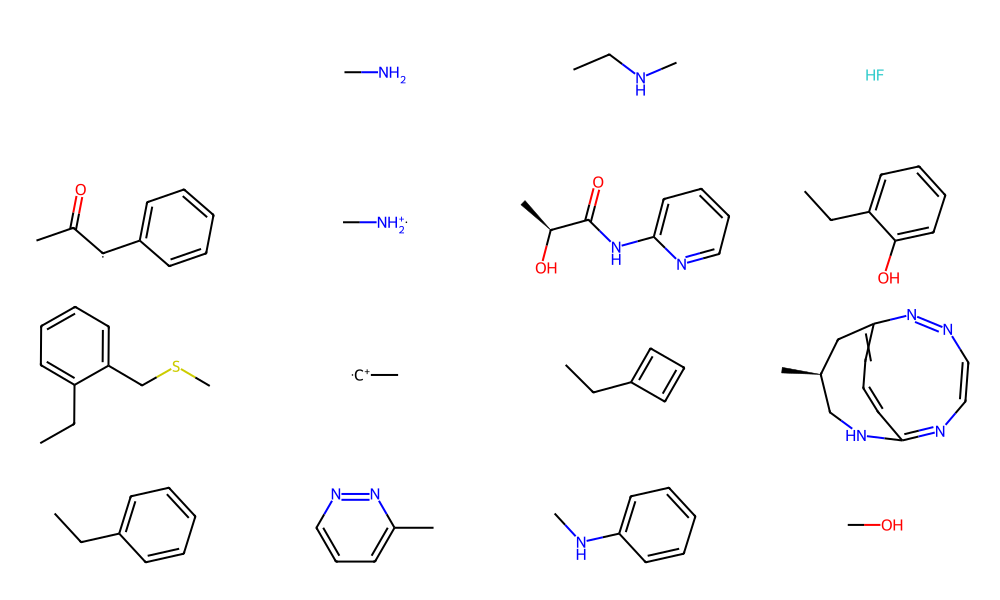

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 32, 21, 32, 11, 32, 21, 11, 32, 32, 32, 32, 32, 21, 11, 6, 32, 21, 21, 26, 6, 25, 18, 26, 6, 25, 32, 21, 18, 6, 21, 21, 6, 21, 6, 21, 21, 11, 32, 32, 32, 32, 21, 11, 31, 32, 32, 21, 21, 21, 11, 21, 21, 21, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccccCc2cC2cccccC2)cCCO)N=O)NcC=)CC)C)CC2ccccC2]ccCCC2CCCCC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.58it/s]

Epoch 71: 114/342 | ['loss=0.83892', '(kl=3.94697', 'recon=0.27844)', 'klw=0.14200 lr=0.00274']


 67%|██████▋   | 229/342 [01:28<00:43,  2.60it/s]

Epoch 71: 228/342 | ['loss=1.52078', '(kl=7.09307', 'recon=0.51357)', 'klw=0.14200 lr=0.00274']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 391.78it/s]

valid 1.033%  |  unique 0.867%


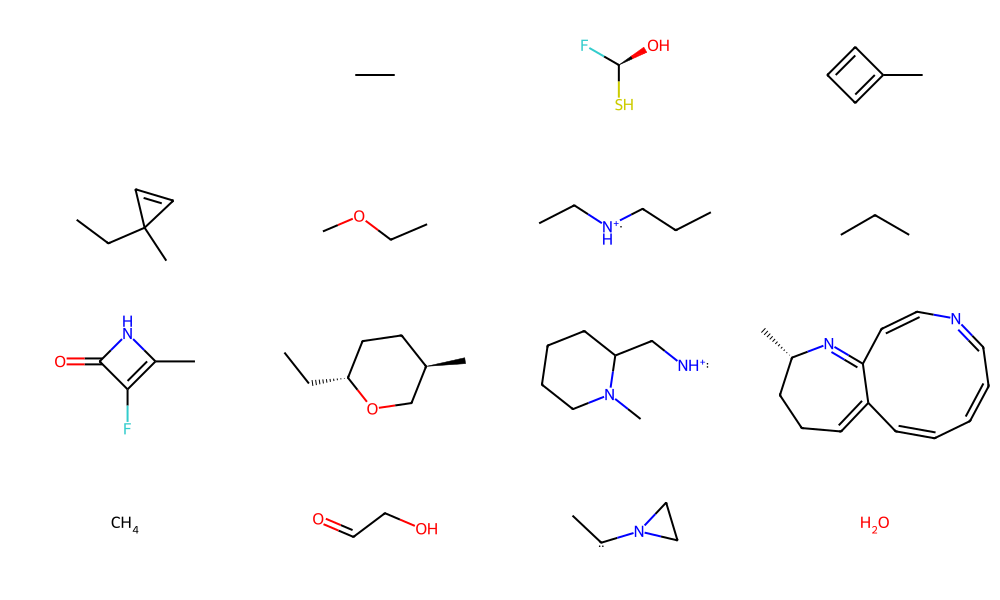

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 21, 32, 32, 10, 21, 31, 32, 21, 21, 11, 32, 32, 32, 32, 32, 21, 11, 6, 32, 21, 21, 26, 6, 21, 18, 26, 6, 21, 32, 21, 18, 6, 32, 21, 6, 21, 32, 32, 21, 11, 2, 32, 32, 32, 21, 11, 32, 2, 32, 21, 2, 11, 11, 21, 21, 21, 21, 21, 21, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1Ccc1C]cCC2cccccC2)cCCO)C=O)CcC=)cC)CccC2
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.60it/s]

Epoch 72: 114/342 | ['loss=0.90391', '(kl=4.48173', 'recon=0.25854)', 'klw=0.14400 lr=0.00244']


 67%|██████▋   | 229/342 [01:28<00:44,  2.52it/s]

Epoch 72: 228/342 | ['loss=1.76961', '(kl=8.89014', 'recon=0.48943)', 'klw=0.14400 lr=0.00244']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 391.69it/s]

valid 1.467%  |  unique 1.267%


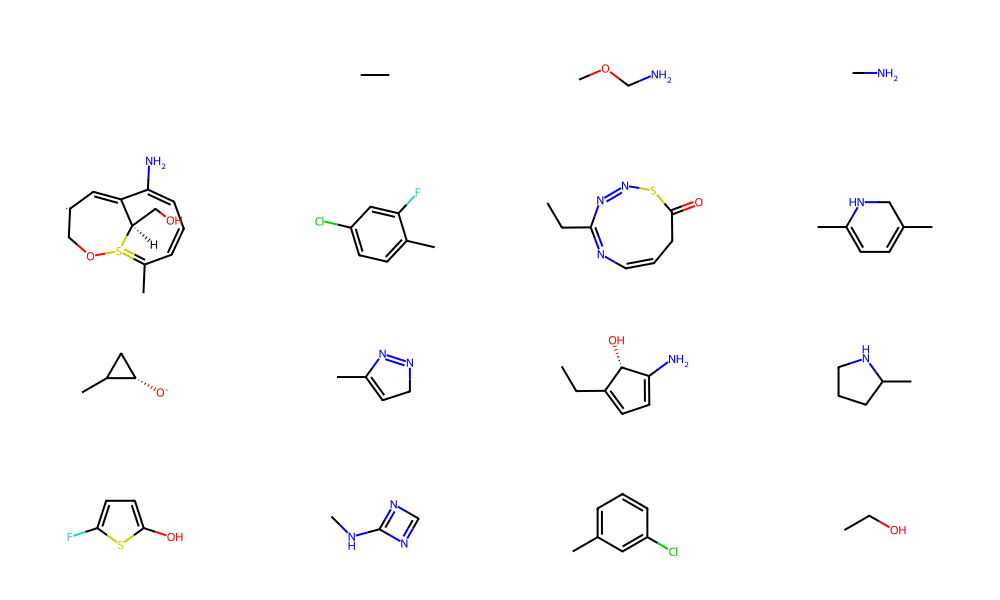

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 10, 32, 32, 32, 5, 21, 32, 11, 32, 32, 11, 32, 32, 32, 5, 32, 21, 11, 32, 32, 21, 18, 26, 6, 25, 18, 26, 6, 25, 21, 21, 18, 6, 21, 18, 6, 32, 21, 32, 10, 11, 32, 32, 32, 32, 21, 11, 11, 32, 32, 21, 21, 2, 11, 6, 21, 2, 21, 21, 2, 21]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CC1ccc(Cc2cc2ccc(cC2ccC=O)N=O)NCC=)C=)cCc12ccccC22ccCC
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:27,  2.58it/s]

Epoch 73: 114/342 | ['loss=0.92951', '(kl=4.41057', 'recon=0.28557)', 'klw=0.14600 lr=0.00207']


 67%|██████▋   | 229/342 [01:28<00:44,  2.53it/s]

Epoch 73: 228/342 | ['loss=1.81817', '(kl=8.64179', 'recon=0.55647)', 'klw=0.14600 lr=0.00207']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 386.55it/s]

valid 1.467%  |  unique 1.167%


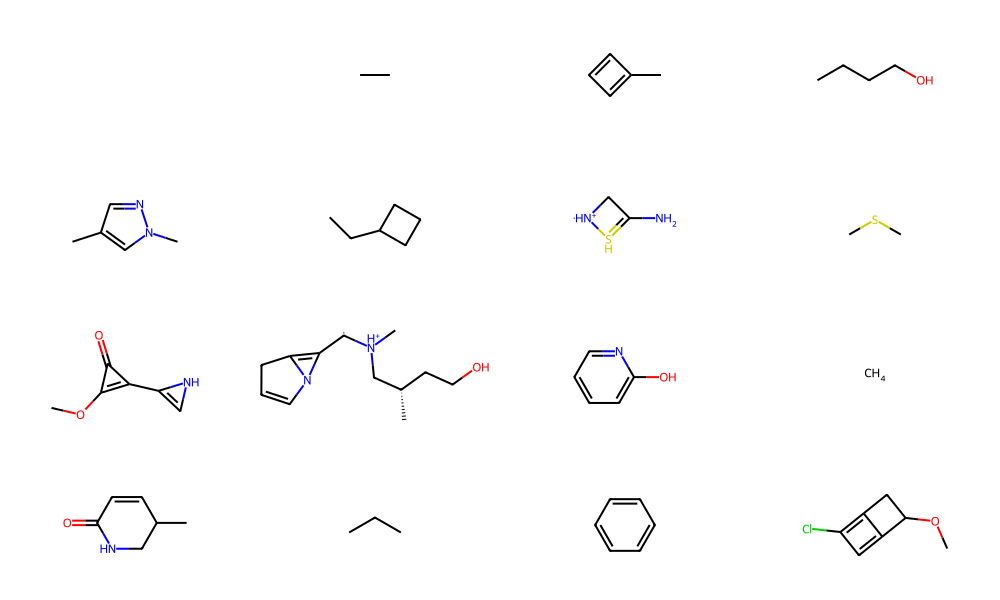

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 32, 6, 32, 21, 32, 21, 32, 32, 21, 32, 32, 21, 32, 32, 32, 32, 21, 32, 32, 32, 21, 21, 21, 6, 32, 21, 21, 6, 32, 32, 21, 21, 32, 32, 21, 32, 32, 21, 32, 21, 32, 21, 32, 32, 32, 21, 32, 32, 21, 32, 21, 32, 32, 32, 21, 32, 21, 21, 21, 32, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CCc)cCcCccCccCccccCcccCCC)cCC)ccCCccCccCcCcCcccCccCcCcccCcCCCcc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:44<01:30,  2.51it/s]

Epoch 74: 114/342 | ['loss=0.68129', '(kl=2.99202', 'recon=0.23847)', 'klw=0.14800 lr=0.00165']


 67%|██████▋   | 229/342 [01:28<00:44,  2.52it/s]

Epoch 74: 228/342 | ['loss=1.30655', '(kl=5.64191', 'recon=0.47155)', 'klw=0.14800 lr=0.00165']


Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 404.38it/s]

valid 1.267%  |  unique 0.900%


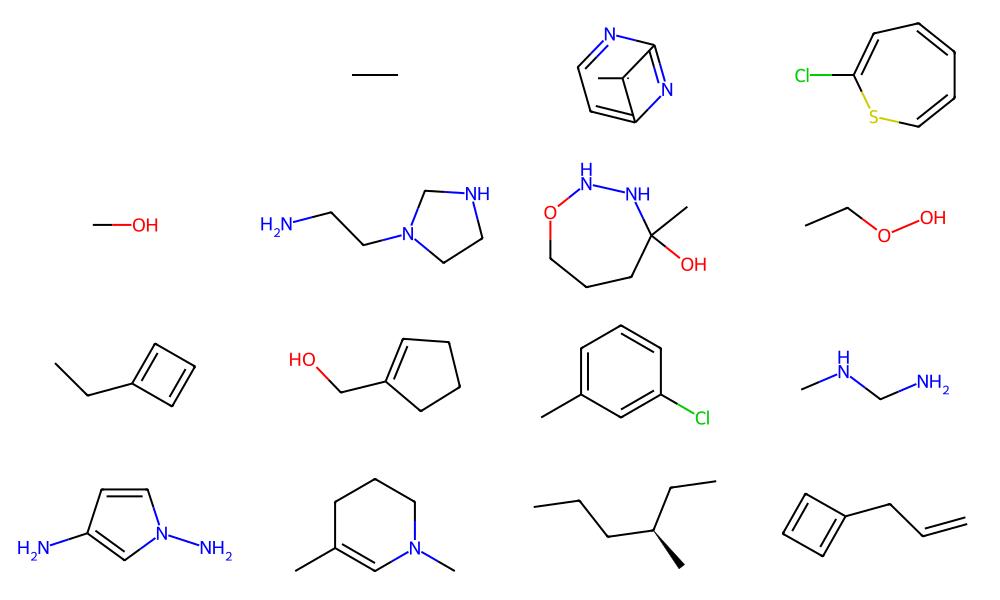

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[21, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]
fed smi: Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1
pred smi: CCccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
mol is none, cannot recon


 34%|███▎      | 115/342 [00:45<01:29,  2.55it/s]

Epoch 75: 114/342 | ['loss=0.67798', '(kl=2.55217', 'recon=0.29516)', 'klw=0.15000 lr=0.00123']


 67%|██████▋   | 229/342 [01:29<00:44,  2.55it/s]

Epoch 75: 228/342 | ['loss=1.48150', '(kl=6.50377', 'recon=0.50593)', 'klw=0.15000 lr=0.00123']


 73%|███████▎  | 250/342 [01:38<00:36,  2.55it/s]


KeyboardInterrupt: ignored

In [142]:
model = VAE(vocab,vector).to(device)
fit(model, train['smiles'])
model.eval()
sample = sample.take_samples(model, n_batch)
print(sample)

In [133]:
print(fed)
m('Cc1nnn(-n2NC1ncc((N2)NN=O)(=O)N(1=)(C)C')

Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1


In [35]:
# def string2tensor(self, string, device='model'):
#     ids = string2ids(string, add_bos=True, add_eos=True)
#     tensor = torch.tensor(ids, dtype=torch.long,device=self.device if device == 'model' else device)
#     return tensor

#   def tensor2string(self, tensor):
#     ids = tensor.tolist()
#     string = ids2string(ids, rem_bos=True, rem_eos=True)
#     return string

cannot recon
cannot recon


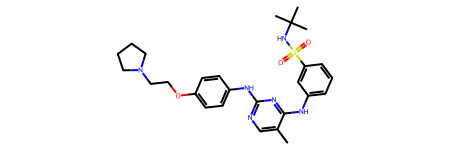

In [45]:
m(model.tensor2string(model.string2tensor(fed)))

In [64]:

len()

63

In [9]:
# def tensor2string(self, tensor):
#     ids = tensor.tolist()
#     string = ids2string(ids, rem_bos=True, rem_eos=True)
#     return string

model.tensor2string(y_here)

(38, 38)

In [21]:
y = model.reconstruct(te)
y_here_ = torch.argmax(y, dim=-1)
y_here == y_here_

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False,  True,  True,
          True, False, False, False,  True,  True,  True, False, False, False,
          True,  True, False,  True,  True,  True,  True, False, False,  True,
          True,  True,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True

In [23]:
y_here_

tensor([[25, 11, 11, 11, 11, 11, 11, 11,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8],
        [34, 36, 36, 36, 36, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         18, 24, 24, 24, 24, 24, 24, 24, 24]])

In [19]:
l = y_here.tolist()
[ids2string(ids, rem_bos=True, rem_eos=True) for ids in l]

['ss333333FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',
 'FFFFFFFFFFFFFFFFF3FFF333FFF333FF3FFFF33FFFFFFFF3FFFFFFFSSSSSSSS']

In [22]:
for i in y_h.detach().numpy():
    print(i)

[17 17 17 17 17 17 17 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28]
[17 17 17 17 17 17 17 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 22 22 22 22 22 22 22 22]


In [23]:
# y_h = y_here.cpu()
max = 0
for i in y_h.detach().numpy():
    for j in i:
        if y_here[i][j] > max:

            max = y_here[i, j]
            print(i, j, max)

RuntimeError: ignored

In [29]:
model.tensor2string(torch.tensor([2, 2, 2]))

')))'

In [17]:
56 in i2c

False

In [33]:
torch.argmax(y_here)

tensor(53, device='cuda:0')

<function get_collate_fn.<locals>.collate at 0x7cfa33ba1990>


  3%|▎         | 10/342 [00:04<02:24,  2.31it/s]


KeyboardInterrupt: ignored